Attempting to plot data from 'combined_hard.csv' and 'combined_soft.csv'...
Please ensure 'combined_soft.csv' is in the correct location and has 'MET' and 'RATE' columns.
Successfully loaded 'combined_hard.csv'. Columns: ['MET', 'RATE', 'ERROR', 'OBSID']

Successfully loaded 'combined_soft.csv'. Columns: ['MET', 'RATE', 'ERROR', 'OBSID']

Data after calculations and cleaning (first 5 rows of relevant columns):
            MET  RATE_hard   RATE_soft  hardness_ratio  total_flux
0  8.936804e+07  25.101824  344.935822        0.072772  370.037645
1  8.936834e+07  30.758686  392.846771        0.078297  423.605457
2  8.936864e+07  31.588760  395.292450        0.079912  426.881210
3  8.936894e+07  33.933498  405.466034        0.083690  439.399532
4  8.936924e+07  67.636909  623.231384        0.108526  690.868294


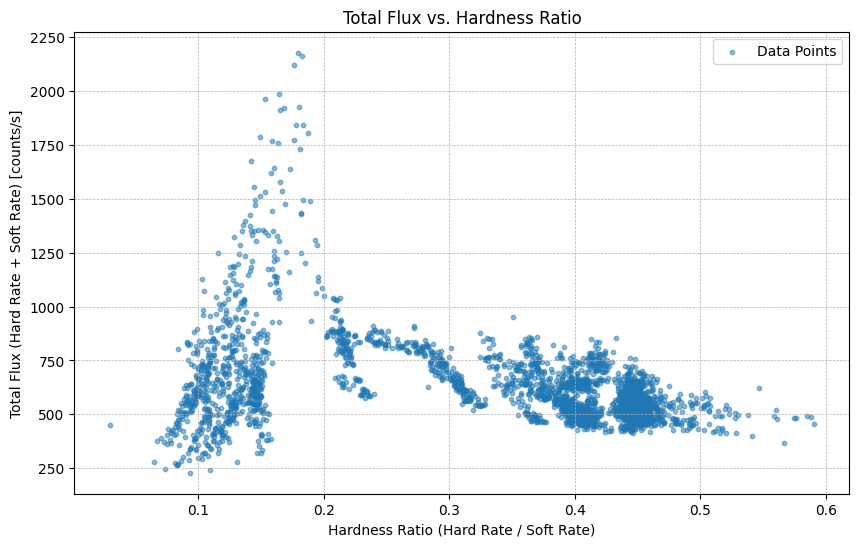

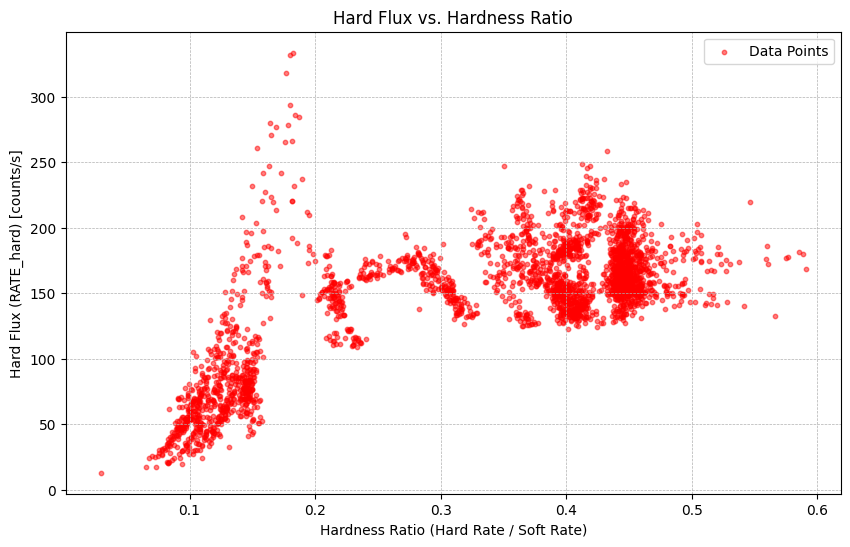

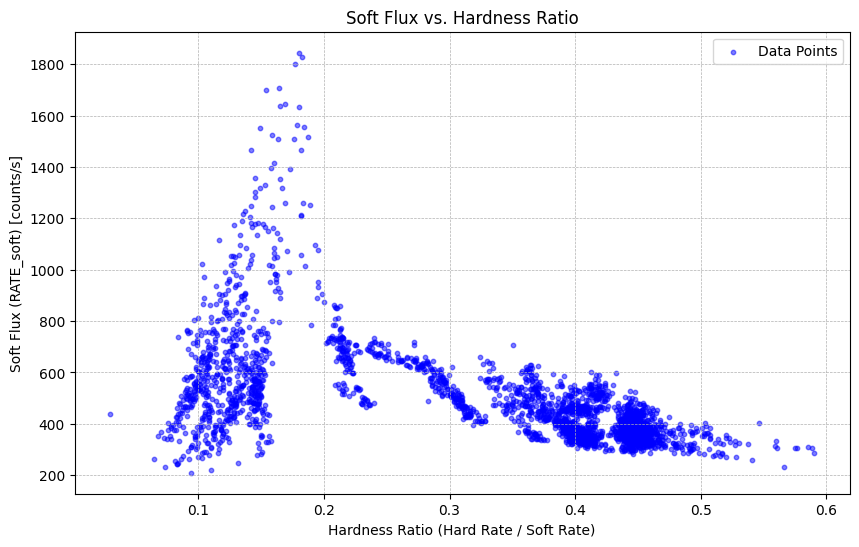

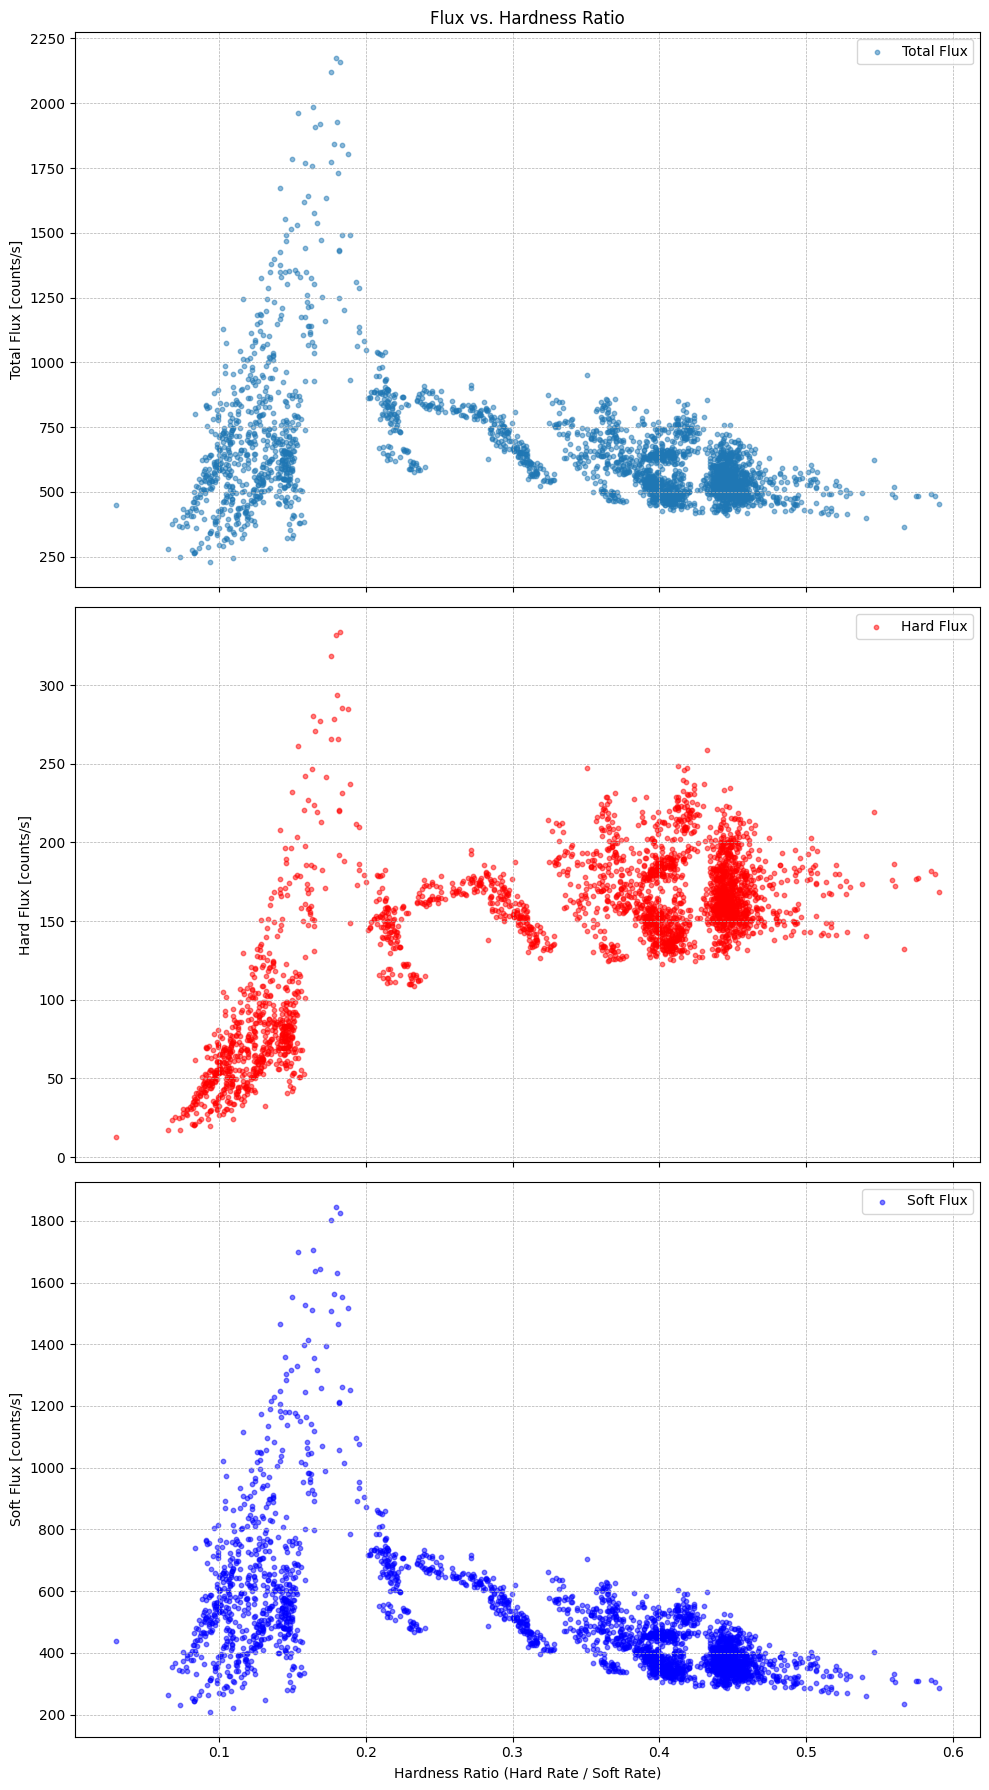

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # For handling potential division by zero or inf/NaN values

def plot_flux_and_hardness_variations(hard_file_path, soft_file_path):
    """
    Loads light curve data from hard and soft band CSV files,
    calculates hardness ratio, total flux, hard flux, and soft flux,
    and then generates three plots:
    1. Total Flux vs. Hardness Ratio
    2. Hard Flux vs. Hardness Ratio
    3. Soft Flux vs. Hardness Ratio

    Args:
        hard_file_path (str): Path to the CSV file for the hard band.
        soft_file_path (str): Path to the CSV file for the soft band.
    """
    try:
        # Load the data
        df_hard = pd.read_csv(hard_file_path)
        df_soft = pd.read_csv(soft_file_path)

        print(f"Successfully loaded '{hard_file_path}'. Columns: {list(df_hard.columns)}")
        # print("First 5 rows of hard data:")
        # print(df_hard.head())

        print(f"\nSuccessfully loaded '{soft_file_path}'. Columns: {list(df_soft.columns)}")
        # print("First 5 rows of soft data:")
        # print(df_soft.head())

        # Ensure required columns exist
        required_cols = ['MET', 'RATE']
        for col in required_cols:
            if col not in df_hard.columns:
                raise ValueError(f"Column '{col}' not found in {hard_file_path}")
            if col not in df_soft.columns:
                raise ValueError(f"Column '{col}' not found in {soft_file_path}")

        # Merge the two dataframes based on the 'MET' column (time)
        df_merged = pd.merge(df_hard, df_soft, on='MET', suffixes=('_hard', '_soft'))

        if df_merged.empty:
            print("Warning: The merged dataframe is empty. "
                  "This might be due to no matching 'MET' values in the two files.")
            return

        hard_rate_col = 'RATE_hard'
        soft_rate_col = 'RATE_soft'

        # Calculate Hardness Ratio (HR = Hard_Rate / Soft_Rate)
        df_merged['soft_rate_no_zero'] = df_merged[soft_rate_col].replace(0, np.nan)
        df_merged['hardness_ratio'] = df_merged[hard_rate_col] / df_merged['soft_rate_no_zero']

        # Calculate Fluxes
        df_merged['total_flux'] = df_merged[hard_rate_col] + df_merged[soft_rate_col]
        # Hard flux is simply df_merged[hard_rate_col]
        # Soft flux is simply df_merged[soft_rate_col]

        # --- Data Cleaning/Filtering ---
        df_cleaned = df_merged.replace([np.inf, -np.inf], np.nan).dropna(
            subset=['hardness_ratio', 'total_flux', hard_rate_col, soft_rate_col]
        )

        if df_cleaned.empty:
            print("Warning: After cleaning NaN/inf values, the dataframe is empty. No data to plot.")
            return

        print(f"\nData after calculations and cleaning (first 5 rows of relevant columns):")
        print(df_cleaned[['MET', hard_rate_col, soft_rate_col, 'hardness_ratio', 'total_flux']].head())

        # --- Create the plots ---

        # Plot 1: Total Flux vs. Hardness Ratio
        plt.figure(figsize=(10, 6))
        plt.scatter(df_cleaned['hardness_ratio'], df_cleaned['total_flux'], alpha=0.5, s=10, label='Data Points')
        plt.xlabel('Hardness Ratio (Hard Rate / Soft Rate)')
        plt.ylabel('Total Flux (Hard Rate + Soft Rate) [counts/s]')
        plt.title('Total Flux vs. Hardness Ratio')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

        # Plot 2: Hard Flux vs. Hardness Ratio
        plt.figure(figsize=(10, 6))
        plt.scatter(df_cleaned['hardness_ratio'], df_cleaned[hard_rate_col], alpha=0.5, s=10, color='red', label='Data Points')
        plt.xlabel('Hardness Ratio (Hard Rate / Soft Rate)')
        plt.ylabel('Hard Flux (RATE_hard) [counts/s]')
        plt.title('Hard Flux vs. Hardness Ratio')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

        # Plot 3: Soft Flux vs. Hardness Ratio
        plt.figure(figsize=(10, 6))
        plt.scatter(df_cleaned['hardness_ratio'], df_cleaned[soft_rate_col], alpha=0.5, s=10, color='blue', label='Data Points')
        plt.xlabel('Hardness Ratio (Hard Rate / Soft Rate)')
        plt.ylabel('Soft Flux (RATE_soft) [counts/s]')
        plt.title('Soft Flux vs. Hardness Ratio')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.show()

        #--- Optional: Using Subplots for a combined view ---
        fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True) # sharex if HR range is similar

        # Total Flux vs HR
        axs[0].scatter(df_cleaned['hardness_ratio'], df_cleaned['total_flux'], alpha=0.5, s=10)
        axs[0].set_ylabel('Total Flux [counts/s]')
        axs[0].set_title('Flux vs. Hardness Ratio')
        axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
        axs[0].legend(['Total Flux'])

        # Hard Flux vs HR
        axs[1].scatter(df_cleaned['hardness_ratio'], df_cleaned[hard_rate_col], alpha=0.5, s=10, color='red')
        axs[1].set_ylabel('Hard Flux [counts/s]')
        axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
        axs[1].legend(['Hard Flux'])

        # Soft Flux vs HR
        axs[2].scatter(df_cleaned['hardness_ratio'], df_cleaned[soft_rate_col], alpha=0.5, s=10, color='blue')
        axs[2].set_ylabel('Soft Flux [counts/s]')
        axs[2].set_xlabel('Hardness Ratio (Hard Rate / Soft Rate)')
        axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)
        axs[2].legend(['Soft Flux'])

        plt.tight_layout()
        plt.show()


    except FileNotFoundError:
        print(f"Error: One of the files was not found. "
              f"Please ensure '{hard_file_path}' and '{soft_file_path}' exist and paths are correct.")
    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        print("This could be due to unexpected column names or data issues.")
        if 'df_hard' in locals():
            print("Hard file columns:", df_hard.columns)
        if 'df_soft' in locals():
            print("Soft file columns:", df_soft.columns)
        if 'df_merged' in locals() and not df_merged.empty:
             print("Merged columns:", df_merged.columns)


# --- How to use the function ---
if __name__ == '__main__':
    # IMPORTANT: Replace these with the actual paths to your CSV files
    hard_csv_file = 'combined_hard.csv'  # This file was uploaded by you
    soft_csv_file = 'combined_soft.csv'  # <<< YOU NEED TO PROVIDE THIS FILE

    print(f"Attempting to plot data from '{hard_csv_file}' and '{soft_csv_file}'...")
    print(f"Please ensure '{soft_csv_file}' is in the correct location and has 'MET' and 'RATE' columns.")

    plot_flux_and_hardness_variations(hard_csv_file, soft_csv_file)


Processing file: combined_hard.csv


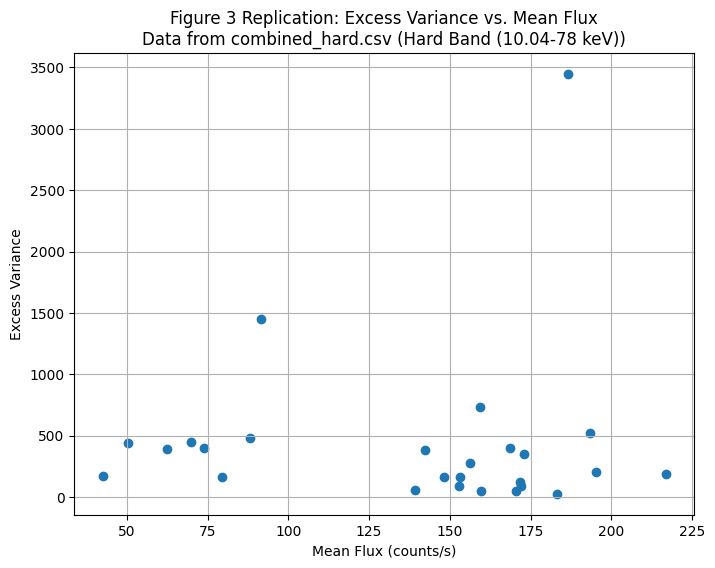


Processing file: combined_soft.csv


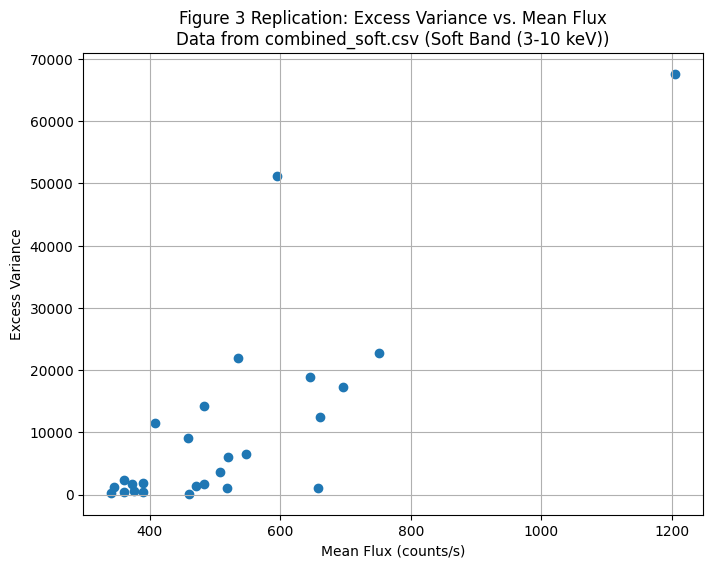


Processing file: combined_full.csv


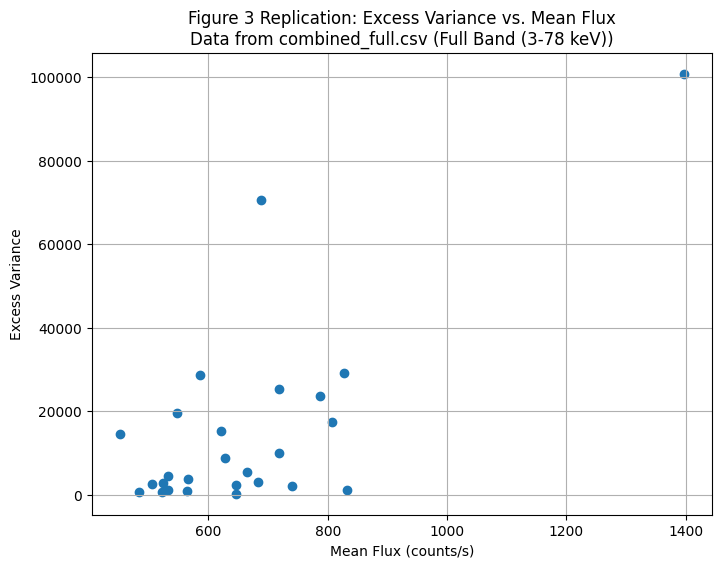


--- Plotting Note from the Paper ---
The paper's Figure 3 is titled 'Rms-flux' and its caption reads: 'Relationship between the rms variability and mean flux for the blazar PKS 2155-304.' [cite: 991]
However, the y-axis of Figure 3 is explicitly labeled 'Excess variance'[cite: 991].
The script's 'plot_rms_on_y_axis' variable controls what is plotted on the y-axis.
Currently, plot_rms_on_y_axis is set to: False
Only positive excess variance values are used for plotting, as stated in the paper[cite: 989].


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_rms_flux_data(df):
    """
    Calculates mean flux and excess variance for each observation ID.

    Args:
        df (pd.DataFrame): DataFrame with 'OBSID', 'RATE', and 'ERROR' columns.

    Returns:
        pd.DataFrame: DataFrame with 'OBSID', 'Mean_Flux', 'Excess_Variance', and 'RMS'.
    """
    results = []
    for obsid, group in df.groupby('OBSID'):
        # Variance requires at least 2 data points for sample variance.
        # The paper's calculations are per-observation (OBSID).
        if group.empty or len(group['RATE']) < 2:
            print(f"Skipping OBSID {obsid} due to insufficient data points ({len(group['RATE'])}) for variance calculation.")
            continue

        mean_flux = group['RATE'].mean()

        # According to the paper's Equation (1) and surrounding text, S^2 is the sample variance
        # of the light curve. Pandas .var() defaults to ddof=1 (sample variance).
        s_squared = group['RATE'].var()

        # Handle cases where variance might be NaN (e.g., all rates are the same for an OBSID)
        if pd.isna(s_squared):
            s_squared = 0 # If all rates are the same, variance is 0.

        mean_sigma_err_squared = (group['ERROR']**2).mean()
        excess_variance = s_squared - mean_sigma_err_squared

        # From the paper (page 6, section 4.2): "Positive sigma_XS^2 values indicate intrinsic source variability,
        # while negative values, potentially arising from observational noise, were excluded from the analysis." [cite: 989]
        if excess_variance > 0:
            results.append({
                'OBSID': obsid,
                'Mean_Flux': mean_flux,
                'Excess_Variance': excess_variance,
                'RMS': np.sqrt(excess_variance) # RMS is the square root of excess variance
            })

    return pd.DataFrame(results)

def plot_rms_vs_flux(data, title, plot_rms=False):
    """
    Plots RMS variability or Excess Variance vs. Mean Flux.

    Args:
        data (pd.DataFrame): DataFrame with 'Mean_Flux', 'Excess_Variance', and 'RMS'.
        title (str): The title for the plot.
        plot_rms (bool): If True, plots RMS on y-axis. Otherwise, plots Excess Variance.
    """
    if data.empty:
        print(f"No data to plot for {title}. This might be due to all non-positive excess variances or insufficient data for OBSIDs.")
        return

    plt.figure(figsize=(8, 6))

    y_data_label = 'RMS Variability' if plot_rms else 'Excess Variance'
    y_data_column = 'RMS' if plot_rms else 'Excess_Variance'

    plt.scatter(data['Mean_Flux'], data[y_data_column], marker='o') # Removed label=y_data_label to avoid redundant legend if only one thing is plotted

    plt.xlabel('Mean Flux (counts/s)')
    plt.ylabel(y_data_label)
    plt.title(f'Figure 3 Replication: {y_data_label} vs. Mean Flux\n{title}')
    plt.grid(True)
    # plt.legend() # Only useful if multiple datasets are plotted on the same axes or if the label is very informative
    plt.show()

# --- INSTRUCTIONS ---
# 1. Save this code as a Python file (e.g., plot_script.py) in the SAME DIRECTORY
#    as your CSV files: 'combined_hard.csv', 'combined_soft.csv', 'combined_full.csv'.
# 2. If your files are in a different directory, you will need to modify the
#    file_paths list below to include the full path to each file.
# 3. Run the script from your terminal: python plot_script.py
#
# Example: If your files are in a 'data' subdirectory:
# file_paths = ['data/combined_hard.csv', 'data/combined_soft.csv', 'data/combined_full.csv']

file_paths = ['combined_hard.csv', 'combined_soft.csv', 'combined_full.csv']
energy_bands = ['Hard Band (10.04-78 keV)', 'Soft Band (3-10 keV)', 'Full Band (3-78 keV)']

# --- Configuration for Y-axis ---
# Figure 3 in the paper has "Excess variance" on the y-axis[cite: 991].
# Your request was for "RMS variability vs mean flux".
# RMS is sqrt(Excess Variance).
# Set plot_rms_on_y_axis = False to match Figure 3's Y-AXIS LABEL.
# Set plot_rms_on_y_axis = True to plot RMS Variability on the Y-axis.
plot_rms_on_y_axis = False


for i, file_path in enumerate(file_paths):
    print(f"\nProcessing file: {file_path}")
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Ensure required columns exist
        required_cols = ['MET', 'RATE', 'ERROR', 'OBSID'] # As per user's problem description
        if not all(col in df.columns for col in required_cols):
            print(f"Skipping {file_path}: Missing one or more required columns ({', '.join(required_cols)}).")
            print(f"Found columns: {df.columns.tolist()}")
            continue

        if df.empty:
            print(f"Skipping {file_path}: File is empty.")
            continue

        # Calculate the data for the plot
        plot_data = calculate_rms_flux_data(df)

        # Generate the plot
        plot_rms_vs_flux(plot_data, title=f'Data from {file_path} ({energy_bands[i]})', plot_rms=plot_rms_on_y_axis)

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it is in the correct directory, or update the 'file_paths' list in the script.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_path}' is empty (or could not be parsed as CSV).")
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")

print("\n--- Plotting Note from the Paper ---")
print("The paper's Figure 3 is titled 'Rms-flux' and its caption reads: 'Relationship between the rms variability and mean flux for the blazar PKS 2155-304.' [cite: 991]")
print("However, the y-axis of Figure 3 is explicitly labeled 'Excess variance'[cite: 991].")
print("The script's 'plot_rms_on_y_axis' variable controls what is plotted on the y-axis.")
print(f"Currently, plot_rms_on_y_axis is set to: {plot_rms_on_y_axis}")
#print("The calculation for excess variance (<span class="math-inline">\\\\sigma\_\{XS\}^\{2\}</span>) is based on Equation (1) in the paper: <span class="math-inline">\\\\sigma\_\{XS\}^\{2\} \= S^\{2\} \- \\\\overline\{\\\\sigma\}\_\{err\}^\{2\}</span>[cite: 962].")
#print("<span class="math-inline">S^2</span> is the sample variance of the 'RATE' for each 'OBSID', and <span class="math-inline">\\\\overline\{\\\\sigma\}\_\{err\}^\{2\}</span> is the mean of the squared 'ERROR' values for that 'OBSID'[cite: 962].")
print("Only positive excess variance values are used for plotting, as stated in the paper[cite: 989].")

--- Processing file: combined_hard.csv (Hard Band (10.04-78 keV)) ---

Found 26 unique OBSIDs in combined_hard.csv.


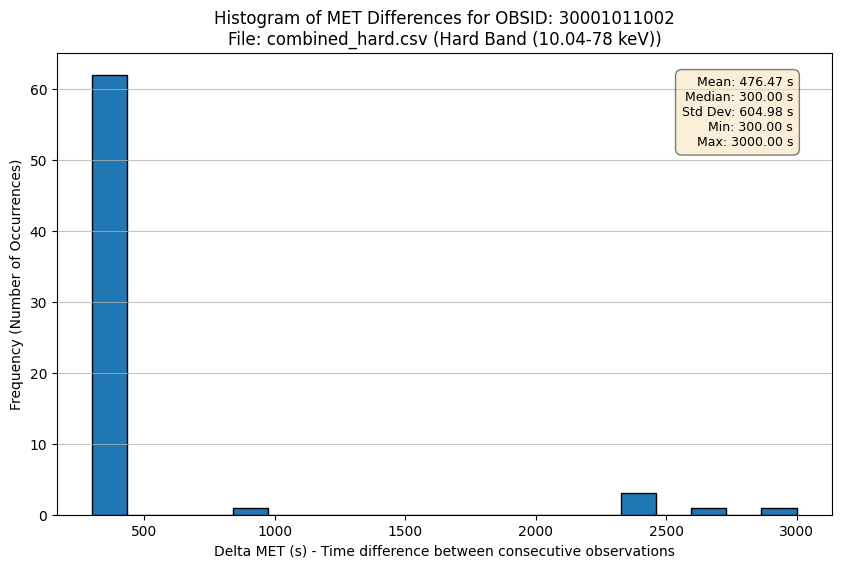

  Displayed histogram for OBSID 30001011002 from combined_hard.csv.


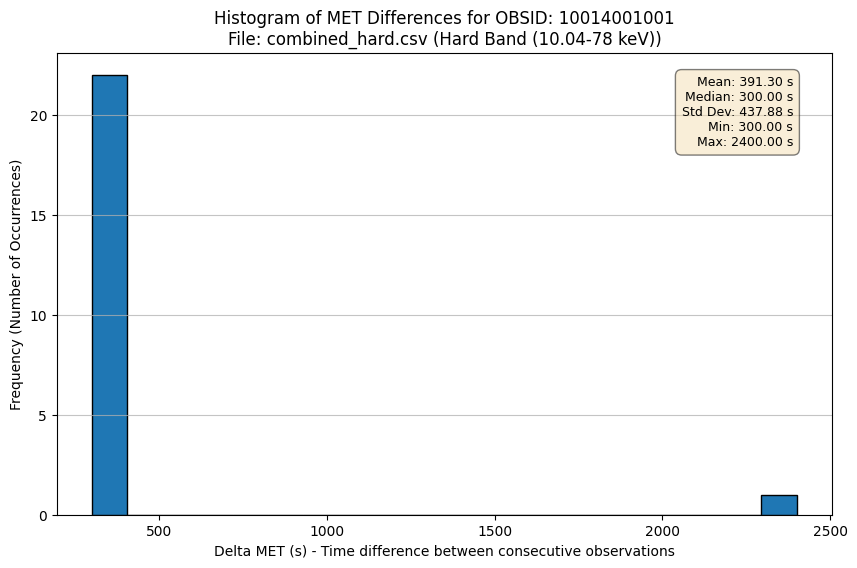

  Displayed histogram for OBSID 10014001001 from combined_hard.csv.


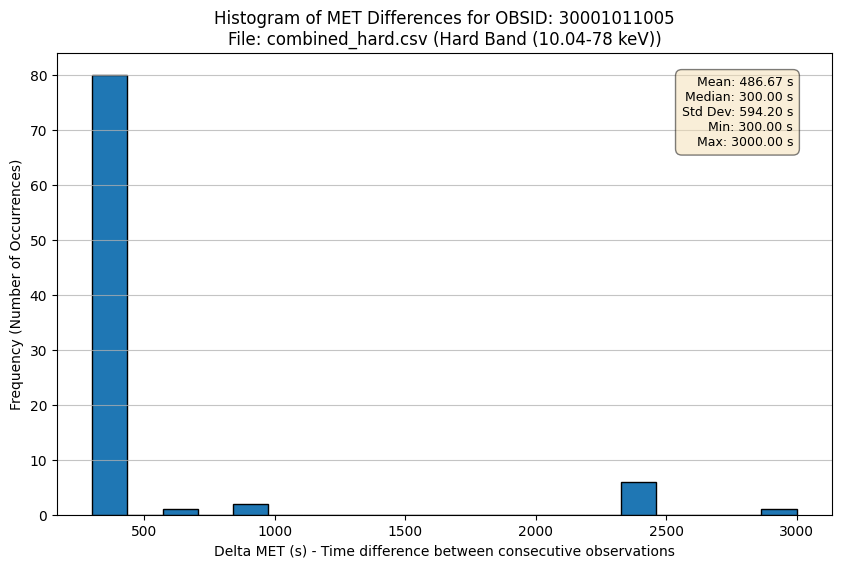

  Displayed histogram for OBSID 30001011005 from combined_hard.csv.


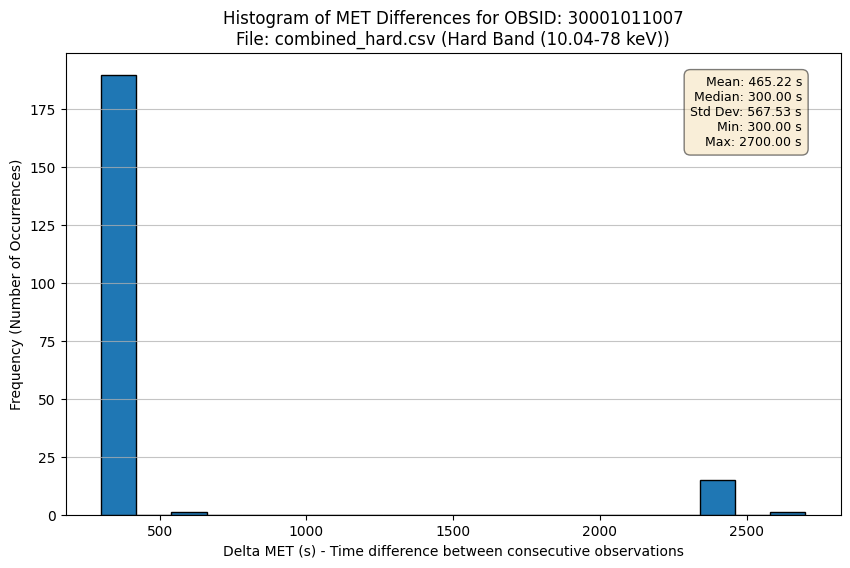

  Displayed histogram for OBSID 30001011007 from combined_hard.csv.


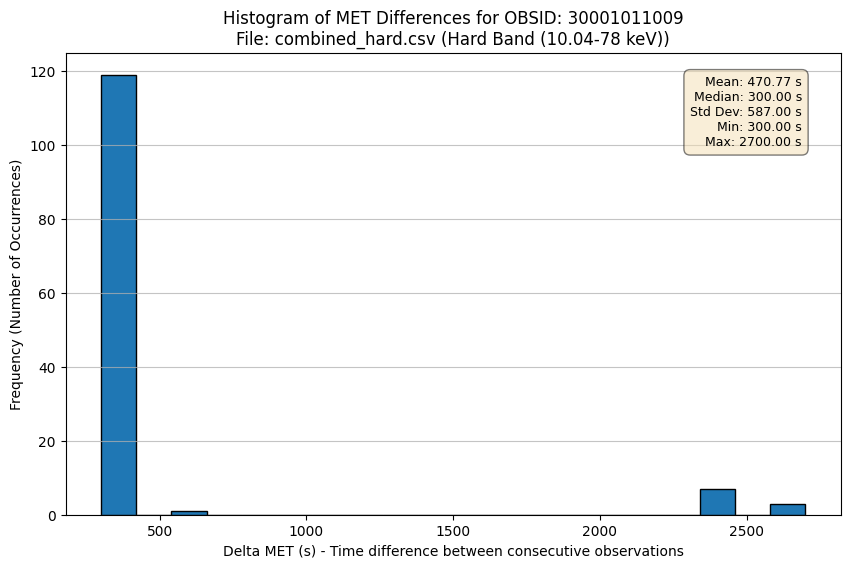

  Displayed histogram for OBSID 30001011009 from combined_hard.csv.


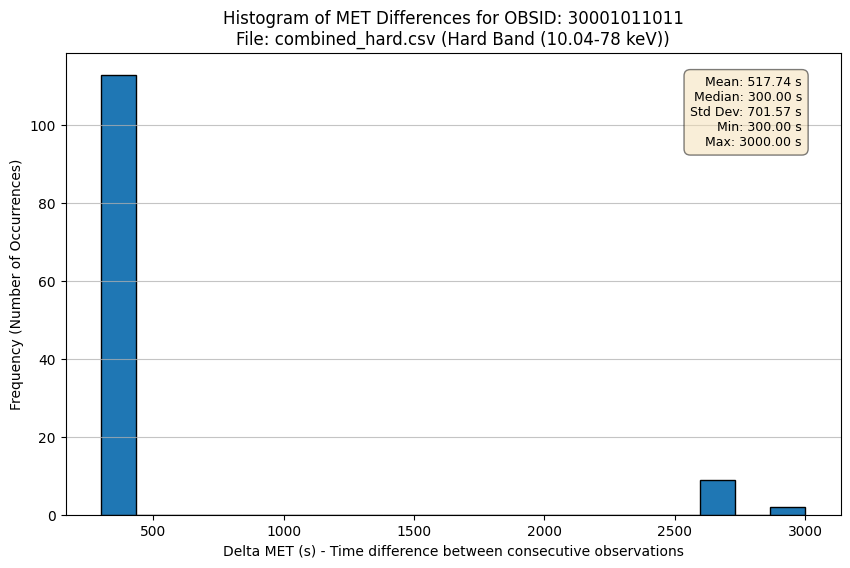

  Displayed histogram for OBSID 30001011011 from combined_hard.csv.


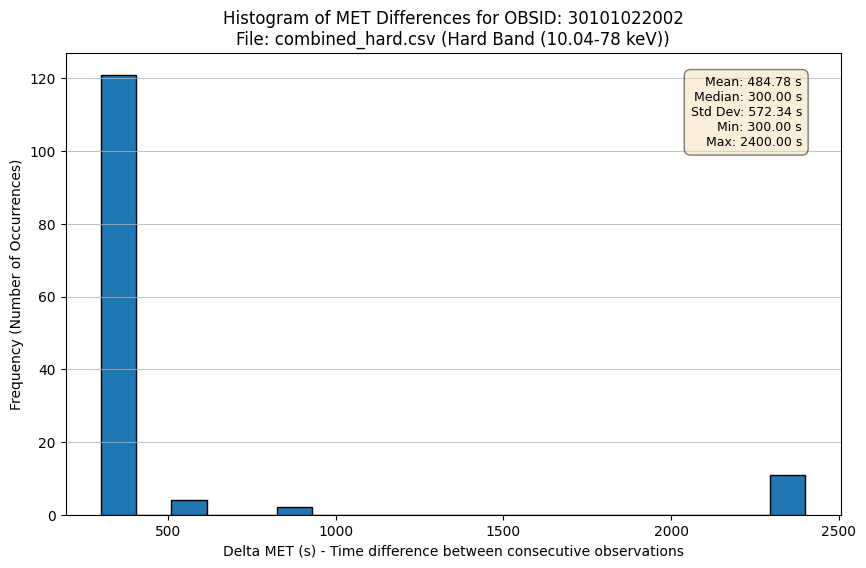

  Displayed histogram for OBSID 30101022002 from combined_hard.csv.


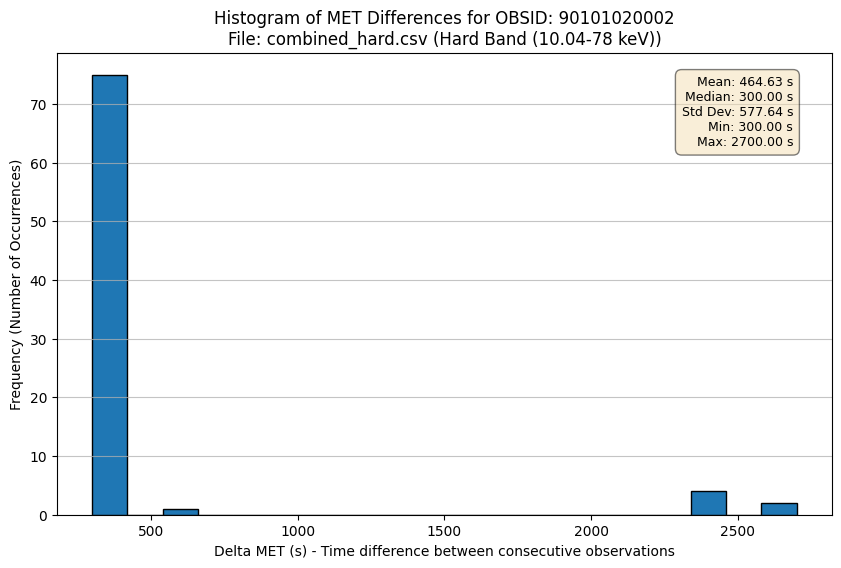

  Displayed histogram for OBSID 90101020002 from combined_hard.csv.


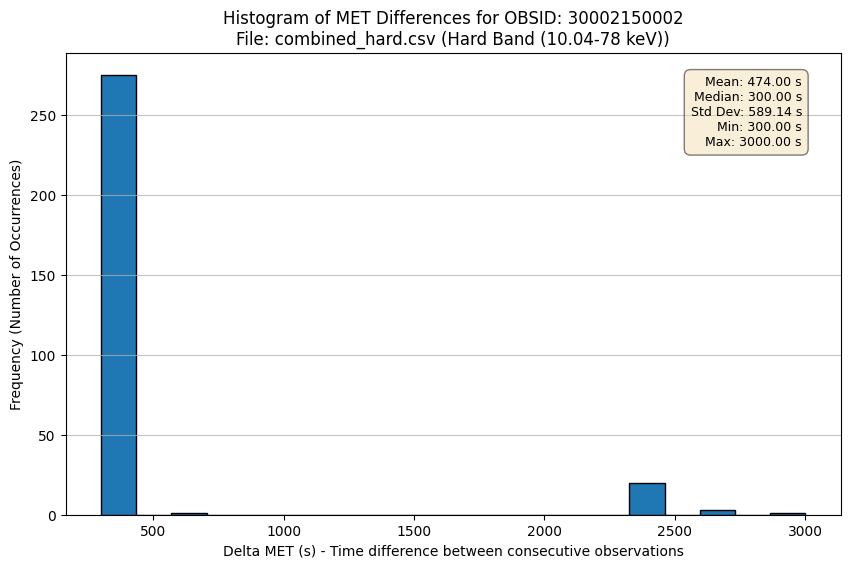

  Displayed histogram for OBSID 30002150002 from combined_hard.csv.


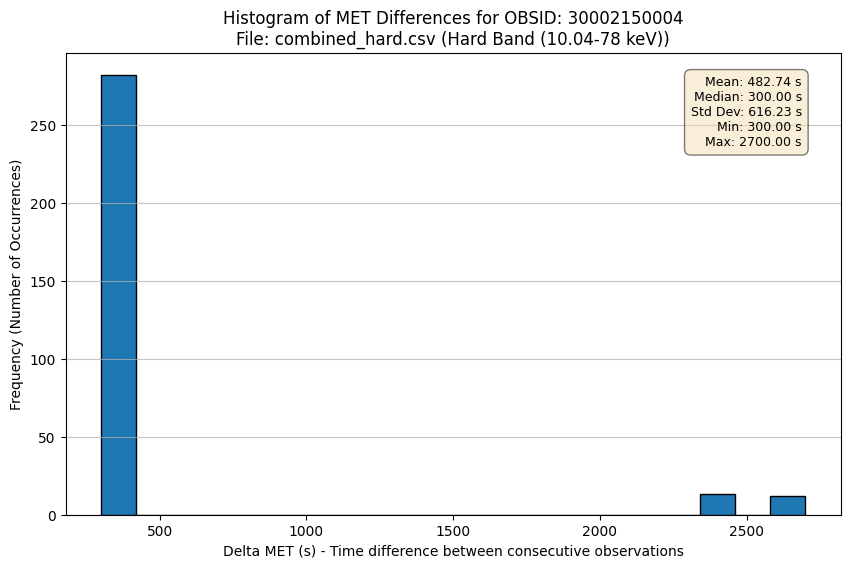

  Displayed histogram for OBSID 30002150004 from combined_hard.csv.


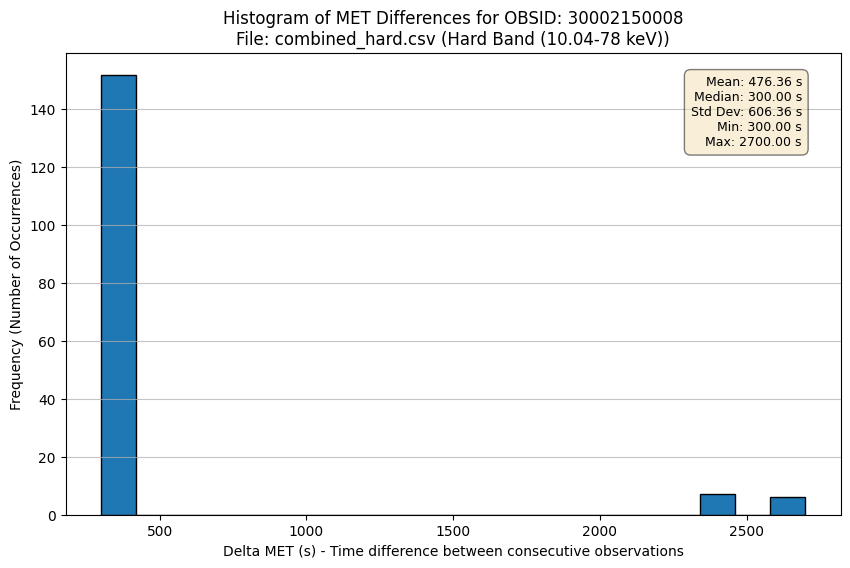

  Displayed histogram for OBSID 30002150008 from combined_hard.csv.


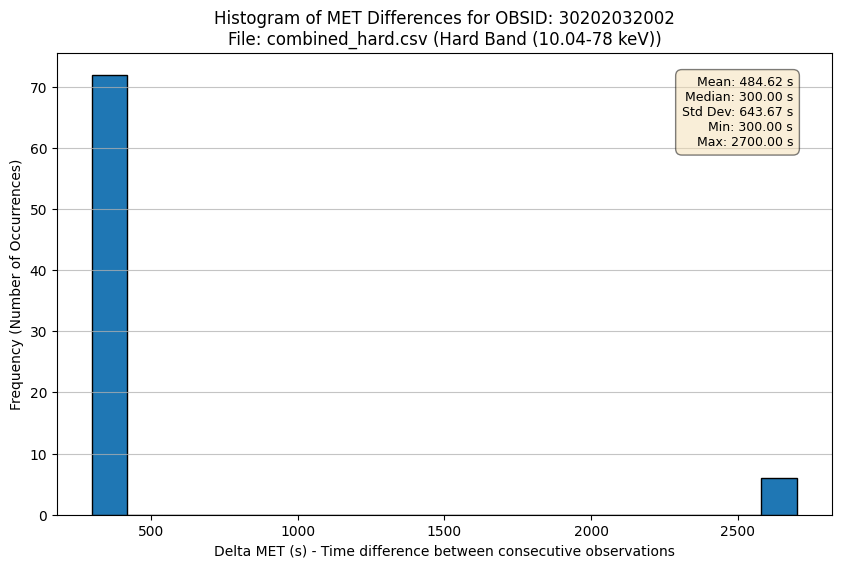

  Displayed histogram for OBSID 30202032002 from combined_hard.csv.


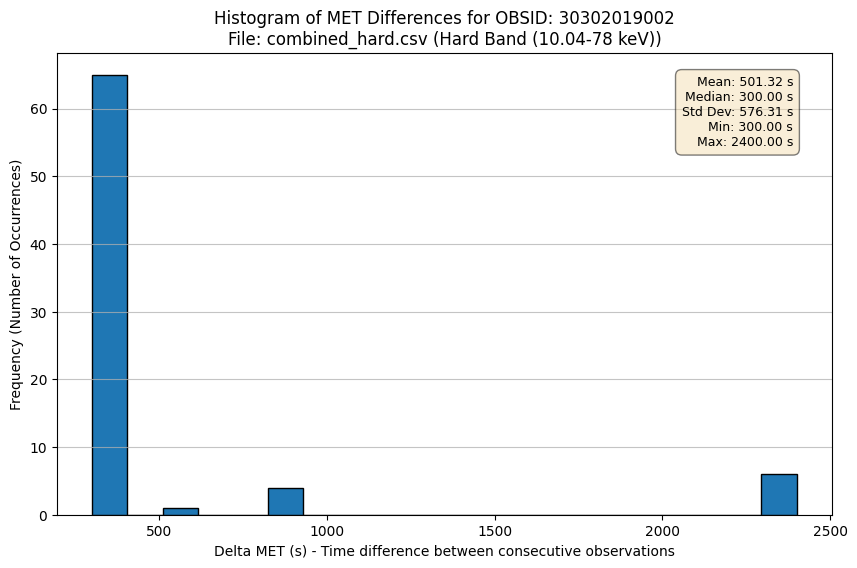

  Displayed histogram for OBSID 30302019002 from combined_hard.csv.


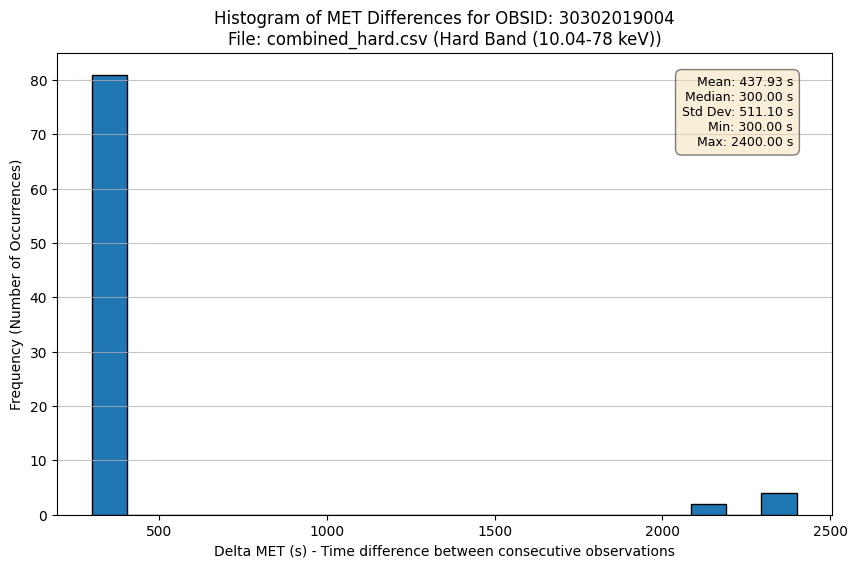

  Displayed histogram for OBSID 30302019004 from combined_hard.csv.


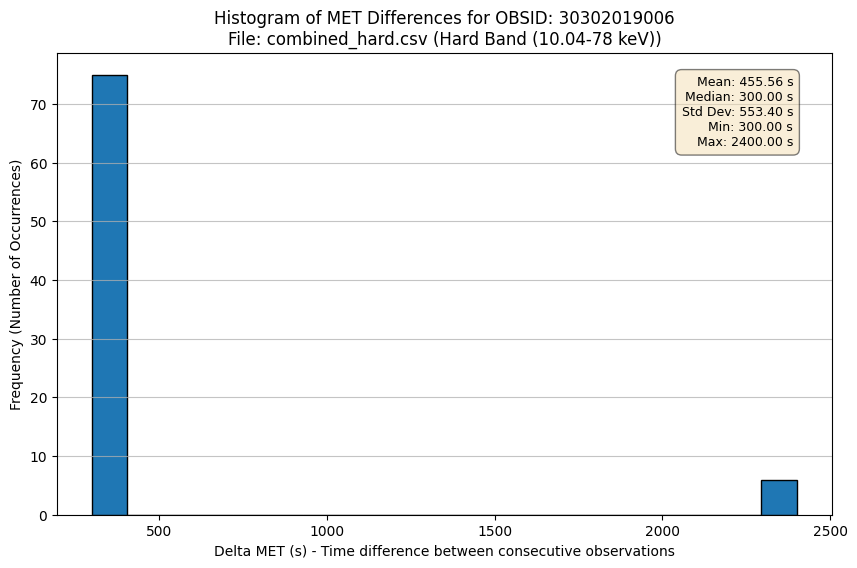

  Displayed histogram for OBSID 30302019006 from combined_hard.csv.


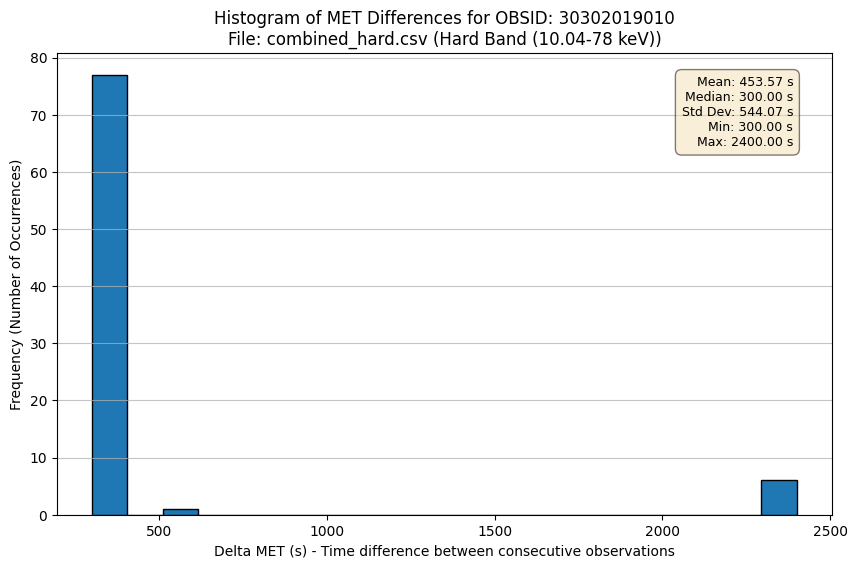

  Displayed histogram for OBSID 30302019010 from combined_hard.csv.


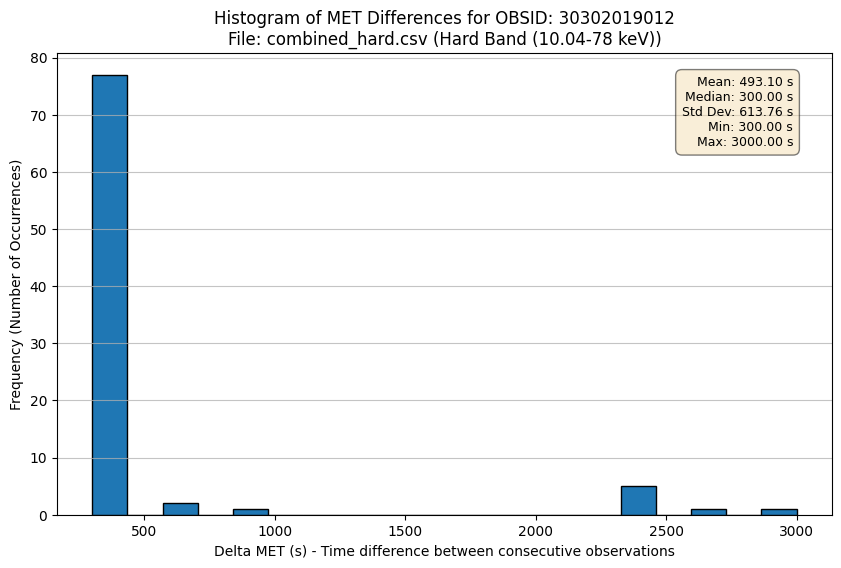

  Displayed histogram for OBSID 30302019012 from combined_hard.csv.


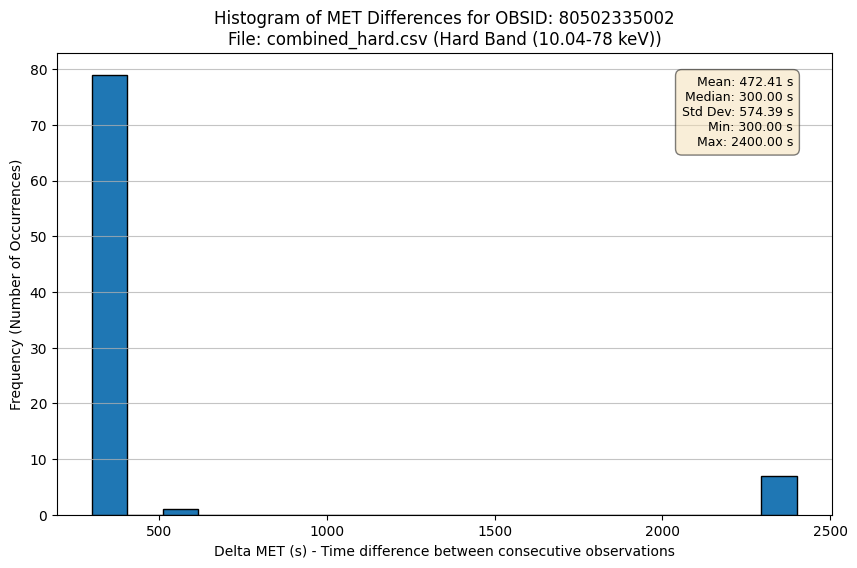

  Displayed histogram for OBSID 80502335002 from combined_hard.csv.


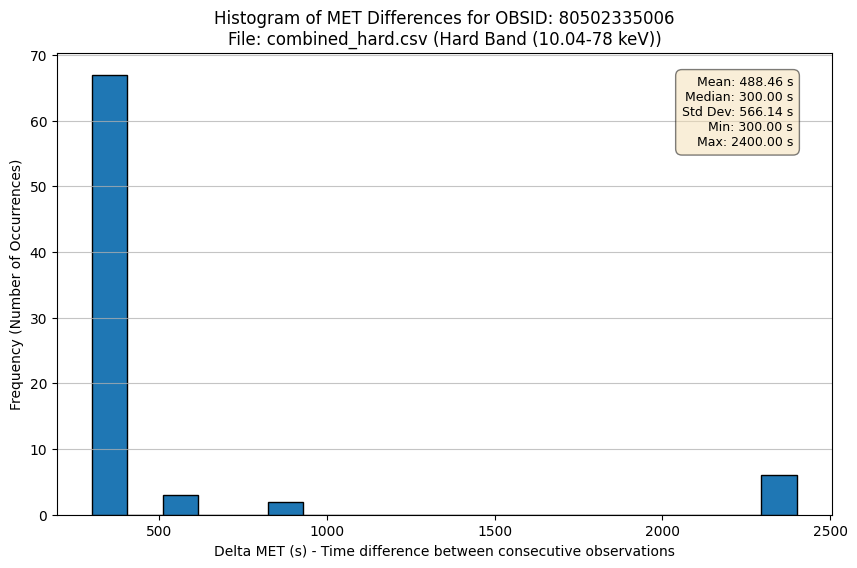

  Displayed histogram for OBSID 80502335006 from combined_hard.csv.


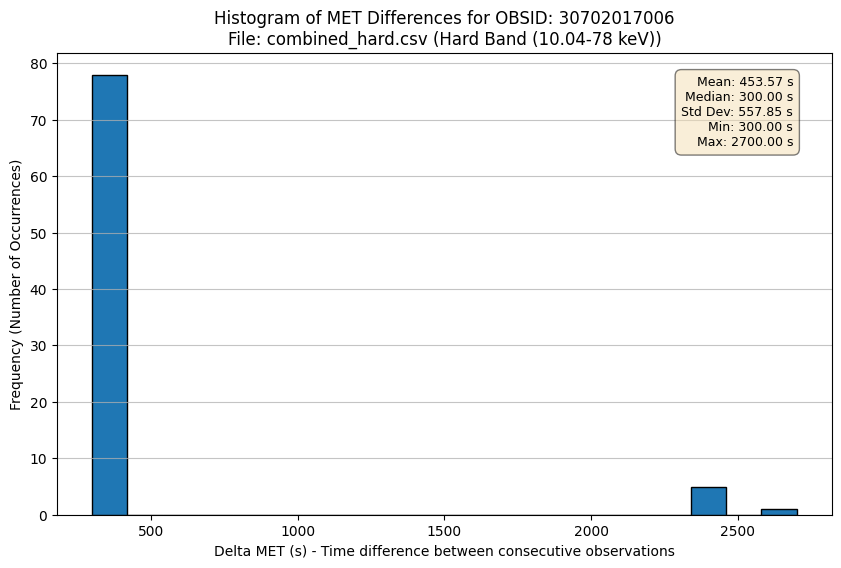

  Displayed histogram for OBSID 30702017006 from combined_hard.csv.


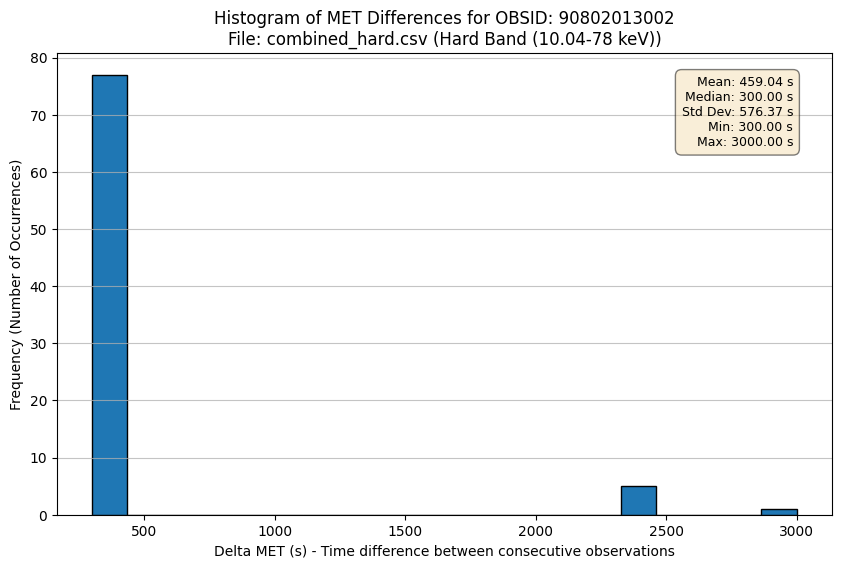

  Displayed histogram for OBSID 90802013002 from combined_hard.csv.


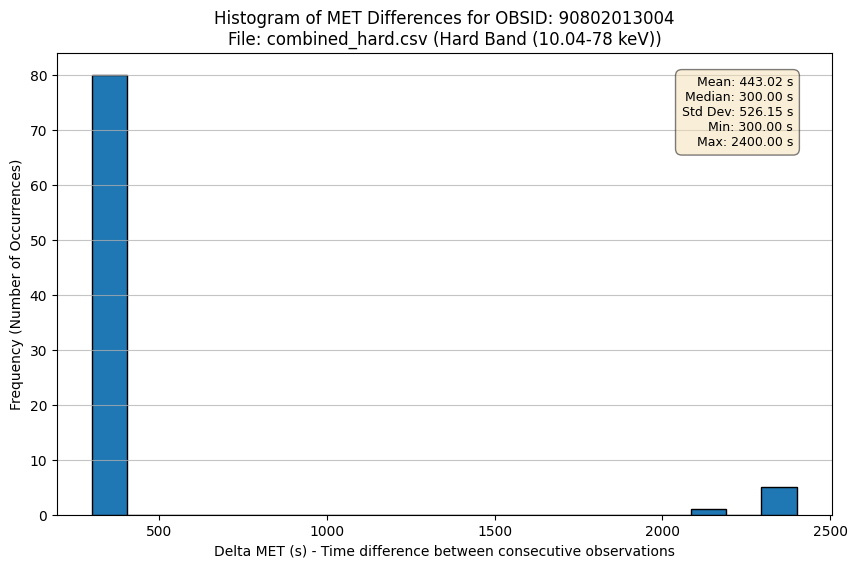

  Displayed histogram for OBSID 90802013004 from combined_hard.csv.


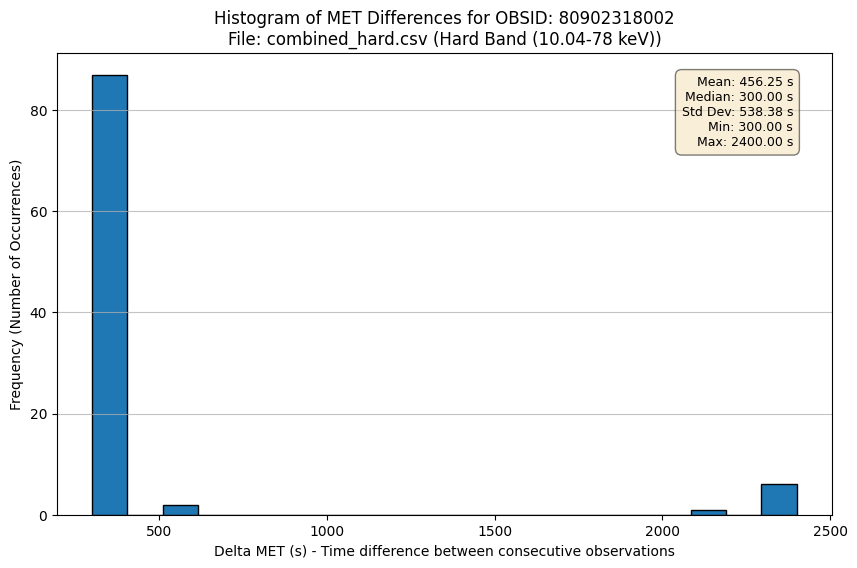

  Displayed histogram for OBSID 80902318002 from combined_hard.csv.


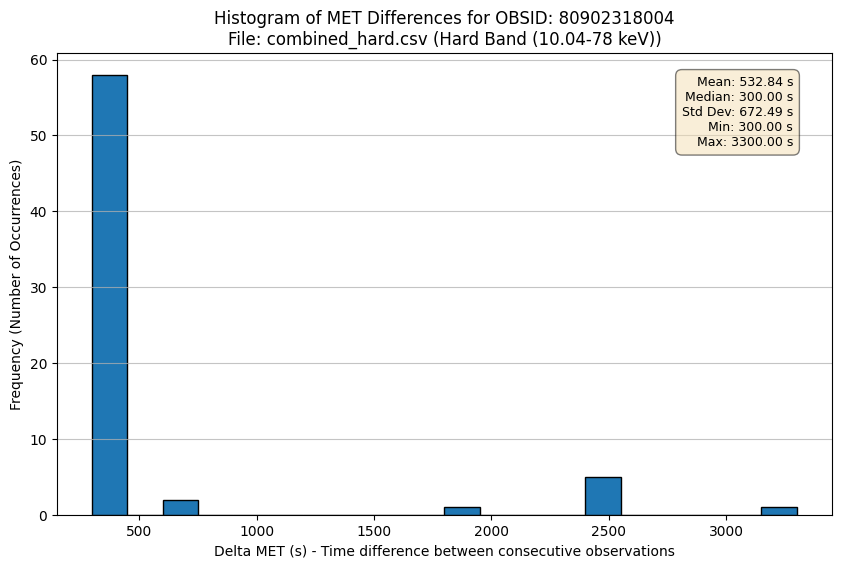

  Displayed histogram for OBSID 80902318004 from combined_hard.csv.


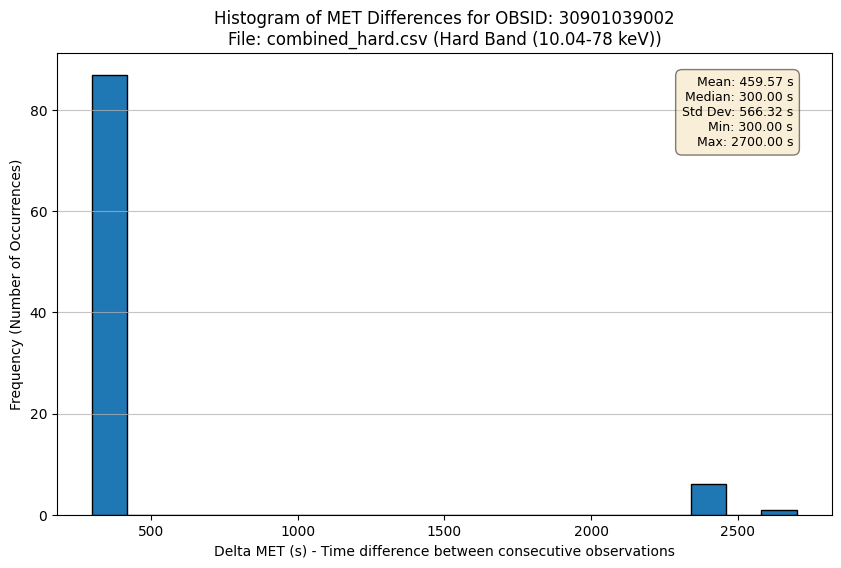

  Displayed histogram for OBSID 30901039002 from combined_hard.csv.


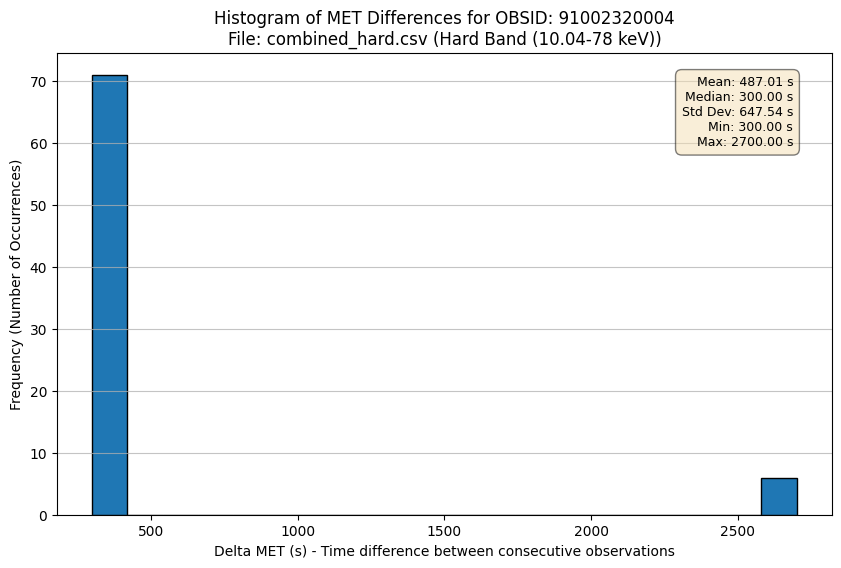

  Displayed histogram for OBSID 91002320004 from combined_hard.csv.
--- Processing file: combined_soft.csv (Soft Band (3-10 keV)) ---

Found 26 unique OBSIDs in combined_soft.csv.


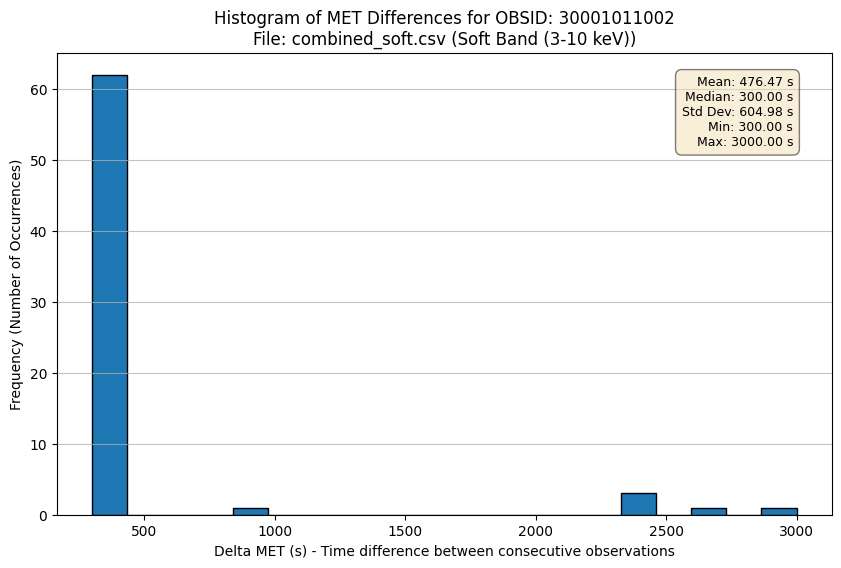

  Displayed histogram for OBSID 30001011002 from combined_soft.csv.


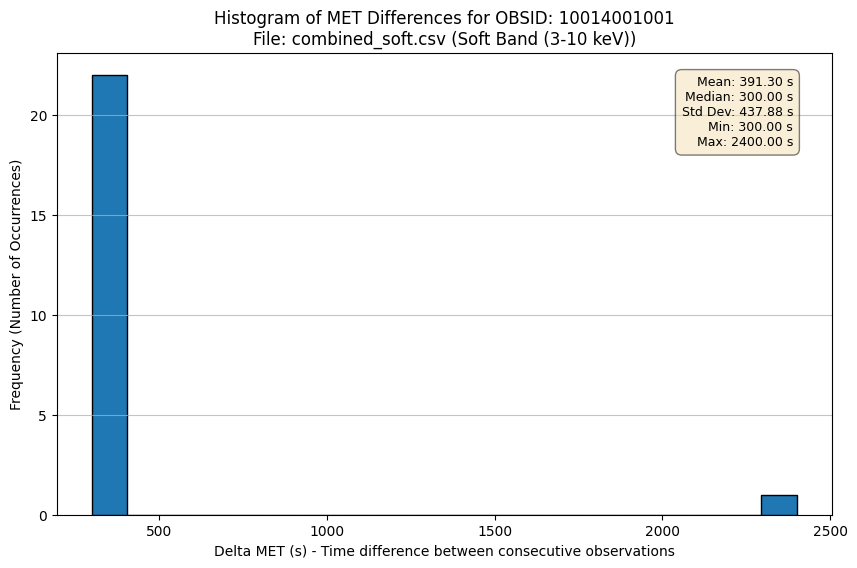

  Displayed histogram for OBSID 10014001001 from combined_soft.csv.


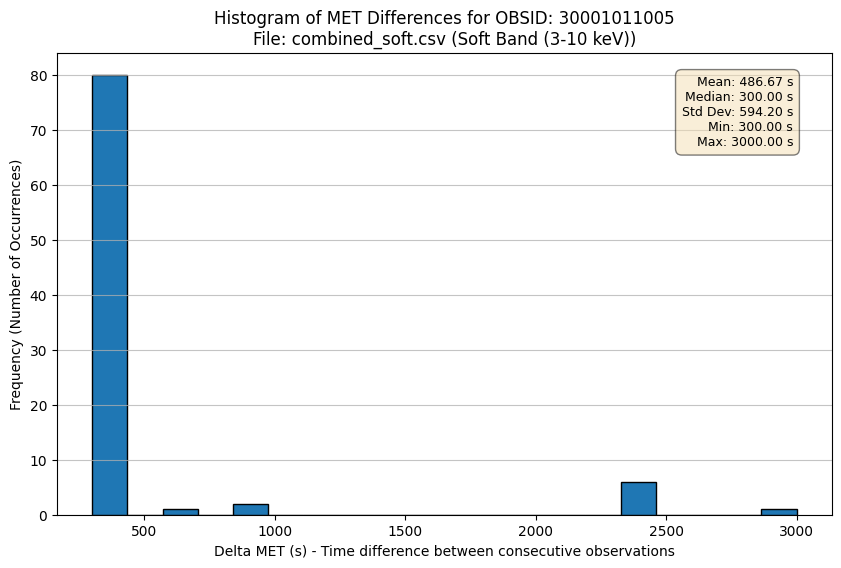

  Displayed histogram for OBSID 30001011005 from combined_soft.csv.


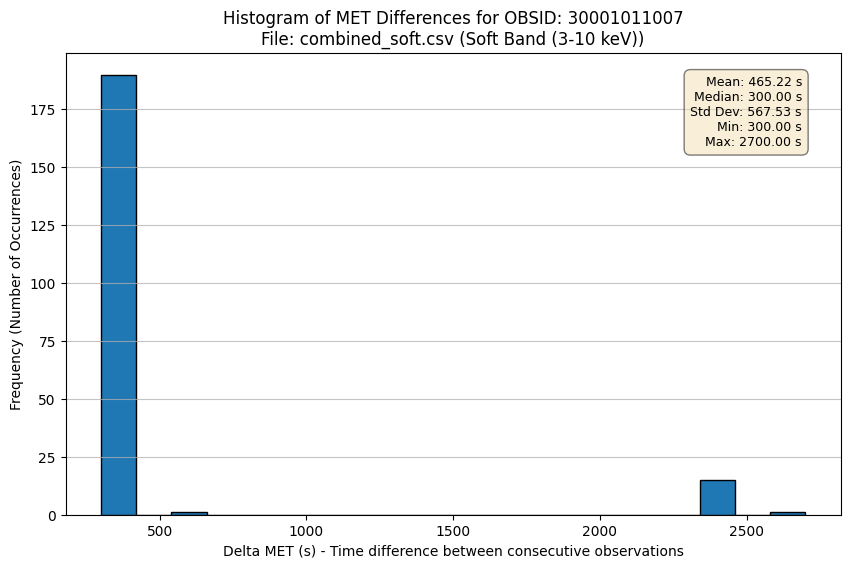

  Displayed histogram for OBSID 30001011007 from combined_soft.csv.


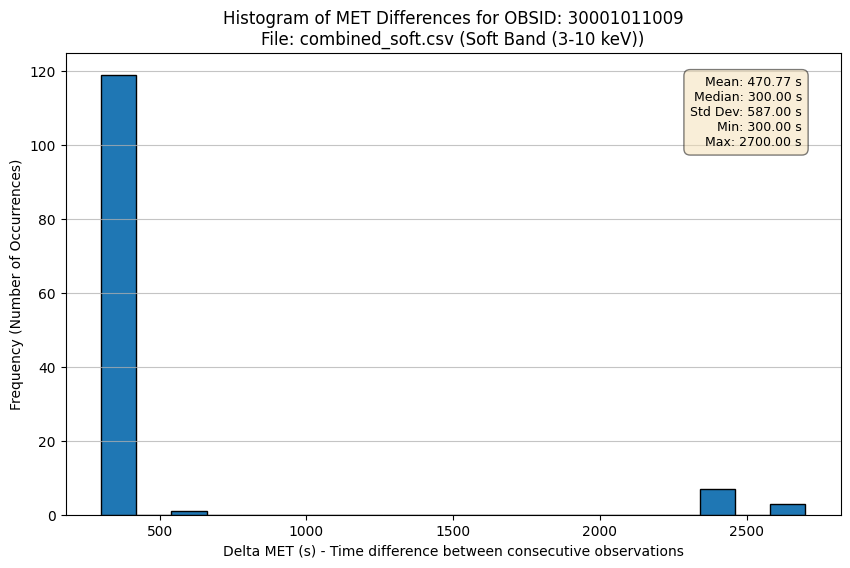

  Displayed histogram for OBSID 30001011009 from combined_soft.csv.


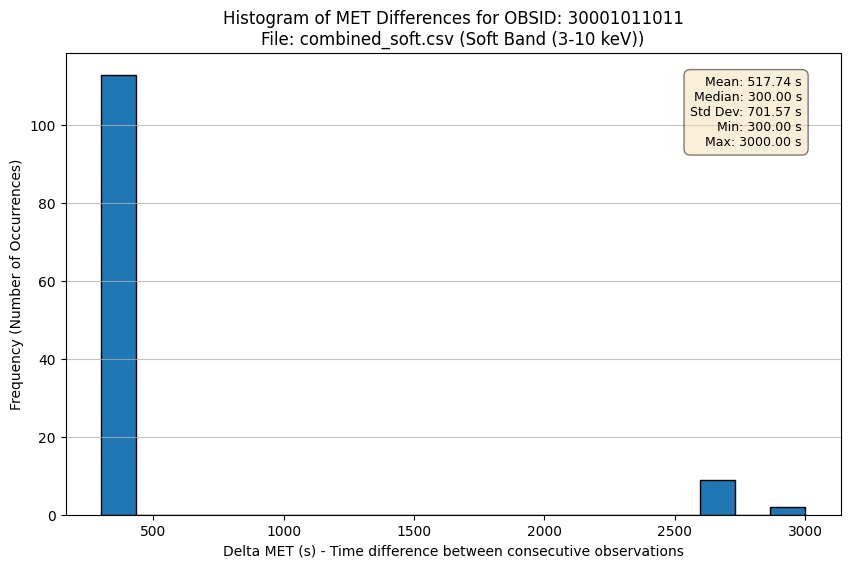

  Displayed histogram for OBSID 30001011011 from combined_soft.csv.


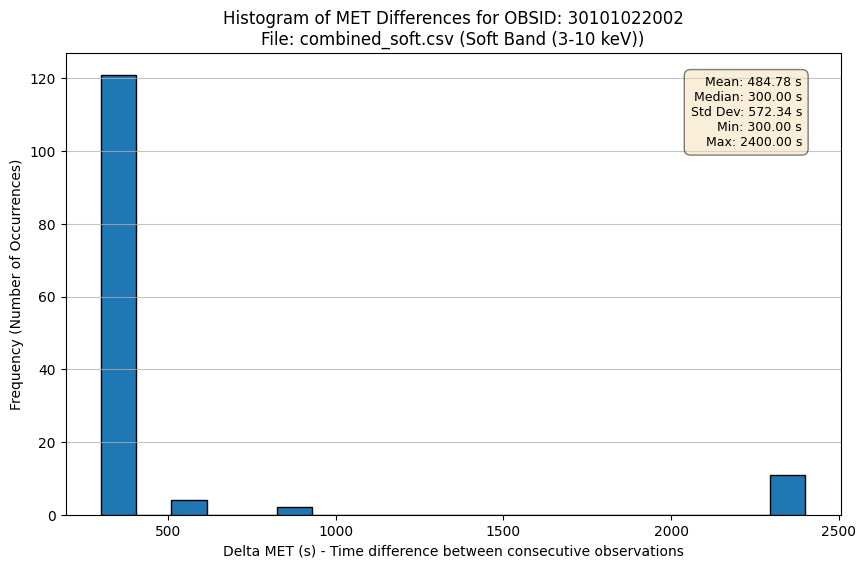

  Displayed histogram for OBSID 30101022002 from combined_soft.csv.


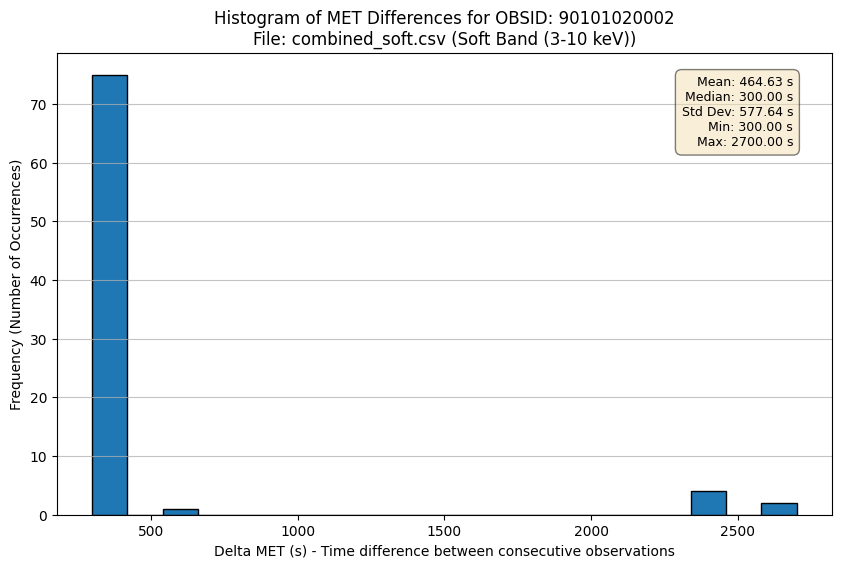

  Displayed histogram for OBSID 90101020002 from combined_soft.csv.


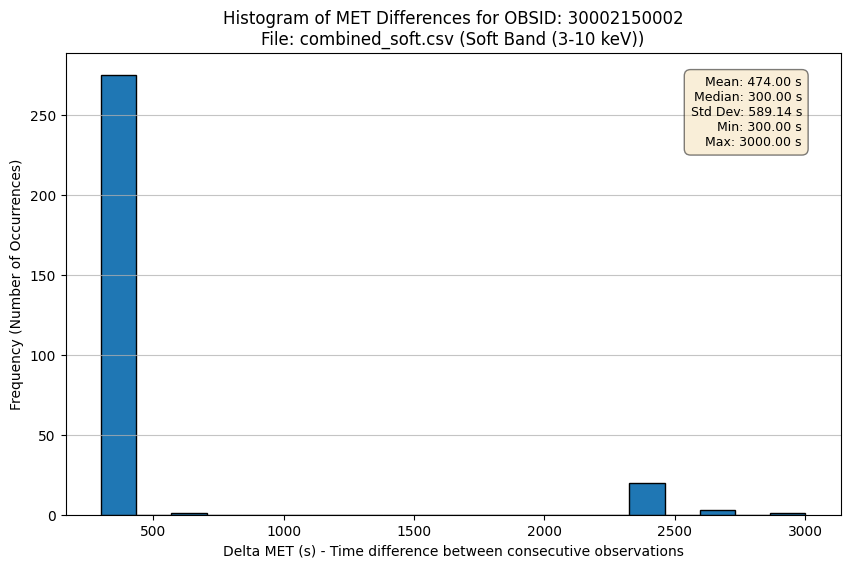

  Displayed histogram for OBSID 30002150002 from combined_soft.csv.


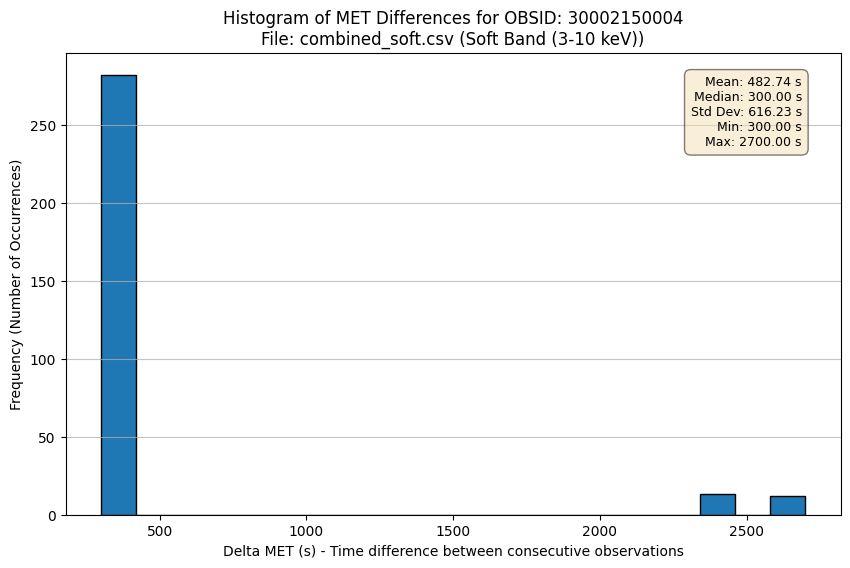

  Displayed histogram for OBSID 30002150004 from combined_soft.csv.


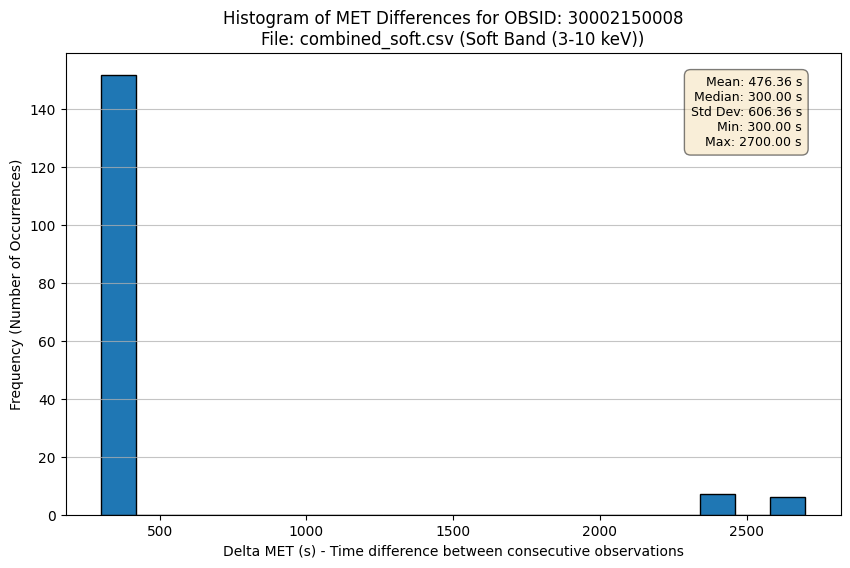

  Displayed histogram for OBSID 30002150008 from combined_soft.csv.


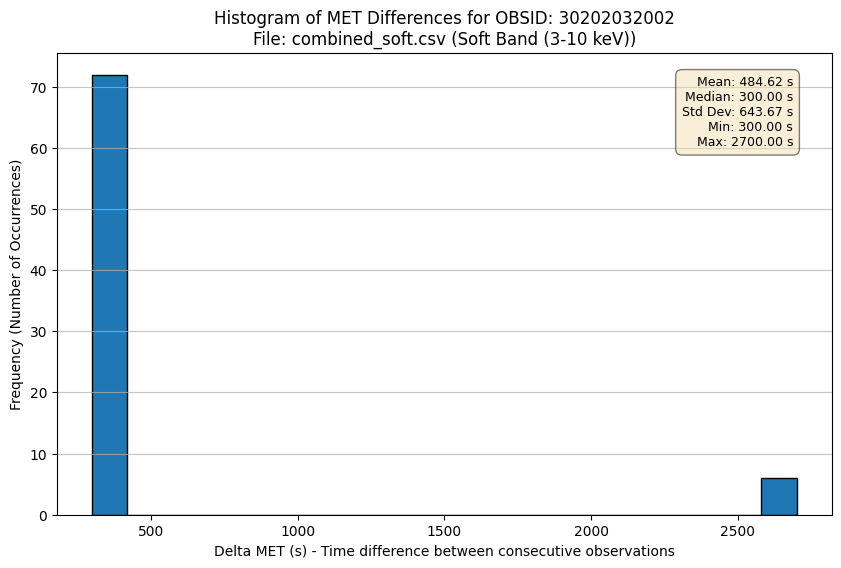

  Displayed histogram for OBSID 30202032002 from combined_soft.csv.


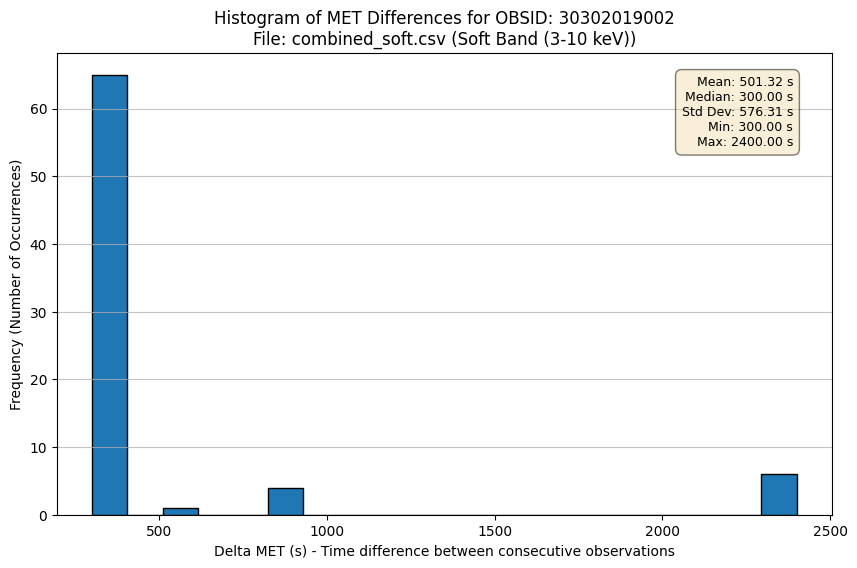

  Displayed histogram for OBSID 30302019002 from combined_soft.csv.


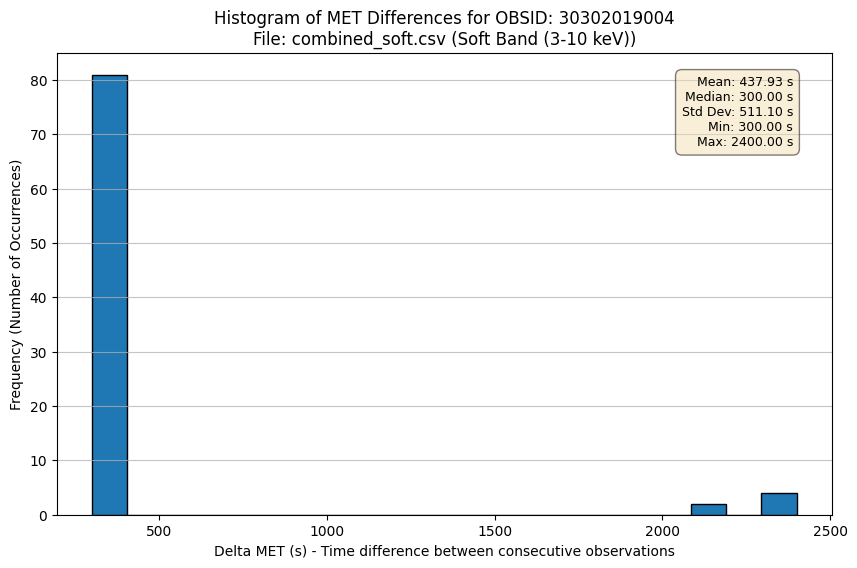

  Displayed histogram for OBSID 30302019004 from combined_soft.csv.


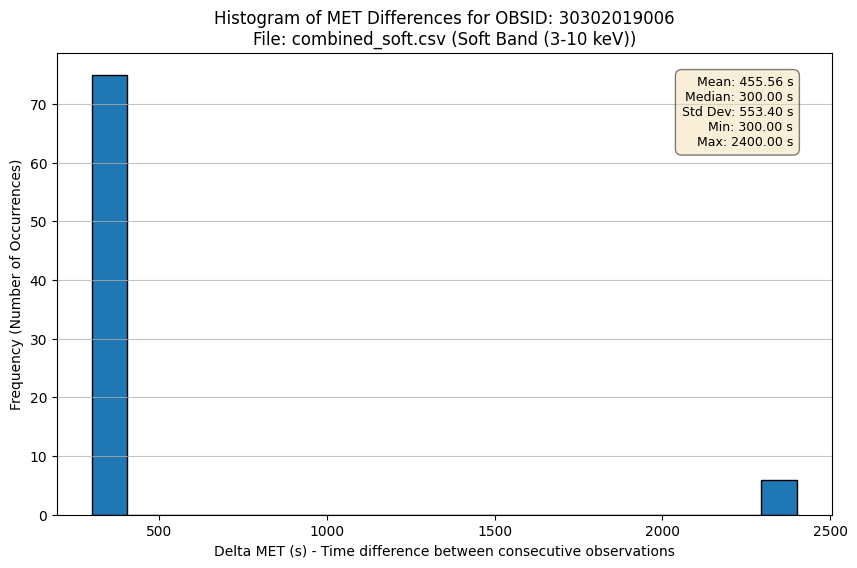

  Displayed histogram for OBSID 30302019006 from combined_soft.csv.


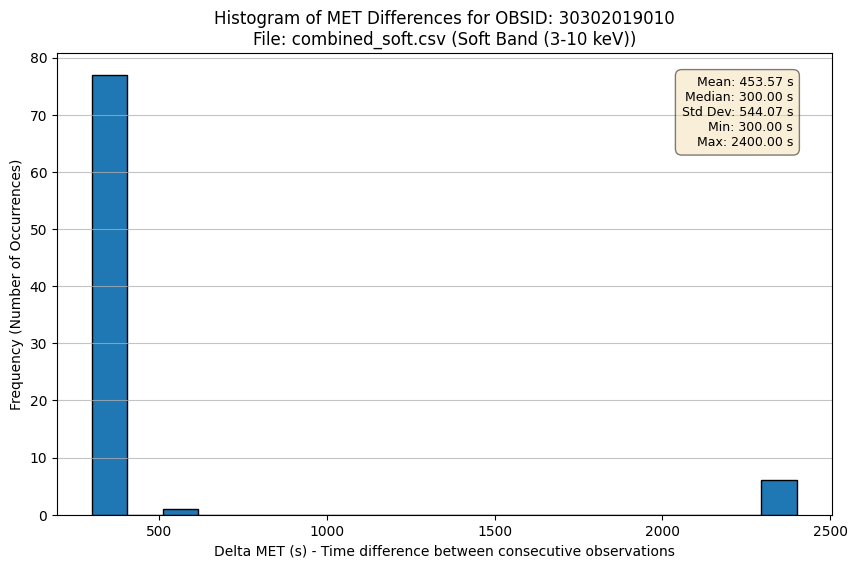

  Displayed histogram for OBSID 30302019010 from combined_soft.csv.


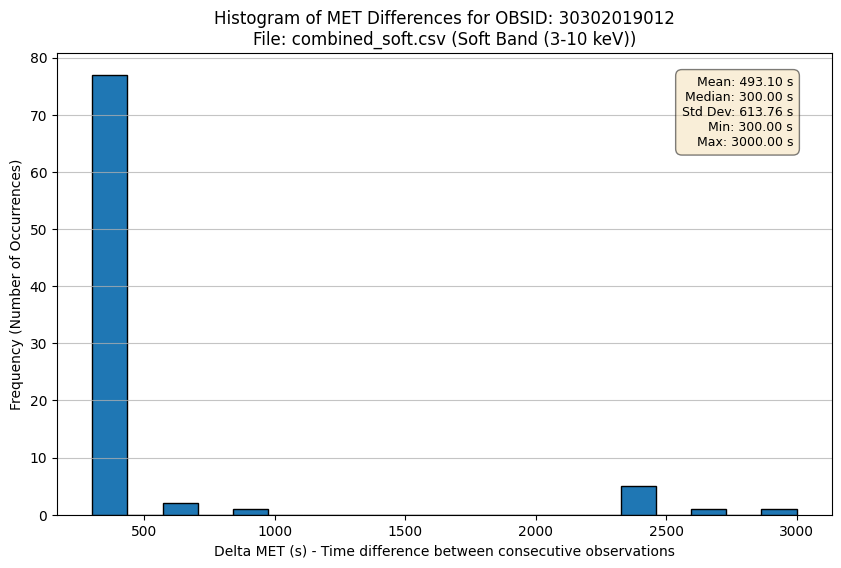

  Displayed histogram for OBSID 30302019012 from combined_soft.csv.


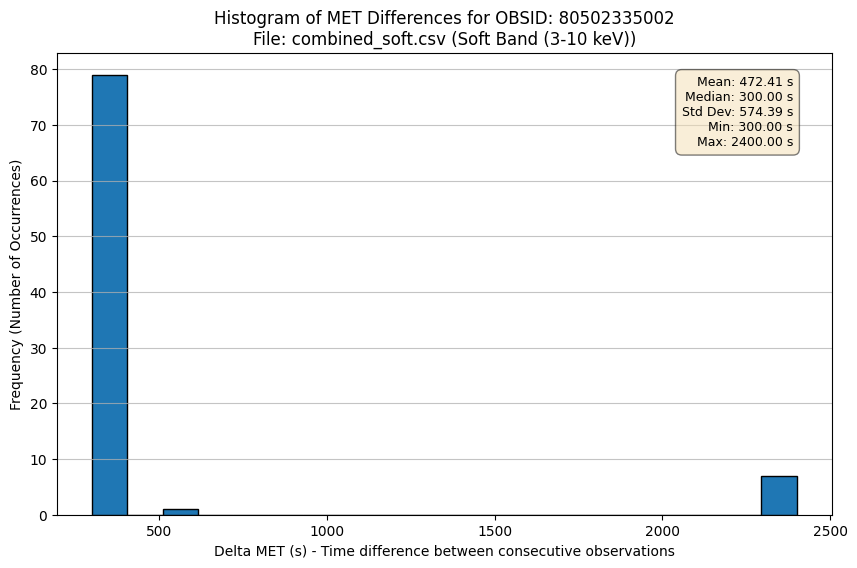

  Displayed histogram for OBSID 80502335002 from combined_soft.csv.


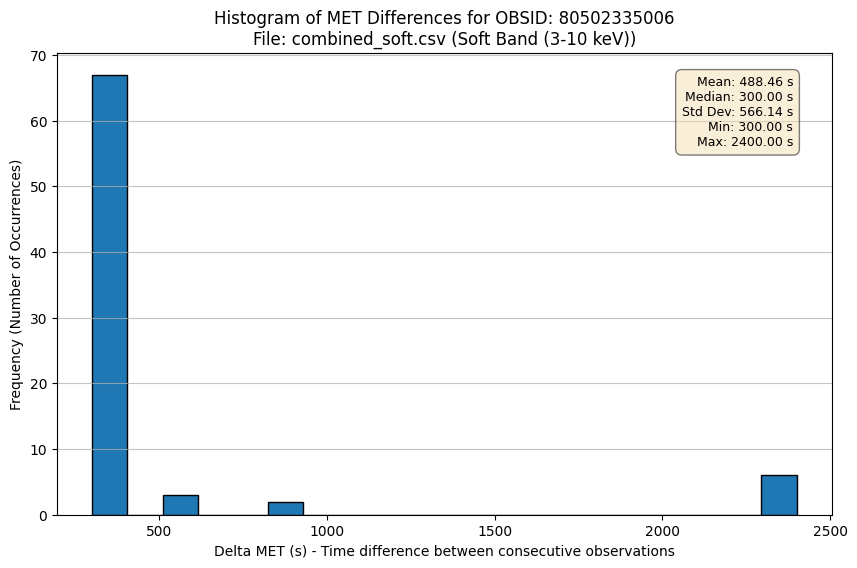

  Displayed histogram for OBSID 80502335006 from combined_soft.csv.


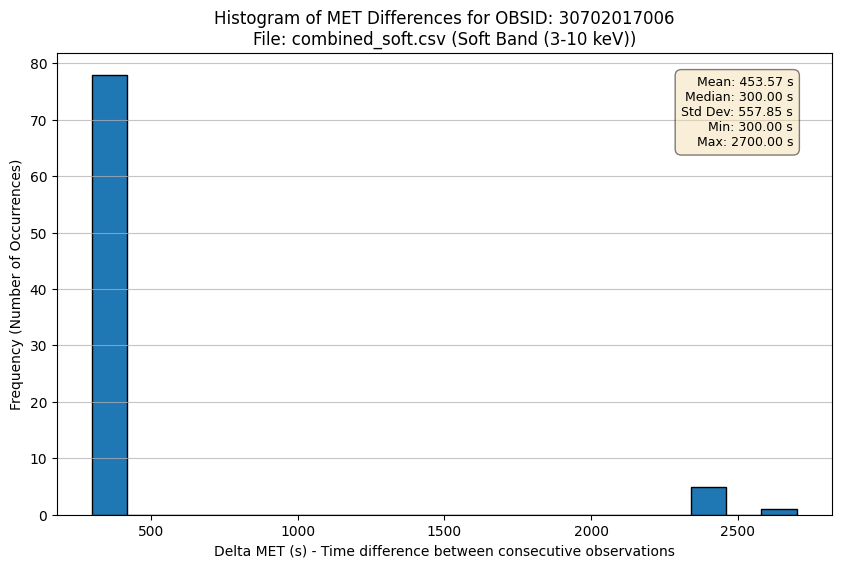

  Displayed histogram for OBSID 30702017006 from combined_soft.csv.


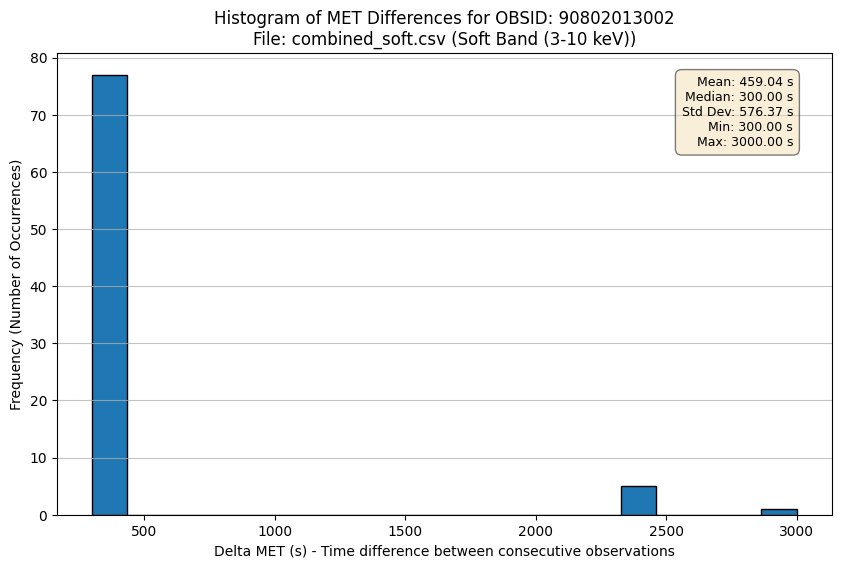

  Displayed histogram for OBSID 90802013002 from combined_soft.csv.


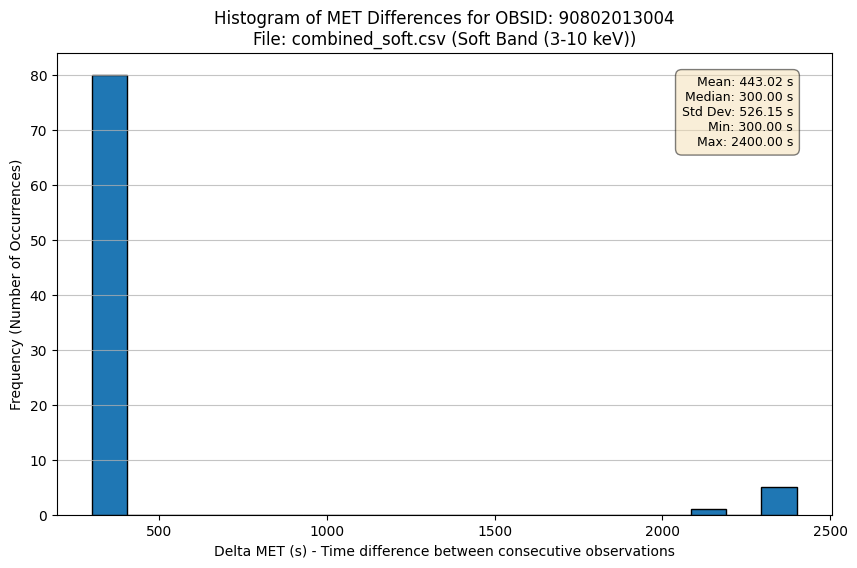

  Displayed histogram for OBSID 90802013004 from combined_soft.csv.


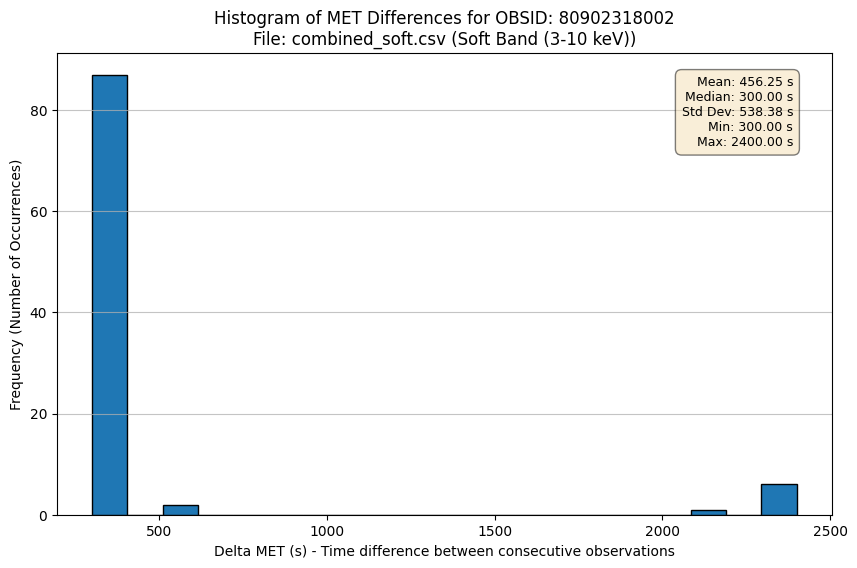

  Displayed histogram for OBSID 80902318002 from combined_soft.csv.


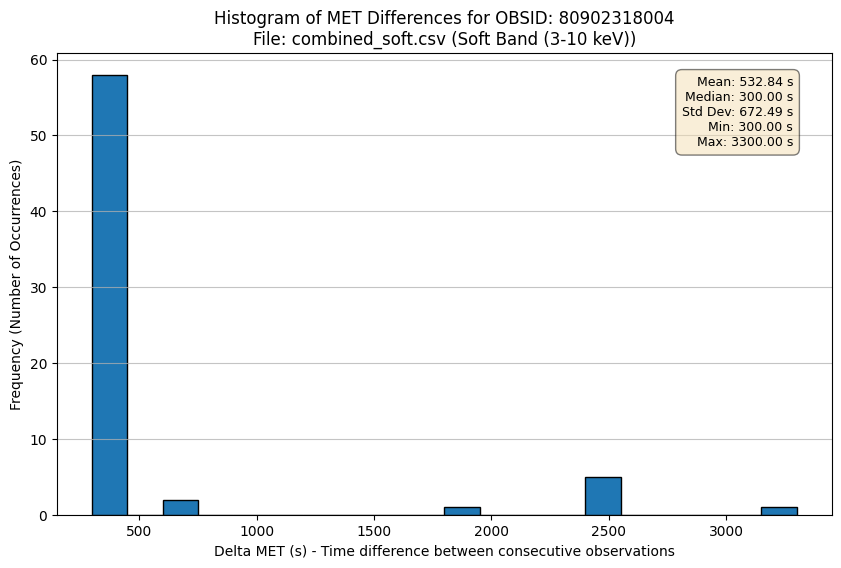

  Displayed histogram for OBSID 80902318004 from combined_soft.csv.


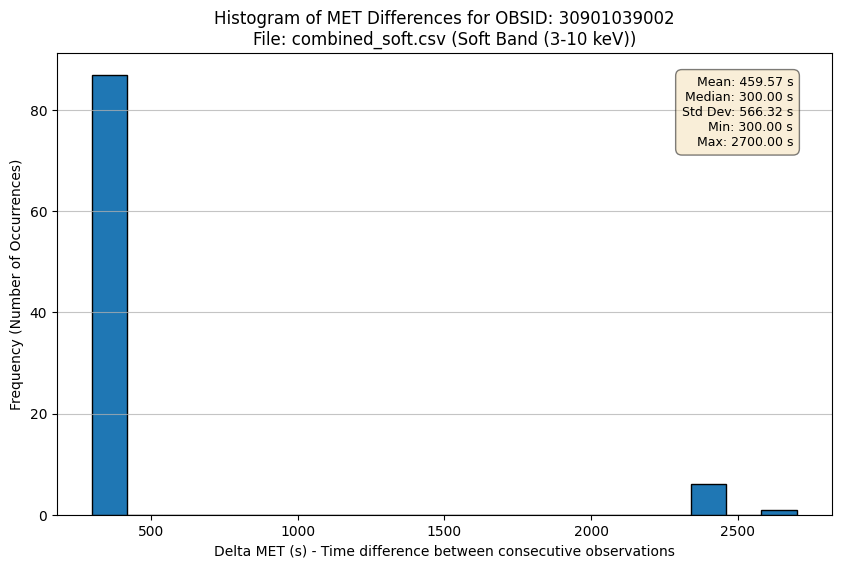

  Displayed histogram for OBSID 30901039002 from combined_soft.csv.


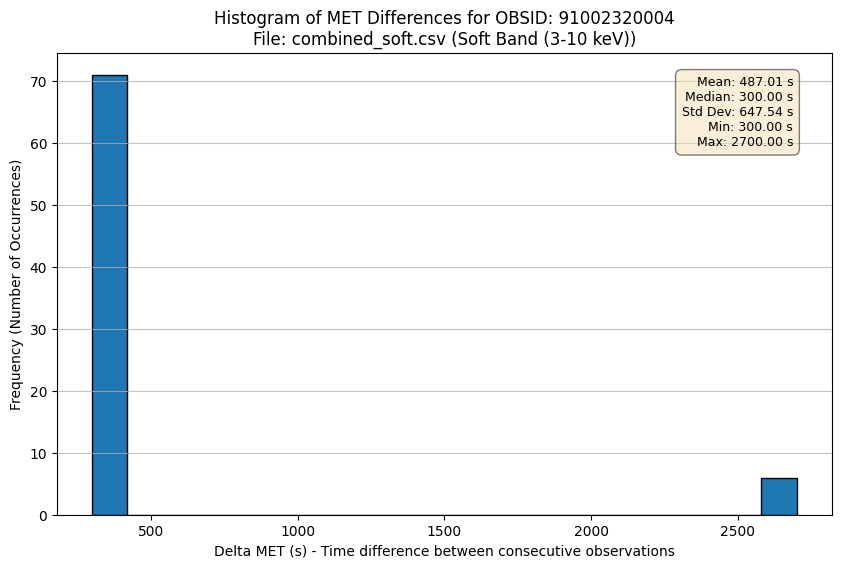

  Displayed histogram for OBSID 91002320004 from combined_soft.csv.
--- Processing file: combined_full.csv (Full Band (3-78 keV)) ---

Found 26 unique OBSIDs in combined_full.csv.


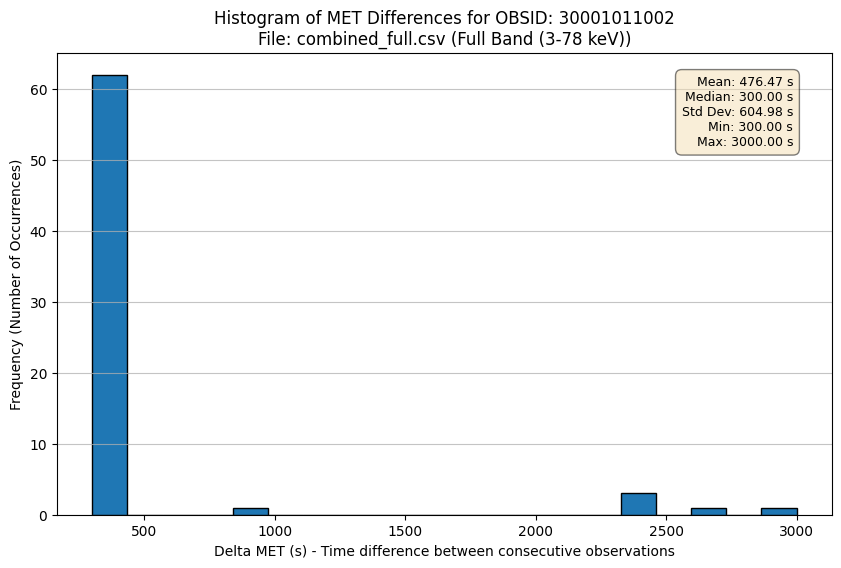

  Displayed histogram for OBSID 30001011002 from combined_full.csv.


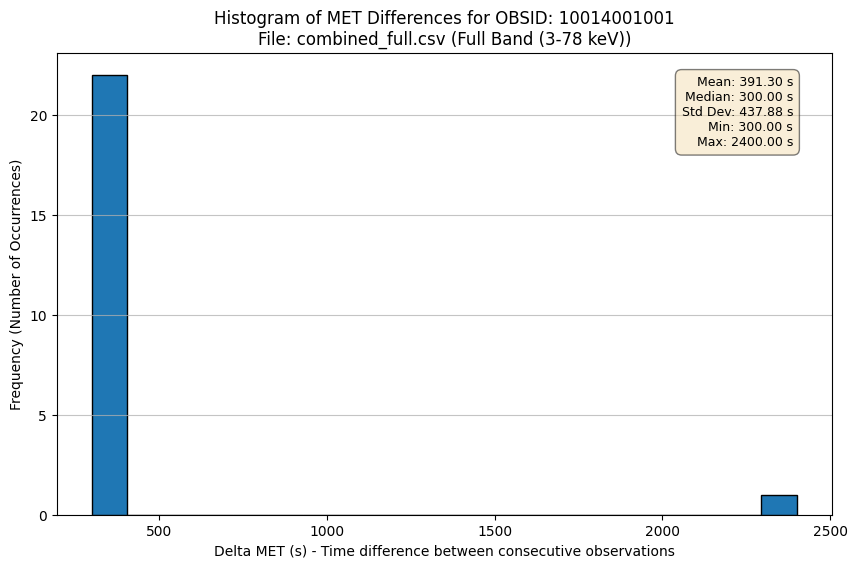

  Displayed histogram for OBSID 10014001001 from combined_full.csv.


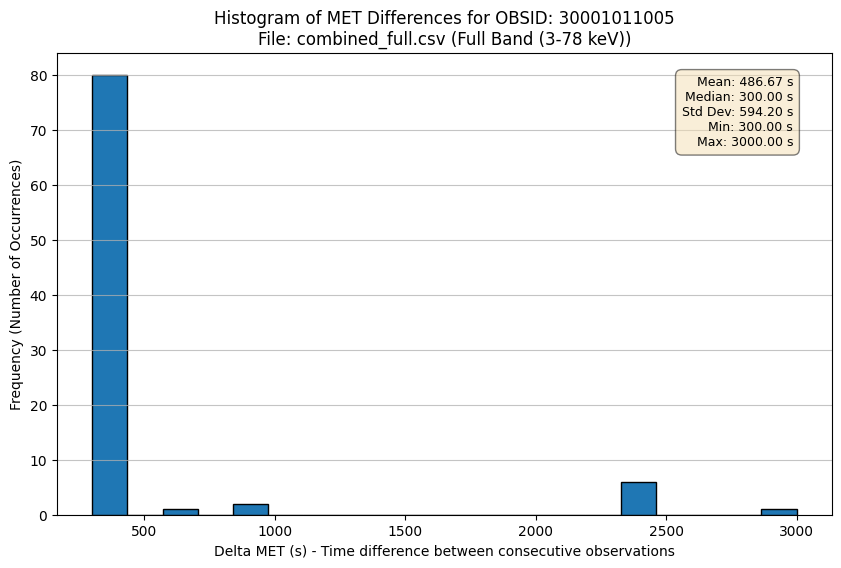

  Displayed histogram for OBSID 30001011005 from combined_full.csv.


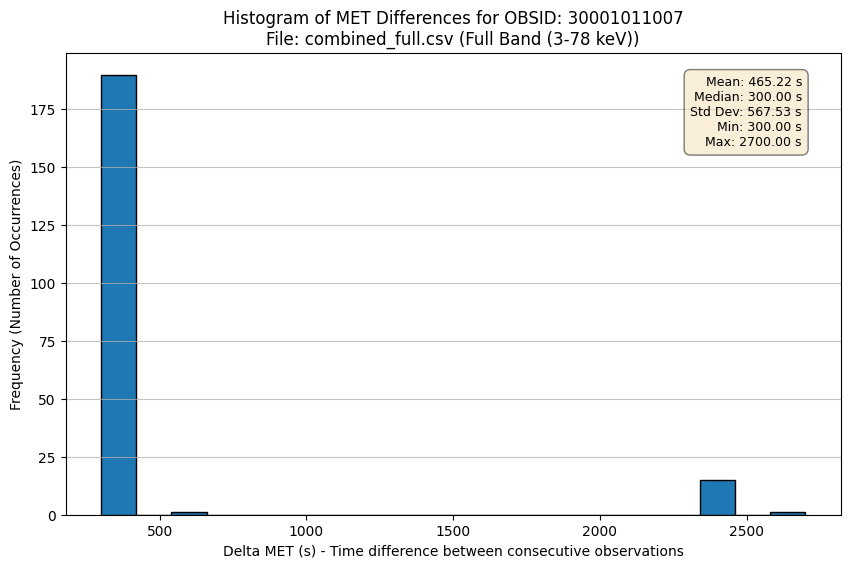

  Displayed histogram for OBSID 30001011007 from combined_full.csv.


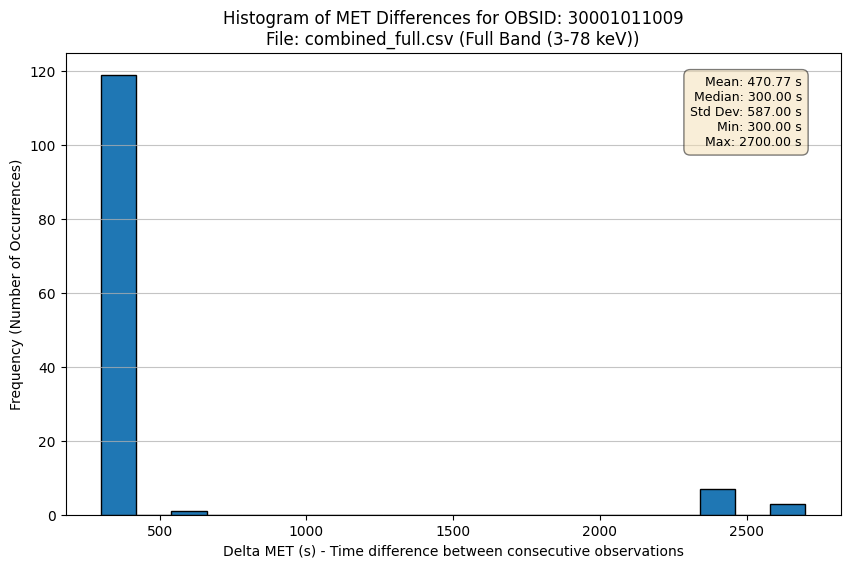

  Displayed histogram for OBSID 30001011009 from combined_full.csv.


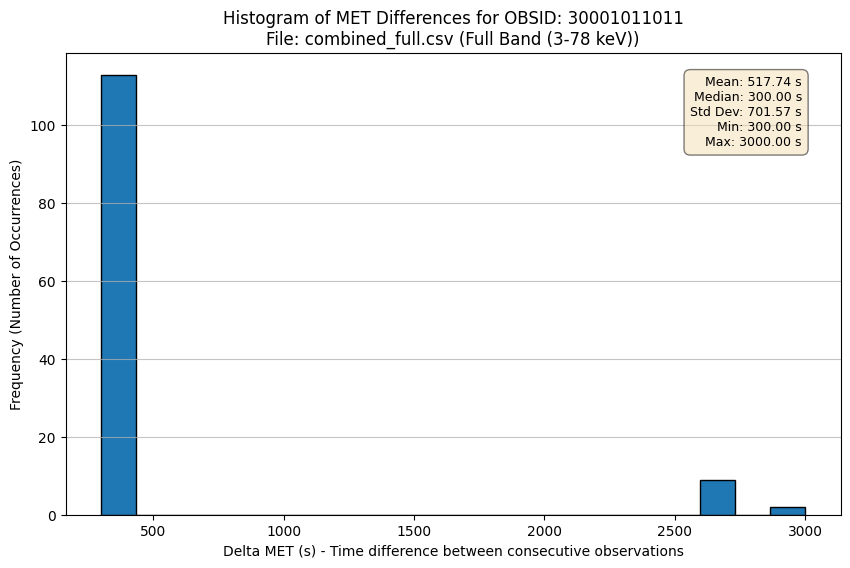

  Displayed histogram for OBSID 30001011011 from combined_full.csv.


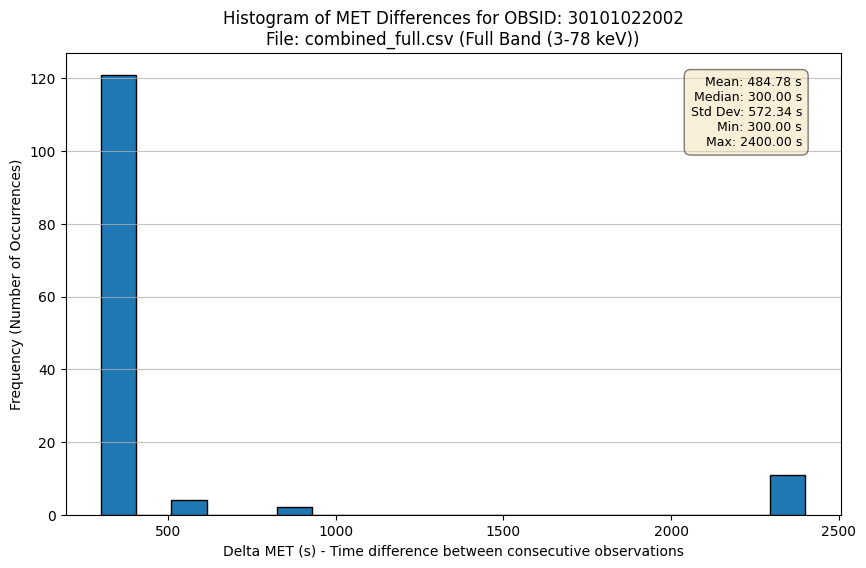

  Displayed histogram for OBSID 30101022002 from combined_full.csv.


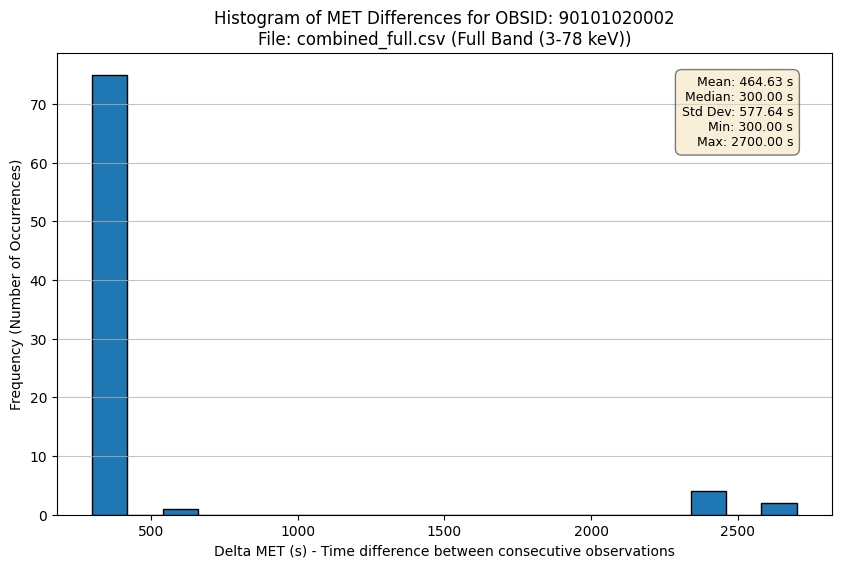

  Displayed histogram for OBSID 90101020002 from combined_full.csv.


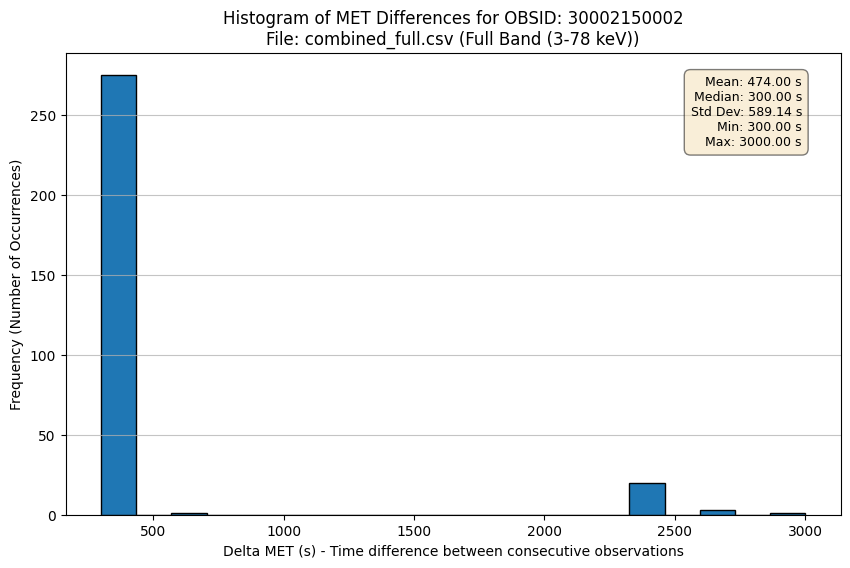

  Displayed histogram for OBSID 30002150002 from combined_full.csv.


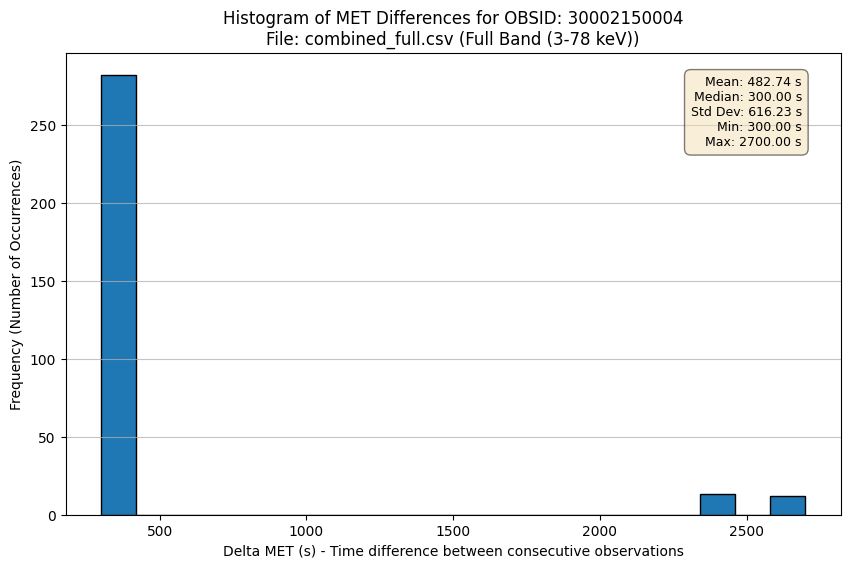

  Displayed histogram for OBSID 30002150004 from combined_full.csv.


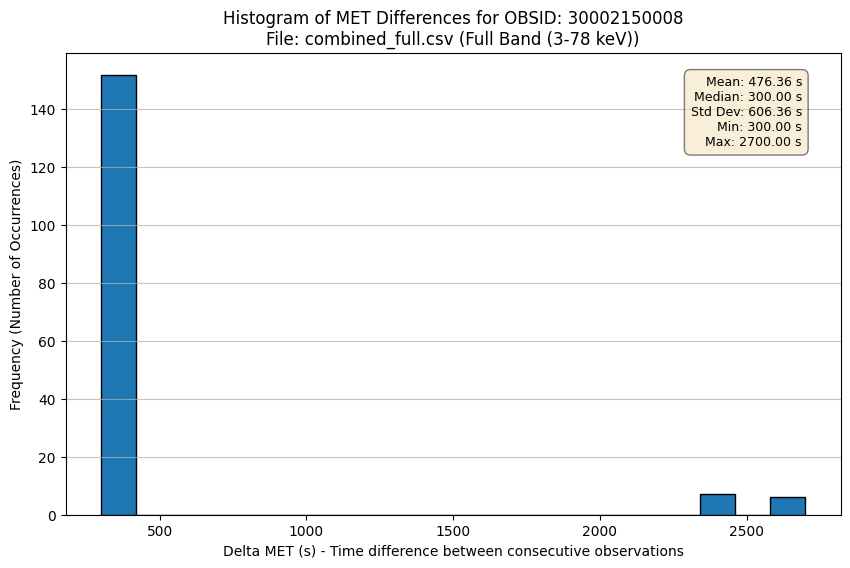

  Displayed histogram for OBSID 30002150008 from combined_full.csv.


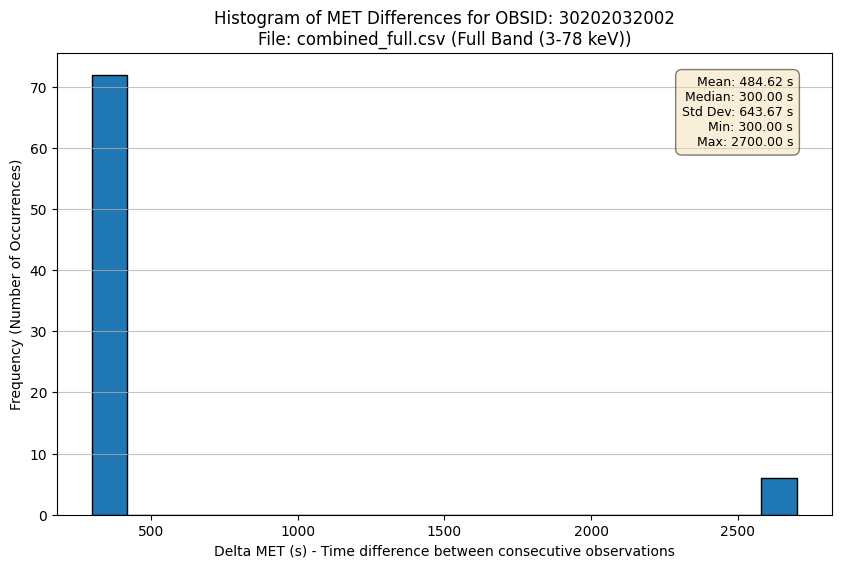

  Displayed histogram for OBSID 30202032002 from combined_full.csv.


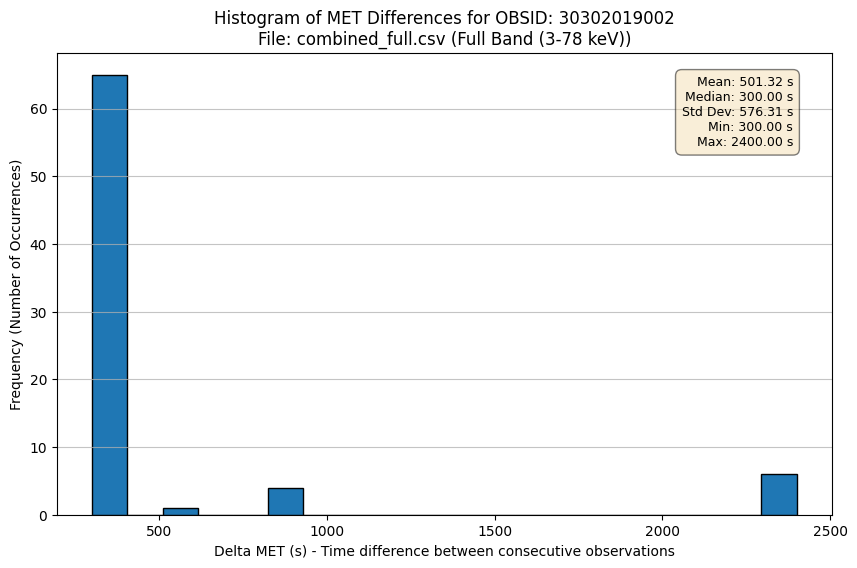

  Displayed histogram for OBSID 30302019002 from combined_full.csv.


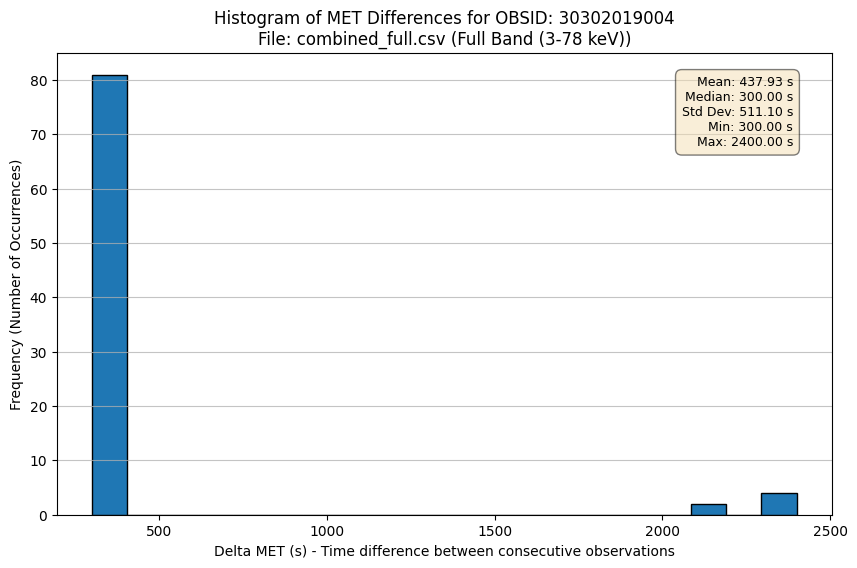

  Displayed histogram for OBSID 30302019004 from combined_full.csv.


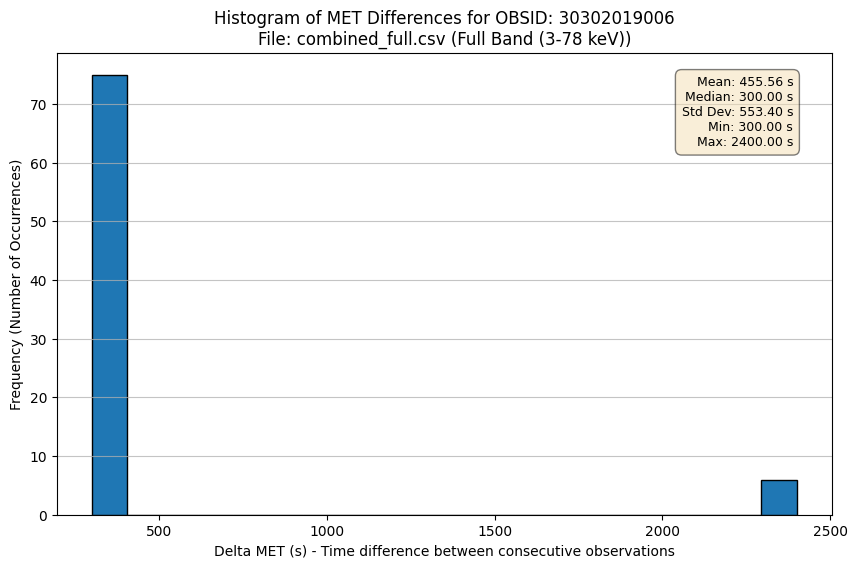

  Displayed histogram for OBSID 30302019006 from combined_full.csv.


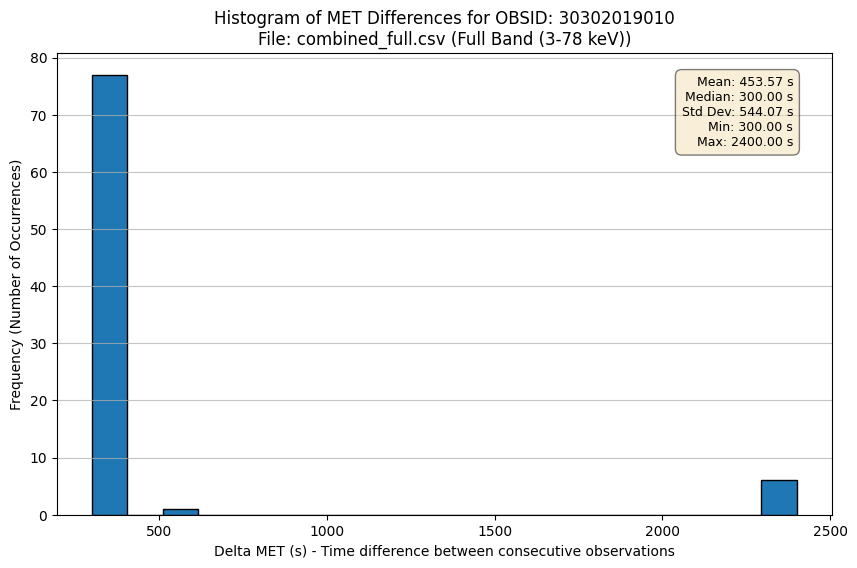

  Displayed histogram for OBSID 30302019010 from combined_full.csv.


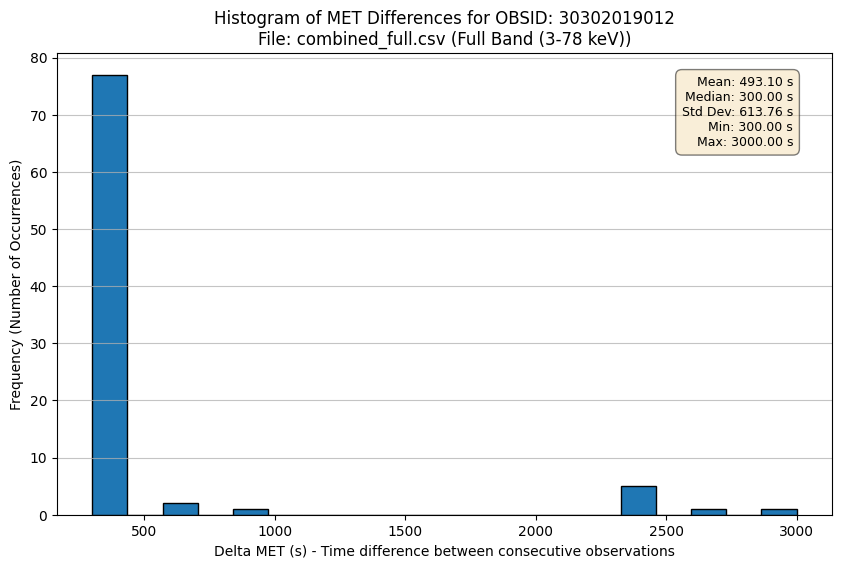

  Displayed histogram for OBSID 30302019012 from combined_full.csv.


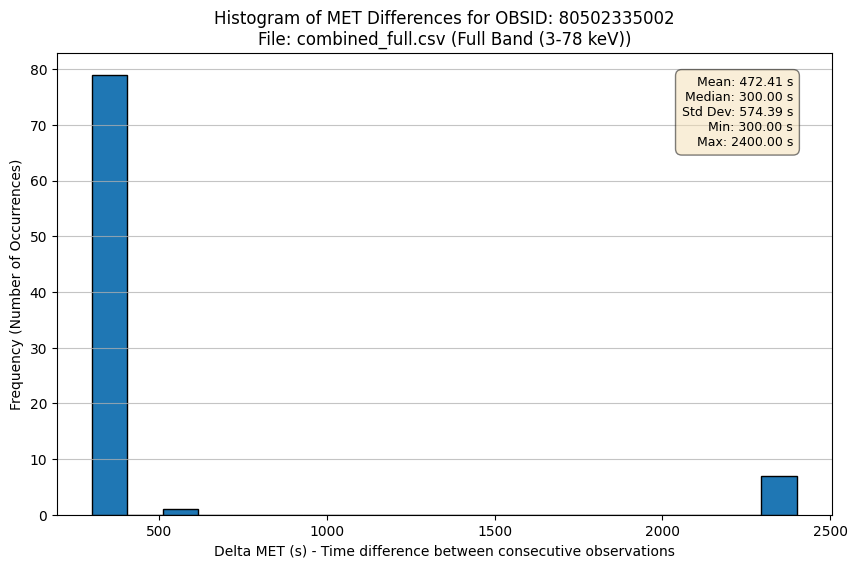

  Displayed histogram for OBSID 80502335002 from combined_full.csv.


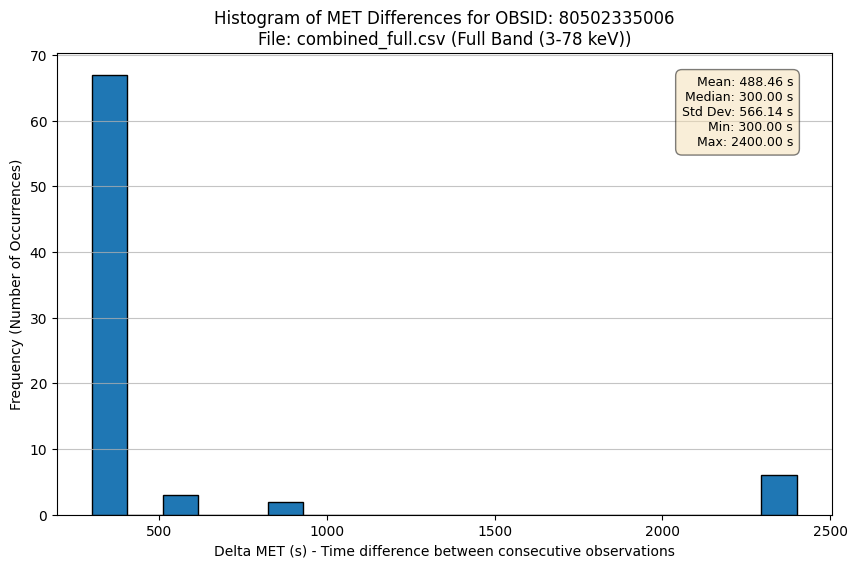

  Displayed histogram for OBSID 80502335006 from combined_full.csv.


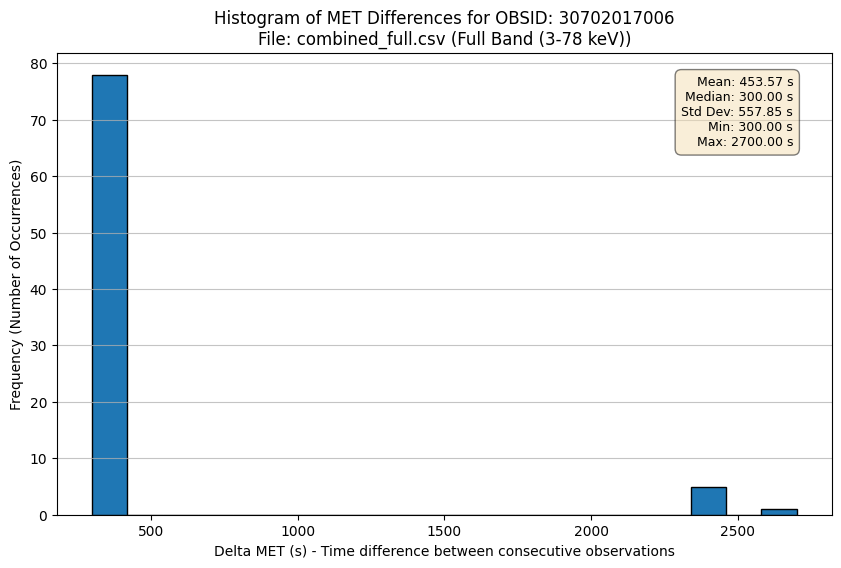

  Displayed histogram for OBSID 30702017006 from combined_full.csv.


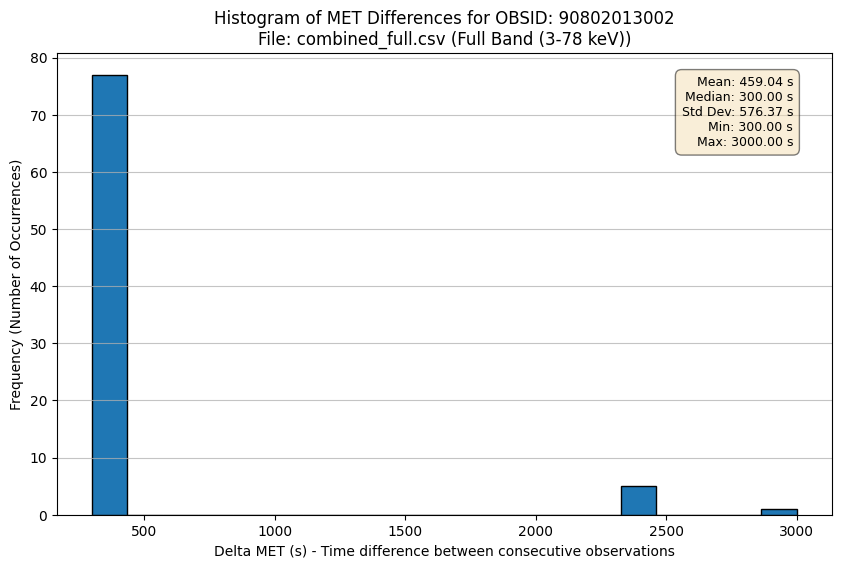

  Displayed histogram for OBSID 90802013002 from combined_full.csv.


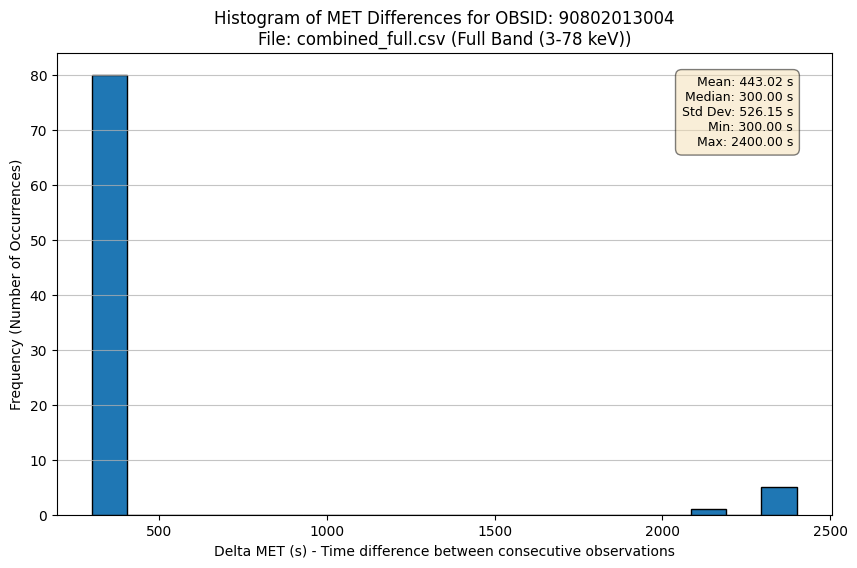

  Displayed histogram for OBSID 90802013004 from combined_full.csv.


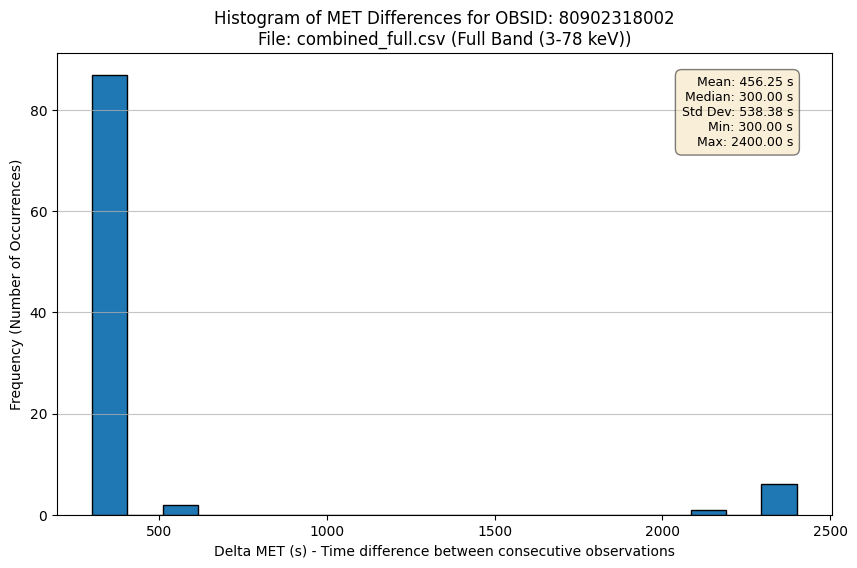

  Displayed histogram for OBSID 80902318002 from combined_full.csv.


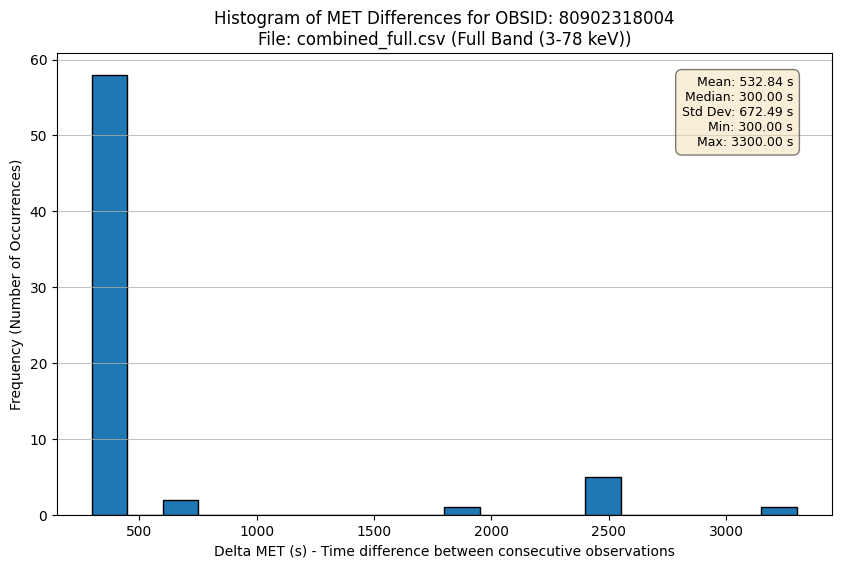

  Displayed histogram for OBSID 80902318004 from combined_full.csv.


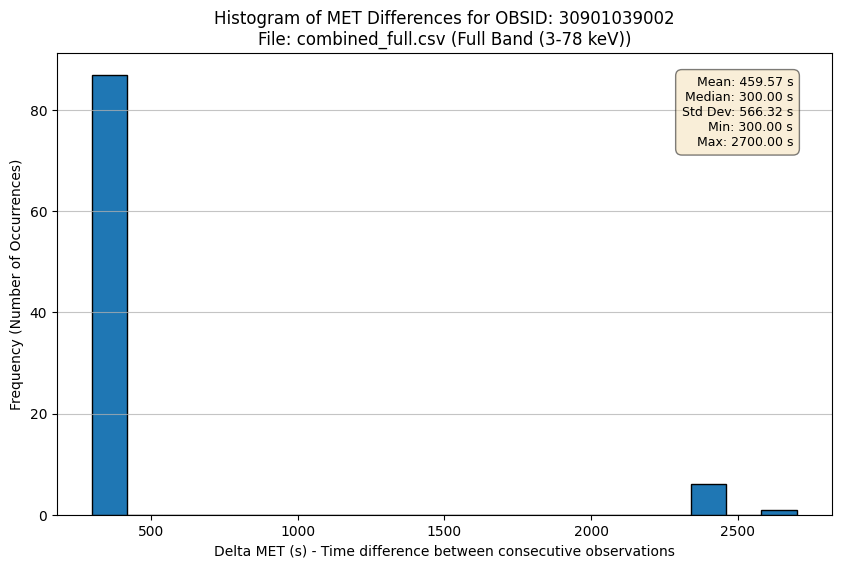

  Displayed histogram for OBSID 30901039002 from combined_full.csv.


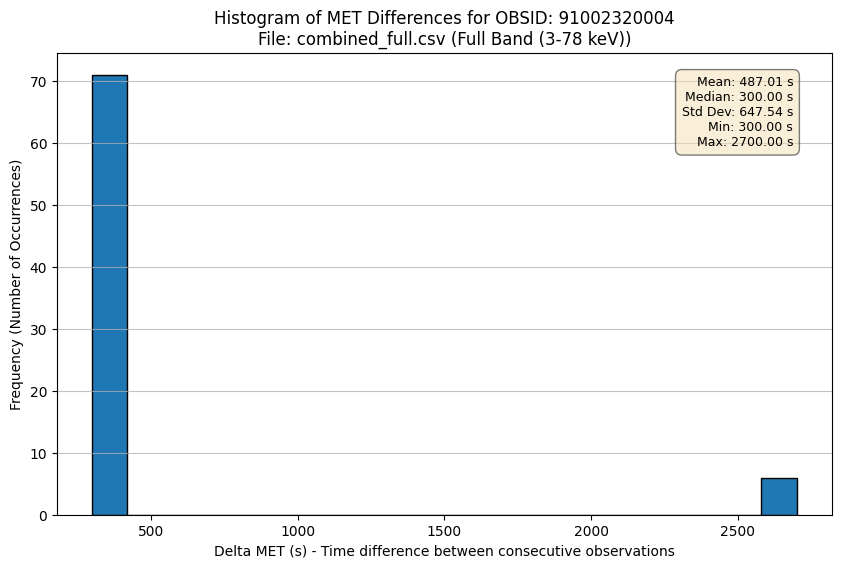

  Displayed histogram for OBSID 91002320004 from combined_full.csv.

--- Analysis Guidance ---
Review the generated histograms for each OBSID:
- A sharp peak (e.g., around 100s if that's the binning) indicates regular sampling for that observation.
- Multiple peaks, a broad distribution, or very large delta MET values indicate irregular sampling or significant data gaps.
This will help you choose appropriate time series analysis methods:
  - For regularly sampled data (consistent delta METs): Standard Fourier Transform (FFT) based methods are often suitable.
  - For irregularly sampled data: Consider methods like the Lomb-Scargle periodogram, which are designed for unevenly spaced time series.
The paper mentions (page 4) that light curves were extracted with a 'constant time bin of 100 s'. These histograms will help you verify this for each observation and identify any deviations or gaps.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_met_diff_histogram(df, file_name_full, energy_band_name):
    """
    Calculates and plots histograms of MET differences for each OBSID in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with 'MET' and 'OBSID' columns.
        file_name_full (str): The full name of the CSV file being processed (for plot titles).
        energy_band_name (str): The name of the energy band (for plot titles).
    """
    if 'OBSID' not in df.columns or 'MET' not in df.columns:
        print(f"Skipping {file_name_full}: Missing 'OBSID' or 'MET' column.")
        return

    # Ensure MET is numeric
    try:
        df['MET'] = pd.to_numeric(df['MET'])
    except ValueError:
        print(f"Skipping {file_name_full}: 'MET' column contains non-numeric values that could not be converted.")
        return

    obsids = df['OBSID'].unique()
    print(f"\nFound {len(obsids)} unique OBSIDs in {file_name_full}.")

    for obsid in obsids:
        # Filter data for the current OBSID
        obs_data = df[df['OBSID'] == obsid].copy() # Use .copy() to avoid SettingWithCopyWarning

        # Sort by MET to ensure correct difference calculation
        obs_data.sort_values('MET', inplace=True)

        if len(obs_data) < 2:
            print(f"OBSID {obsid} in {file_name_full} has fewer than 2 data points. Cannot calculate MET differences.")
            continue

        # Calculate the difference between consecutive MET values
        met_diffs = obs_data['MET'].diff().dropna() # dropna() removes the first NaN value

        if met_diffs.empty:
            print(f"OBSID {obsid} in {file_name_full} resulted in no MET differences (e.g., only one unique MET value after diff).")
            continue

        # Plotting the histogram
        plt.figure(figsize=(10, 6))
        # Determine a reasonable number of bins
        num_bins = 20#'auto'
        #if len(met_diffs.unique()) < 20 : # If few unique diffs, make bins discrete
        #     num_bins = len(met_diffs.unique())

        plt.hist(met_diffs, bins=num_bins, edgecolor='black')

        plt.title(f'Histogram of MET Differences for OBSID: {obsid}\nFile: {file_name_full} ({energy_band_name})')
        plt.xlabel('Delta MET (s) - Time difference between consecutive observations')
        plt.ylabel('Frequency (Number of Occurrences)')
        plt.grid(axis='y', alpha=0.75)

        # Add some statistics to the plot
        mean_diff = met_diffs.mean()
        median_diff = met_diffs.median()
        std_diff = met_diffs.std()
        min_val = met_diffs.min()
        max_val = met_diffs.max()

        stats_text = (f'Mean: {mean_diff:.2f} s\nMedian: {median_diff:.2f} s\nStd Dev: {std_diff:.2f} s\n'
                      f'Min: {min_val:.2f} s\nMax: {max_val:.2f} s')
        # Place text box in upper right in axes coords
        plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=9,
                 verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

        plt.show()
        print(f"  Displayed histogram for OBSID {obsid} from {file_name_full}.")


# --- INSTRUCTIONS ---
# 1. Save this code as a Python file (e.g., plot_met_diffs.py) in the SAME DIRECTORY
#    as your CSV files: 'combined_hard.csv', 'combined_soft.csv', 'combined_full.csv'.
# 2. If your files are in a different directory, you will need to modify the
#    file_paths list below to include the full path to each file.
# 3. Run the script from your terminal: python plot_met_diffs.py

file_paths = ['combined_hard.csv', 'combined_soft.csv', 'combined_full.csv']
# Updated energy band information as per user request
energy_bands = ['Hard Band (10.04-78 keV)', 'Soft Band (3-10 keV)', 'Full Band (3-78 keV)']

for i, file_path in enumerate(file_paths):
    print(f"--- Processing file: {file_path} ({energy_bands[i]}) ---")
    try:
        # Load the CSV file
        df_current = pd.read_csv(file_path)

        if df_current.empty:
            print(f"File {file_path} is empty. Skipping.")
            continue

        plot_met_diff_histogram(df_current, file_path, energy_bands[i])

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it is in the correct directory, or update the 'file_paths' list in the script.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_path}' is empty (or could not be parsed as CSV).")
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")

print("\n--- Analysis Guidance ---")
print("Review the generated histograms for each OBSID:")
print("- A sharp peak (e.g., around 100s if that's the binning) indicates regular sampling for that observation.")
print("- Multiple peaks, a broad distribution, or very large delta MET values indicate irregular sampling or significant data gaps.")
print("This will help you choose appropriate time series analysis methods:")
print("  - For regularly sampled data (consistent delta METs): Standard Fourier Transform (FFT) based methods are often suitable.")
print("  - For irregularly sampled data: Consider methods like the Lomb-Scargle periodogram, which are designed for unevenly spaced time series.")
print("The paper mentions (page 4) that light curves were extracted with a 'constant time bin of 100 s'. These histograms will help you verify this for each observation and identify any deviations or gaps.")

--- Processing file: combined_hard.csv (Hard Band (10.04-78 keV)) ---


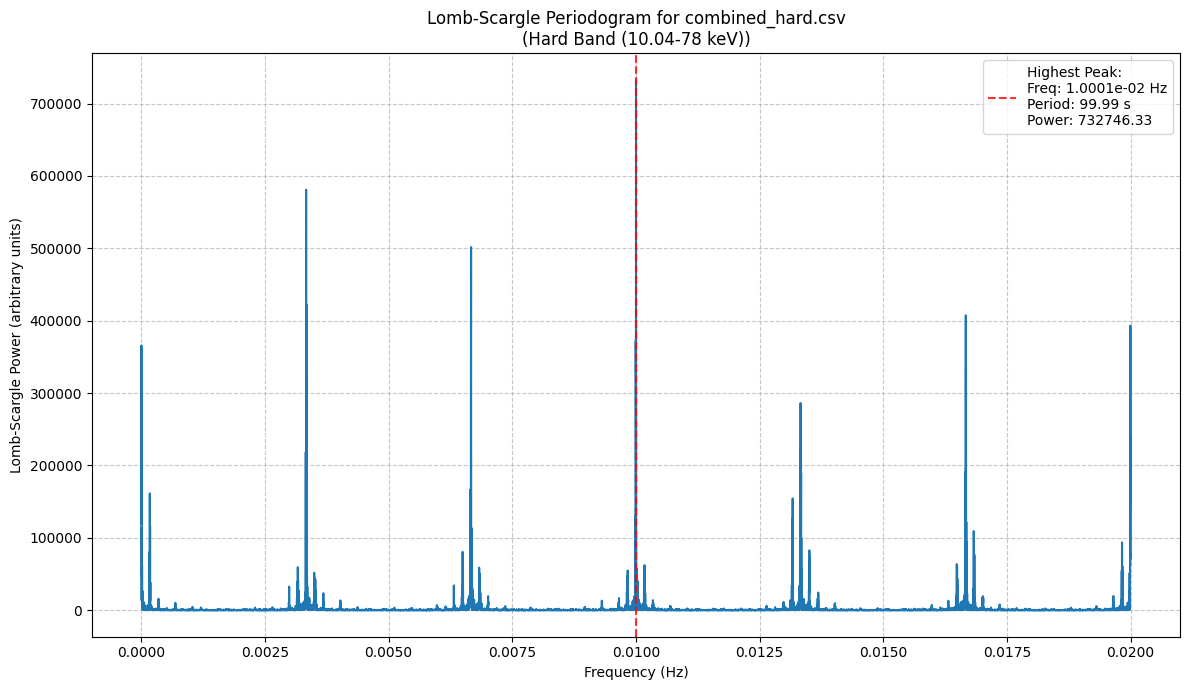

  Displayed Lomb-Scargle periodogram for combined_hard.csv.
  Highest peak at Frequency: 1.0001e-02 Hz (Period: 99.99 s)
--- Processing file: combined_soft.csv (Soft Band (3-10 keV)) ---


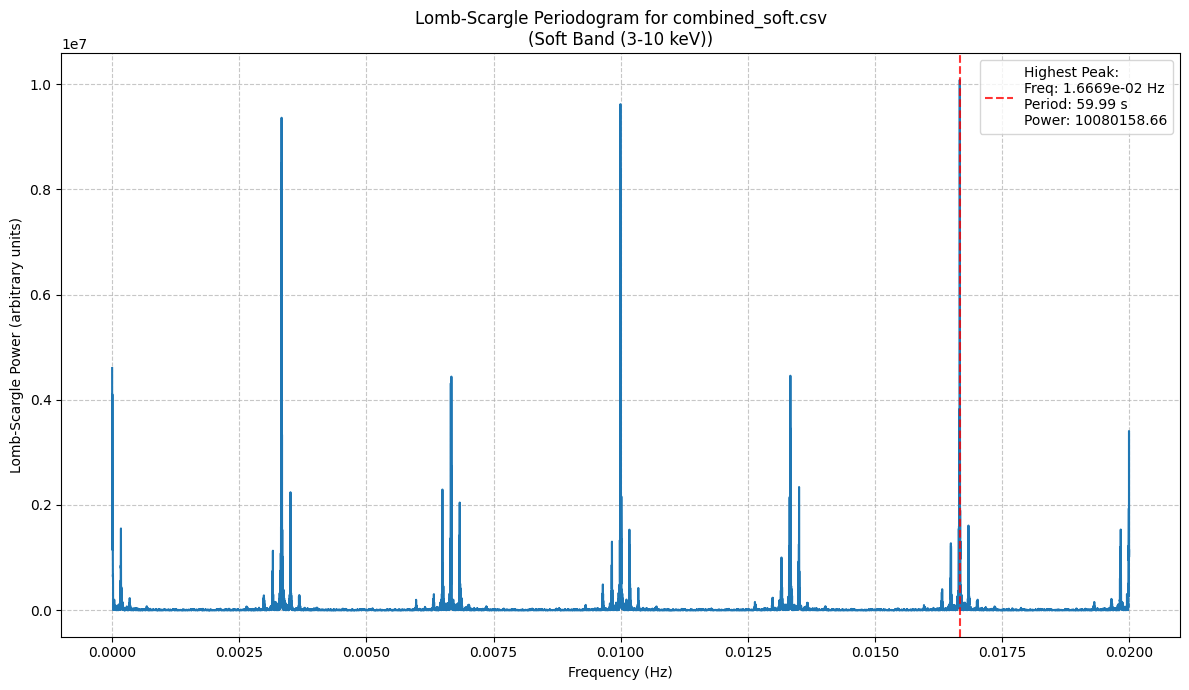

  Displayed Lomb-Scargle periodogram for combined_soft.csv.
  Highest peak at Frequency: 1.6669e-02 Hz (Period: 59.99 s)
--- Processing file: combined_full.csv (Full Band (3-78 keV)) ---


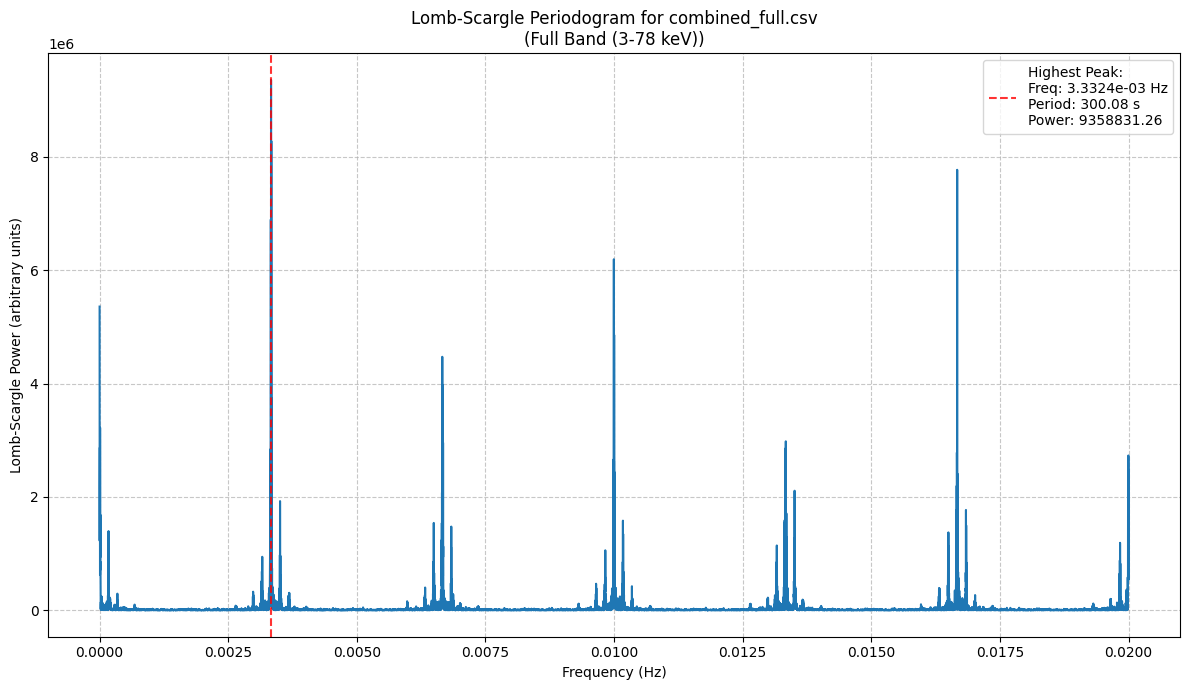

  Displayed Lomb-Scargle periodogram for combined_full.csv.
  Highest peak at Frequency: 3.3324e-03 Hz (Period: 300.08 s)

--- Periodogram Interpretation Notes ---
The plots show Lomb-Scargle power versus frequency.
- Higher peaks suggest stronger evidence for a periodic signal at that frequency.
- The 'Period' indicated for the highest peak is simply 1/Frequency.
- The power units are arbitrary with this basic scipy implementation; focus on relative peak heights.
- For rigorous scientific claims, you would need to assess the statistical significance of these peaks (e.g., by calculating False Alarm Probabilities), which is beyond this script's scope but is a crucial next step.
- Consider the overall shape: Are there multiple interesting peaks? Is there a lot of noise (many small peaks)?
- The chosen frequency range (minimum and maximum frequency scanned) can influence the results. The current settings aim for a broad exploratory range.
- Long-term trends in the data (if not removed) ca

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle

def plot_lomb_scargle_periodogram(df, file_name_full, energy_band_name):
    """
    Calculates and plots a Lomb-Scargle periodogram for the given DataFrame.
    The periodogram is calculated for the entire file, sorted by MET.

    Args:
        df (pd.DataFrame): DataFrame with 'MET' and 'RATE' columns.
        file_name_full (str): The full name of the CSV file being processed.
        energy_band_name (str): The name of the energy band.
    """
    if 'MET' not in df.columns or 'RATE' not in df.columns:
        print(f"Skipping {file_name_full}: Missing 'MET' or 'RATE' column.")
        return

    # Ensure MET and RATE are numeric and drop rows with NaNs in these columns
    try:
        df['MET'] = pd.to_numeric(df['MET'])
        df['RATE'] = pd.to_numeric(df['RATE'])
    except ValueError:
        print(f"Skipping {file_name_full}: 'MET' or 'RATE' column contains non-numeric values that could not be converted.")
        return

    df_cleaned = df[['MET', 'RATE']].dropna()

    if len(df_cleaned) < 3: # Lomb-Scargle needs at least a few points
        print(f"Skipping {file_name_full}: Not enough valid data points ({len(df_cleaned)}) after cleaning NaNs for Lomb-Scargle.")
        return

    # Sort by MET
    df_cleaned.sort_values('MET', inplace=True)

    t = df_cleaned['MET'].values
    y = df_cleaned['RATE'].values

    # It's good practice to subtract the mean from the signal
    y_mean_subtracted = y - y.mean()

    # --- Define frequency range ---
    # Minimum frequency: 1 / total duration of the observation span
    # Maximum frequency: The paper mentions binning at 100s.
    # A Nyquist-like frequency for 100s sampling would be 1/(2*100s) = 0.005 Hz.
    # Let's scan up to a higher frequency to see if there are shorter periods, e.g., period of 50s (0.02 Hz).
    # Or, more generally, related to the average or minimum sampling interval.
    # For very long datasets, oversampling in frequency is good.

    t_span = t.max() - t.min()
    if t_span == 0:
        print(f"Skipping {file_name_full}: Time span is zero (all MET values are the same).")
        return

    min_freq_hz = 1.0 / t_span
    # Let's set max_freq based on a reasonable minimum period we might expect, e.g., 100s (paper binning)
    # The highest frequency would be 1/min_period. Let's try a min_period of ~200s (Nyquist for 100s binning)
    # or even shorter, like 50s, to explore.
    # Max frequency corresponding to a period of 50 seconds.
    max_freq_hz = 1.0 / 50.0 # 0.02 Hz

    # Number of frequency points to evaluate
    # A common rule of thumb is several times the number of data points for good resolution
    num_freq_points = len(t) * 5 # Can be adjusted

    # Create an array of angular frequencies for lombscargle
    # Frequencies for lombscargle are angular: omega = 2 * pi * f
    ang_freqs = np.linspace(2 * np.pi * min_freq_hz, 2 * np.pi * max_freq_hz, num_freq_points)

    # Calculate Lomb-Scargle periodogram
    # Note: scipy's lombscargle power is not normalized in a standard way like Astropy's.
    # The power is approximately (A^2 * N) / 4 for a signal A*sin(omega*t) with N points.
    # We will focus on relative peak heights.
    power = lombscargle(t, y_mean_subtracted, ang_freqs, normalize=False) # normalize=True standardizes power

    # Convert angular frequencies back to regular frequencies (Hz) for plotting
    freqs_hz = ang_freqs / (2 * np.pi)

    # --- Plotting ---
    plt.figure(figsize=(12, 7))
    plt.plot(freqs_hz, power)

    # Find the peak frequency
    peak_index = np.argmax(power)
    peak_freq_hz = freqs_hz[peak_index]
    peak_power = power[peak_index]
    peak_period_s = 1.0 / peak_freq_hz

    plt.title(f'Lomb-Scargle Periodogram for {file_name_full}\n({energy_band_name})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Lomb-Scargle Power (arbitrary units)')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)

    # Annotate the highest peak
    plt.axvline(peak_freq_hz, color='red', linestyle='--', alpha=0.8,
                label=f'Highest Peak:\nFreq: {peak_freq_hz:.4e} Hz\nPeriod: {peak_period_s:.2f} s\nPower: {peak_power:.2f}')
    plt.legend(loc='upper right')

    # Set x-axis to log scale if the frequency range is large, or if it helps visualization
    # plt.xscale('log') # Uncomment if desired
    # plt.yscale('log') # Uncomment if power range is very large

    plt.tight_layout()
    plt.show()
    print(f"  Displayed Lomb-Scargle periodogram for {file_name_full}.")
    print(f"  Highest peak at Frequency: {peak_freq_hz:.4e} Hz (Period: {peak_period_s:.2f} s)")


# --- INSTRUCTIONS ---
# 1. Save this code as a Python file (e.g., plot_lombscargle.py) in the SAME DIRECTORY
#    as your CSV files: 'combined_hard.csv', 'combined_soft.csv', 'combined_full.csv'.
# 2. If your files are in a different directory, you will need to modify the
#    file_paths list below to include the full path to each file.
# 3. Run the script from your terminal: python plot_lombscargle.py
#    You will need pandas, numpy, matplotlib, and scipy installed.
#    (pip install pandas numpy matplotlib scipy)

file_paths = ['combined_hard.csv', 'combined_soft.csv', 'combined_full.csv']
# Updated energy band information as per user request on 2025-05-08
energy_bands = ['Hard Band (10.04-78 keV)', 'Soft Band (3-10 keV)', 'Full Band (3-78 keV)']

for i, file_path in enumerate(file_paths):
    print(f"--- Processing file: {file_path} ({energy_bands[i]}) ---")
    try:
        # Load the CSV file
        df_current = pd.read_csv(file_path)

        if df_current.empty:
            print(f"File {file_path} is empty. Skipping.")
            continue

        plot_lomb_scargle_periodogram(df_current, file_path, energy_bands[i])

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it is in the correct directory, or update the 'file_paths' list in the script.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_path}' is empty (or could not be parsed as CSV).")
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")

print("\n--- Periodogram Interpretation Notes ---")
print("The plots show Lomb-Scargle power versus frequency.")
print("- Higher peaks suggest stronger evidence for a periodic signal at that frequency.")
print("- The 'Period' indicated for the highest peak is simply 1/Frequency.")
print("- The power units are arbitrary with this basic scipy implementation; focus on relative peak heights.")
print("- For rigorous scientific claims, you would need to assess the statistical significance of these peaks (e.g., by calculating False Alarm Probabilities), which is beyond this script's scope but is a crucial next step.")
print("- Consider the overall shape: Are there multiple interesting peaks? Is there a lot of noise (many small peaks)?")
print("- The chosen frequency range (minimum and maximum frequency scanned) can influence the results. The current settings aim for a broad exploratory range.")
print("- Long-term trends in the data (if not removed) can sometimes appear as power at very low frequencies.")

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
import time # To estimate FAP calculation time

# --- Configuration ---
FAP_THRESHOLD = 0.01  # Report OBSIDs if FAP of highest peak is below this
N_BOOTSTRAP_ITERATIONS = 1000  # Number of iterations for bootstrap FAP. Reduce for speed, increase for accuracy.
MIN_PERIOD_TO_SEARCH_S = 50.0 # Shortest period (in seconds) to search for
MIN_DATA_POINTS_FOR_LSP = 10 # Minimum number of data points required for an OBSID to be processed

def calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, observed_peak_power, n_bootstraps):
    """
    Estimates False Alarm Probability (FAP) using bootstrap.
    """
    if len(t) < MIN_DATA_POINTS_FOR_LSP: # Not enough points for meaningful bootstrap
        return 1.0

    bootstrap_peak_powers = []
    for _ in range(n_bootstraps):
        # Shuffle the y values, keeping t fixed
        y_shuffled = np.random.permutation(y_mean_subtracted)
        power_shuffled = lombscargle(t, y_shuffled, ang_freqs, normalize=True) # Normalize for FAP
        bootstrap_peak_powers.append(np.max(power_shuffled))

    false_alarms = np.sum(np.array(bootstrap_peak_powers) >= observed_peak_power)
    fap = false_alarms / n_bootstraps
    return fap

def analyze_obsid_periodicity(df_obsid_data, obsid, file_name_full, energy_band_name):
    """
    Calculates Lomb-Scargle periodogram and FAP for a single OBSID.

    Returns:
        dict: Containing peak info and FAP, or None if not processed.
    """
    if 'MET' not in df_obsid_data.columns or 'RATE' not in df_obsid_data.columns:
        print(f"    Skipping OBSID {obsid} in {file_name_full}: Missing 'MET' or 'RATE' column.")
        return None

    try:
        df_obsid_data['MET'] = pd.to_numeric(df_obsid_data['MET'])
        df_obsid_data['RATE'] = pd.to_numeric(df_obsid_data['RATE'])
    except ValueError:
        print(f"    Skipping OBSID {obsid} in {file_name_full}: 'MET' or 'RATE' non-numeric.")
        return None

    df_cleaned = df_obsid_data[['MET', 'RATE']].dropna()

    if len(df_cleaned) < MIN_DATA_POINTS_FOR_LSP:
        # print(f"    Skipping OBSID {obsid} in {file_name_full}: Not enough valid data points ({len(df_cleaned)}) for Lomb-Scargle after cleaning.")
        return None

    df_cleaned = df_cleaned.sort_values('MET') # Ensure sorted
    t = df_cleaned['MET'].values
    y = df_cleaned['RATE'].values
    y_mean_subtracted = y - y.mean()

    t_span = t.max() - t.min()
    if t_span == 0:
        # print(f"    Skipping OBSID {obsid} in {file_name_full}: Time span is zero.")
        return None

    # Define frequency range for this OBSID
    min_freq_hz = 1.0 / t_span
    max_freq_hz = 1.0 / MIN_PERIOD_TO_SEARCH_S

    # Ensure max_freq is sensible for the observation duration (e.g., at least two full cycles of max_freq)
    if t_span < 2.0 * MIN_PERIOD_TO_SEARCH_S : # If t_span is too short for the desired max_freq
        max_freq_hz = 1.0 / (t_span / 2.0) # Set max_freq to Nyquist for this segment
        # print(f"    Adjusted max_freq_hz for OBSID {obsid} to {max_freq_hz:.3e} Hz due to short t_span ({t_span:.2f}s).")


    if min_freq_hz >= max_freq_hz:
        # print(f"    Skipping OBSID {obsid} in {file_name_full}: Min frequency ({min_freq_hz:.2e}) >= max frequency ({max_freq_hz:.2e}). Observation likely too short.")
        return None

    # Number of frequency points: oversample the frequency space
    # Heuristic: at least 5 points per "independent frequency" (roughly N/2) or more
    num_freq_points = max(len(t) * 5, 2000) # Ensure a reasonable number of points, e.g. 2000

    ang_freqs = np.linspace(2 * np.pi * min_freq_hz, 2 * np.pi * max_freq_hz, num_freq_points)

    # Calculate Lomb-Scargle periodogram, normalized for FAP calculation
    power = lombscargle(t, y_mean_subtracted, ang_freqs, normalize=True)
    freqs_hz = ang_freqs / (2 * np.pi)

    peak_index = np.argmax(power)
    peak_freq_hz = freqs_hz[peak_index]
    peak_power = power[peak_index]
    peak_period_s = 1.0 / peak_freq_hz if peak_freq_hz > 0 else np.inf

    # FAP Calculation
    fap_start_time = time.time()
    fap = calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, peak_power, N_BOOTSTRAP_ITERATIONS)
    fap_duration = time.time() - fap_start_time
    # print(f"      FAP calculation for OBSID {obsid} took {fap_duration:.2f}s.")


    return {
        'obsid': obsid,
        'file': file_name_full,
        'band': energy_band_name,
        'peak_freq_hz': peak_freq_hz,
        'peak_period_s': peak_period_s,
        'peak_power_normalized': peak_power, # This is normalized power
        'fap': fap,
        'num_points': len(t),
        't_span_s': t_span
    }

def plot_specific_obsid_periodogram(df_obsid_data, obsid, file_name_full, energy_band_name):
    """
    Plots the Lomb-Scargle periodogram for a specific OBSID.
    This function is for on-demand plotting after reviewing reported results.
    """
    print(f"\n--- Plotting Periodogram for OBSID: {obsid} from File: {file_name_full} ({energy_band_name}) ---")

    analysis_results = analyze_obsid_periodicity(df_obsid_data, obsid, file_name_full, energy_band_name)

    if analysis_results is None:
        print(f"Could not generate periodogram for OBSID {obsid}. See previous messages for reasons.")
        return

    # Re-calculate for plotting (or store freqs_hz and power if analyze_obsid_periodicity returns them)
    # For simplicity, let's re-run the core LSP part here for plotting (could be refactored)
    df_cleaned = df_obsid_data[['MET', 'RATE']].dropna().sort_values('MET')
    t = df_cleaned['MET'].values
    y = df_cleaned['RATE'].values
    y_mean_subtracted = y - y.mean()
    t_span = t.max() - t.min()

    min_freq_hz = 1.0 / t_span
    max_freq_hz = 1.0 / MIN_PERIOD_TO_SEARCH_S
    if t_span < 2.0 * MIN_PERIOD_TO_SEARCH_S:
        max_freq_hz = 1.0 / (t_span / 2.0)

    if min_freq_hz >= max_freq_hz: return # Already handled in analyze_obsid_periodicity

    num_freq_points = max(len(t) * 5, 2000)
    ang_freqs = np.linspace(2 * np.pi * min_freq_hz, 2 * np.pi * max_freq_hz, num_freq_points)

    # Using unnormalized power for plotting consistency if desired, or normalized is fine.
    # Let's use normalized as that's what FAP was based on.
    power = lombscargle(t, y_mean_subtracted, ang_freqs, normalize=True)
    freqs_hz = ang_freqs / (2 * np.pi)

    plt.figure(figsize=(12, 7))
    plt.plot(freqs_hz, power)

    plt.title(f'Lomb-Scargle Periodogram for OBSID: {analysis_results["obsid"]}\nFile: {analysis_results["file"]} ({analysis_results["band"]})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Lomb-Scargle Power (Normalized)')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)

    plt.axvline(analysis_results['peak_freq_hz'], color='red', linestyle='--', alpha=0.8,
                label=(f'Highest Peak:\nFreq: {analysis_results["peak_freq_hz"]:.3e} Hz\n'
                       f'Period: {analysis_results["peak_period_s"]:.2f} s\n'
                       f'Norm. Power: {analysis_results["peak_power_normalized"]:.3f}\n'
                       f'FAP: {analysis_results["fap"]:.4f}'))
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"  Displayed Lomb-Scargle for OBSID {analysis_results['obsid']}. Peak Freq: {analysis_results['peak_freq_hz']:.3e} Hz, Period: {analysis_results['peak_period_s']:.2f} s, FAP: {analysis_results['fap']:.4f}")


# --- Main Script ---
# file_paths = ['combined_hard.csv', 'combined_soft.csv', 'combined_full.csv']
# energy_bands = ['Hard Band (10.04-78 keV)', 'Soft Band (3-10 keV)', 'Full Band (3-78 keV)']
# For testing, you might want to use just one file or a subset of OBSIDs
# Example: Create dummy files for testing if real ones are not available in environment
# For actual use, ensure your CSV files are in the same directory or provide full paths.

# Create dummy files for demonstration if they don't exist
# In a real scenario, these files would be your actual data.
def create_dummy_csv(file_path, n_obsids=2, n_points_per_obsid=200):
    if not pd.io.common.file_exists(file_path):
        print(f"Creating dummy file: {file_path}")
        data = []
        for i in range(n_obsids):
            obsid = f"DUMMY_OBS_{i+1:03d}"
            met_start = time.time() + i * 10000
            # Simulate some sampling, some regular, some with gaps
            met_times = []
            current_met = met_start
            for j in range(n_points_per_obsid):
                met_times.append(current_met)
                if j % 20 == 0 and j > 0: # Introduce a small gap
                    current_met += np.random.uniform(200, 500)
                else:
                    current_met += np.random.uniform(90,110) # Mostly regular around 100s

            # Simulate a signal with some noise and maybe a period
            period1 = np.random.uniform(200, 1000)
            rate_signal = 10 + 2 * np.sin(2 * np.pi * (np.array(met_times) - met_start) / period1) + \
                          1 * np.sin(2 * np.pi * (np.array(met_times) - met_start) / (period1*0.5)) # harmonic
            rate_noise = np.random.normal(0, 0.5, n_points_per_obsid)
            rates = rate_signal + rate_noise
            errors = np.abs(np.random.normal(0.1, 0.05, n_points_per_obsid))

            for k in range(n_points_per_obsid):
                data.append({'MET': met_times[k], 'RATE': rates[k], 'ERROR': errors[k], 'OBSID': obsid})
        df = pd.DataFrame(data)
        df.to_csv(file_path, index=False)
    else:
        print(f"File {file_path} already exists. Using existing file.")

file_paths = ['combined_hard.csv', 'combined_soft.csv', 'combined_full.csv']
energy_bands = ['Hard Band (10.04-78 keV)', 'Soft Band (3-10 keV)', 'Full Band (3-78 keV)']

# # Uncomment to create dummy files for testing if you don't have the real ones
# for fp in file_paths:
#    create_dummy_csv(fp, n_obsids=3, n_points_per_obsid=np.random.randint(50, 300))


all_results = []
print(f"Starting Lomb-Scargle analysis for individual OBSIDs...")
print(f"FAP threshold for reporting: {FAP_THRESHOLD}")
print(f"Bootstrap iterations for FAP: {N_BOOTSTRAP_ITERATIONS}")
print(f"Minimum period to search for: {MIN_PERIOD_TO_SEARCH_S} s")
print(f"Minimum data points per OBSID: {MIN_DATA_POINTS_FOR_LSP}")


for i, file_path in enumerate(file_paths):
    print(f"\n--- Processing file: {file_path} ({energy_bands[i]}) ---")
    try:
        df_full_file = pd.read_csv(file_path)

        if df_full_file.empty:
            print(f"File {file_path} is empty. Skipping.")
            continue

        if 'OBSID' not in df_full_file.columns:
            print(f"Skipping {file_path}: Missing 'OBSID' column.")
            continue

        unique_obsids = df_full_file['OBSID'].unique()
        print(f"Found {len(unique_obsids)} OBSIDs in {file_path}.")

        for obsid_count, obsid in enumerate(unique_obsids):
            # print(f"  Processing OBSID: {obsid} ({obsid_count+1}/{len(unique_obsids)}) from {file_path}...")
            df_obsid_data = df_full_file[df_full_file['OBSID'] == obsid].copy()

            result = analyze_obsid_periodicity(df_obsid_data, obsid, file_path, energy_bands[i])
            if result:
                all_results.append(result)

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it is in the correct directory, or update the 'file_paths' list in the script.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_path}' is empty (or could not be parsed as CSV).")
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")

print("\n\n--- Summary of Potentially Interesting OBSIDs (FAP < Threshold) ---")
if not all_results:
    print("No OBSIDs met the criteria for reporting (or no data processed).")
else:
    interesting_count = 0
    for res in sorted(all_results, key=lambda x: x['fap']): # Sort by FAP
        if res['fap'] < FAP_THRESHOLD:
            interesting_count +=1
            print(f"File: {res['file']}, OBSID: {res['obsid']}, Band: {res['band']}")
            print(f"  Peak Freq: {res['peak_freq_hz']:.4e} Hz, Period: {res['peak_period_s']:.2f} s")
            print(f"  Norm. Power: {res['peak_power_normalized']:.3f}, FAP: {res['fap']:.4f}")
            print(f"  (N_points: {res['num_points']}, T_span: {res['t_span_s']:.2f} s)")
            print("-" * 30)
    if interesting_count == 0:
        print(f"No OBSIDs found with FAP < {FAP_THRESHOLD}.")


print("\n--- How to Plot Specific OBSIDs ---")
print("If you want to plot the periodogram for any specific OBSID reported above (or any other):")
print("1. Ensure you have the data loaded for the file containing the OBSID.")
print("   Example: df_file = pd.read_csv('path_to_your_file.csv')")
print("2. Filter for the specific OBSID.")
print("   Example: df_single_obs = df_file[df_file['OBSID'] == 'your_obsid_here'].copy()")
print("3. Call the plotting function:")
print("   Example: plot_specific_obsid_periodogram(df_single_obs, 'your_obsid_here', 'file_name.csv', 'Energy Band Name')")
print("\nExample usage for plotting (after running the main script and identifying an OBSID):")
print("# obsid_to_plot = 'DUMMY_OBS_001' # Replace with actual OBSID")
print("# file_containing_obsid = 'combined_hard.csv' # Replace with actual file")
print("# band_name = 'Hard Band (10.04-78 keV)' # Replace as appropriate")
print("# try:")
print("#     df_plot_file = pd.read_csv(file_containing_obsid)")
print("#     df_to_plot = df_plot_file[df_plot_file['OBSID'] == obsid_to_plot].copy()")
print("#     if not df_to_plot.empty:")
print("#         plot_specific_obsid_periodogram(df_to_plot, obsid_to_plot, file_containing_obsid, band_name)")
print("#     else:")
print("#         print(f'OBSID {obsid_to_plot} not found in {file_containing_obsid} or data is empty.')")
print("# except FileNotFoundError:")
print("#     print(f'File {file_containing_obsid} not found for plotting.')")



Starting Lomb-Scargle analysis for individual OBSIDs...
FAP threshold for reporting: 0.01
Bootstrap iterations for FAP: 1000
Minimum period to search for: 50.0 s
Minimum data points per OBSID: 10

--- Processing file: combined_hard.csv (Hard Band (10.04-78 keV)) ---
Found 26 OBSIDs in combined_hard.csv.

--- Processing file: combined_soft.csv (Soft Band (3-10 keV)) ---
Found 26 OBSIDs in combined_soft.csv.

--- Processing file: combined_full.csv (Full Band (3-78 keV)) ---
Found 26 OBSIDs in combined_full.csv.


--- Summary of Potentially Interesting OBSIDs (FAP < Threshold) ---
File: combined_hard.csv, OBSID: 30001011005, Band: Hard Band (10.04-78 keV)
  Peak Freq: 1.9980e-02 Hz, Period: 50.05 s
  Norm. Power: 0.764, FAP: 0.0000
  (N_points: 91, T_span: 43800.00 s)
------------------------------
File: combined_hard.csv, OBSID: 30001011007, Band: Hard Band (10.04-78 keV)
  Peak Freq: 6.6503e-03 Hz, Period: 150.37 s
  Norm. Power: 0.443, FAP: 0.0000
  (N_points: 208, T_span: 96300.00 s)



Loading CSV data files for verification plots...
  Successfully loaded combined_hard.csv
  Successfully loaded combined_soft.csv
  Successfully loaded combined_full.csv

--- Searching for Consistent Periods Across Bands (Tolerance: 10.0%) ---
Found 19 OBSIDs with potentially consistent periods across bands:
  OBSID: 30001011002
    ~9026.84 s detected in: Full Band (3-78 keV), Soft Band (3-10 keV)
      - Soft Band (3-10 keV): P=9026.84s, FAP=0.0050, Pow=0.281
      - Full Band (3-78 keV): P=9026.84s, FAP=0.0050, Pow=0.274
  OBSID: 30001011005
    ~75.11 s detected in: Full Band (3-78 keV), Soft Band (3-10 keV)
      - Soft Band (3-10 keV): P=75.11s, FAP=0.0000, Pow=0.768
      - Full Band (3-78 keV): P=75.11s, FAP=0.0000, Pow=0.768
  OBSID: 30001011007
    ~150.37 s detected in: Full Band (3-78 keV), Hard Band (10.04-78 keV), Soft Band (3-10 keV)
      - Hard Band (10.04-78 keV): P=150.37s, FAP=0.0000, Pow=0.443
      - Soft Band (3-10 keV): P=150.37s, FAP=0.0000, Pow=0.512
      - F

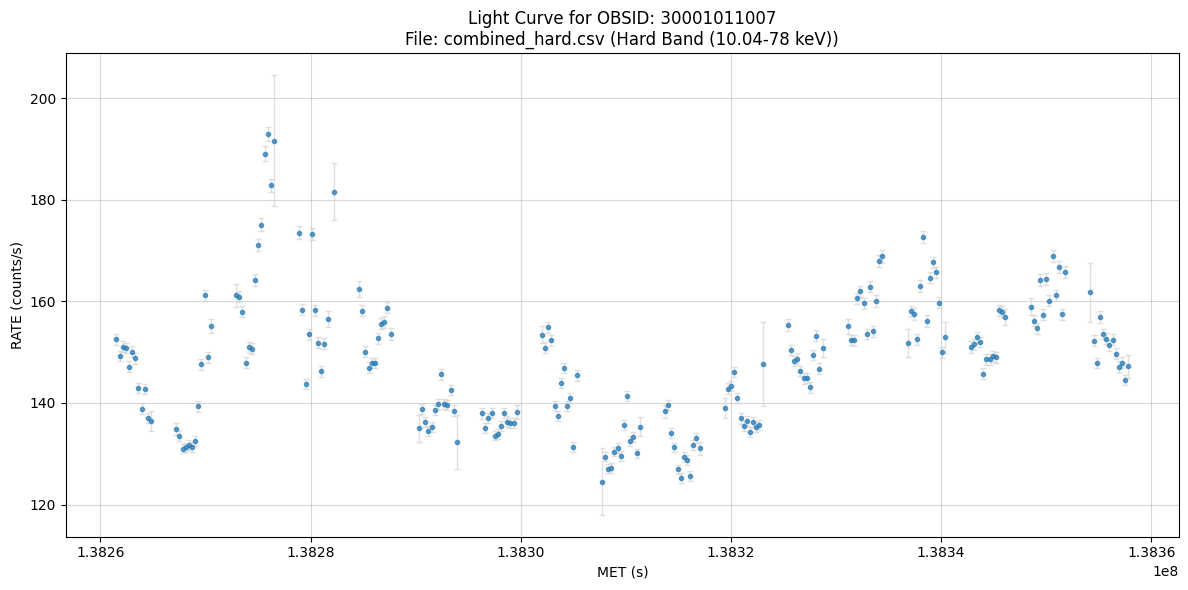

  Displayed light curve for OBSID 30001011007.

--- Plotting Phase-Folded Light Curve for OBSID: 30001011007, Period: 150.37s ---
File: combined_hard.csv (Hard Band (10.04-78 keV))


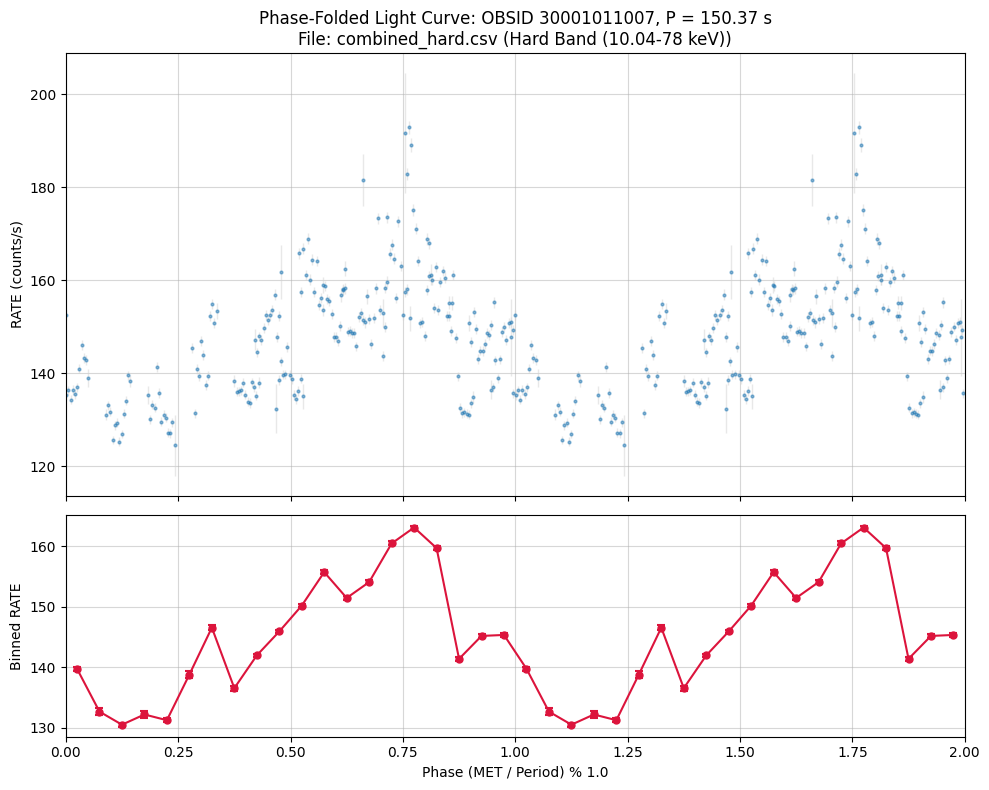

  Displayed phase-folded light curve for OBSID 30001011007.
No data for OBSID 30001011005 in combined_hard.csv to plot periodogram.

--- Toolkit Ready ---
Ensure 'all_results' (from your previous script) is populated in your current session.
Call the functions (find_consistent_periods, plot_light_curve, plot_phase_folded_light_curve, plot_specific_obsid_periodogram) as needed with your specific OBSIDs and periods of interest.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle # Using scipy as per the user's last run script
import time

# --- Configuration from the user's Scipy-based script & for this toolkit ---
# Ensure these match the settings used when 'all_results' was generated
FAP_THRESHOLD = 0.01  # Report OBSIDs if FAP of highest peak is below this
N_BOOTSTRAP_ITERATIONS = 1000 # Used if re-calculating FAP (e.g. in periodogram plot)
MIN_PERIOD_TO_SEARCH_S = 50.0
MIN_DATA_POINTS_FOR_LSP = 10

# Toolkit-specific configuration
PERIOD_TOLERANCE_PERCENT = 10.0 # Percentage tolerance for considering periods "similar" across bands
PHASE_BINS = 20 # Number of bins for binned phase-folded light curve

# --- Functions for periodogram plotting (re-analysis for visualization) ---
def calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, observed_peak_power, n_bootstraps):
    """ Estimates False Alarm Probability (FAP) using bootstrap. """
    if len(t) < MIN_DATA_POINTS_FOR_LSP: return 1.0
    bootstrap_peak_powers = []
    for _ in range(n_bootstraps):
        y_shuffled = np.random.permutation(y_mean_subtracted)
        # Ensure ang_freqs is not empty and has valid range before calling lombscargle
        if len(ang_freqs) == 0 or ang_freqs.max() <= ang_freqs.min():
            # This case should ideally be caught before calling this function
            # by checks in analyze_obsid_periodicity_for_plot
            return 1.0 # Cannot calculate FAP
        power_shuffled = lombscargle(t, y_shuffled, ang_freqs, normalize=True)
        if len(power_shuffled) > 0:
            bootstrap_peak_powers.append(np.max(power_shuffled))
        else:
            # Handle empty power_shuffled if ang_freqs was problematic despite checks
            # This indicates an issue with frequency range setting
            pass

    if not bootstrap_peak_powers: # If no powers were calculated
        return 1.0

    false_alarms = np.sum(np.array(bootstrap_peak_powers) >= observed_peak_power)
    return false_alarms / n_bootstraps

def analyze_obsid_periodicity_for_plot(df_obsid_data, obsid, file_name_full, energy_band_name):
    """
    Calculates Lomb-Scargle periodogram details for a single OBSID for plotting.
    Returns the full result dictionary including frequencies and power arrays.
    """
    if 'MET' not in df_obsid_data.columns or 'RATE' not in df_obsid_data.columns:
        print(f"Debug: Missing MET/RATE for OBSID {obsid} in {file_name_full}")
        return None
    try:
        df_obsid_data['MET'] = pd.to_numeric(df_obsid_data['MET'])
        df_obsid_data['RATE'] = pd.to_numeric(df_obsid_data['RATE'])
    except ValueError:
        print(f"Debug: Non-numeric MET/RATE for OBSID {obsid} in {file_name_full}")
        return None

    df_cleaned = df_obsid_data[['MET', 'RATE']].dropna().sort_values('MET')
    if len(df_cleaned) < MIN_DATA_POINTS_FOR_LSP:
        # print(f"Debug: Not enough data points for OBSID {obsid} after cleaning: {len(df_cleaned)}")
        return None

    t = df_cleaned['MET'].values
    y = df_cleaned['RATE'].values
    y_mean_subtracted = y - y.mean()
    t_span = t.max() - t.min()
    if t_span == 0:
        # print(f"Debug: Zero t_span for OBSID {obsid}")
        return None

    min_freq_hz = 1.0 / t_span
    max_freq_hz = 1.0 / MIN_PERIOD_TO_SEARCH_S
    if t_span < 2.0 * MIN_PERIOD_TO_SEARCH_S: # Ensure at least two cycles of shortest period
        max_freq_hz = 1.0 / (t_span / 2.0)

    if min_freq_hz >= max_freq_hz:
        # print(f"Debug: min_freq >= max_freq for OBSID {obsid}. Min: {min_freq_hz:.2e}, Max: {max_freq_hz:.2e}")
        return None

    num_freq_points = max(int(len(t) * 5), 2000) # Ensure a decent number of points

    # Check if linspace would result in num < 0 or non-sensical range
    if max_freq_hz <= min_freq_hz: # Redundant due to above check, but safe
        # print(f"Debug: max_freq_hz <= min_freq_hz before linspace for OBSID {obsid}")
        return None

    ang_freqs = np.linspace(2 * np.pi * min_freq_hz, 2 * np.pi * max_freq_hz, num_freq_points)
    if len(ang_freqs) == 0 :
        # print(f"Debug: ang_freqs is empty for OBSID {obsid}")
        return None


    power_normalized = lombscargle(t, y_mean_subtracted, ang_freqs, normalize=True)
    if len(power_normalized) == 0: # Should not happen if ang_freqs is not empty
        # print(f"Debug: power_normalized is empty for OBSID {obsid}")
        return None

    freqs_hz = ang_freqs / (2 * np.pi)

    peak_index = np.argmax(power_normalized)
    peak_freq_hz = freqs_hz[peak_index]
    peak_power_norm = power_normalized[peak_index]
    peak_period_s = 1.0 / peak_freq_hz if peak_freq_hz > 0 else np.inf

    fap = calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, peak_power_norm, N_BOOTSTRAP_ITERATIONS)

    return {
        'obsid': obsid, 'file': file_name_full, 'band': energy_band_name,
        'peak_freq_hz': peak_freq_hz, 'peak_period_s': peak_period_s,
        'peak_power_normalized': peak_power_norm, 'fap': fap,
        'num_points': len(t), 't_span_s': t_span,
        'frequencies_for_plot': freqs_hz, 'power_for_plot': power_normalized
    }

def plot_specific_obsid_periodogram(df_obsid_data, obsid, file_name_full, energy_band_name):
    """
    Plots the Lomb-Scargle periodogram for a specific OBSID by re-analyzing.
    """
    print(f"\n--- Plotting Periodogram for OBSID: {obsid} from File: {file_name_full} ({energy_band_name}) ---")

    plot_data = analyze_obsid_periodicity_for_plot(df_obsid_data, obsid, file_name_full, energy_band_name)

    if plot_data is None or 'frequencies_for_plot' not in plot_data or 'power_for_plot' not in plot_data:
        print(f"Could not generate periodogram data for OBSID {obsid} in {file_name_full}. Check data and parameters.")
        return

    plt.figure(figsize=(12, 7))
    plt.plot(plot_data['frequencies_for_plot'], plot_data['power_for_plot'])

    plt.title(f'Lomb-Scargle Periodogram for OBSID: {plot_data["obsid"]}\nFile: {plot_data["file"]} ({plot_data["band"]})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Lomb-Scargle Power (Normalized)')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)

    fap_text = f"{plot_data['fap']:.4f}" if not np.isnan(plot_data['fap']) else "N/A"
    plt.axvline(plot_data['peak_freq_hz'], color='red', linestyle='--', alpha=0.8,
                label=(f'Highest Peak:\nFreq: {plot_data["peak_freq_hz"]:.3e} Hz\n'
                       f'Period: {plot_data["peak_period_s"]:.2f} s\n'
                       f'Norm. Power: {plot_data["peak_power_normalized"]:.3f}\n'
                       f'FAP (recalc): {fap_text}'))
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"  Displayed Lomb-Scargle for OBSID {plot_data['obsid']}. Peak Freq: {plot_data['peak_freq_hz']:.3e} Hz, Period: {plot_data['peak_period_s']:.2f} s, FAP (recalc): {fap_text}")


# --- Toolkit Functions for Verification ---

def find_consistent_periods(all_results_list, tolerance_percent=PERIOD_TOLERANCE_PERCENT):
    """
    Identifies OBSIDs that show similar significant periods across multiple energy bands.
    'all_results_list' should be the list of dicts from your previous scipy-based script.
    """
    print(f"\n--- Searching for Consistent Periods Across Bands (Tolerance: {tolerance_percent}%) ---")
    obsid_map = {}
    for res in all_results_list:
        # Ensure FAP is not NaN and meets threshold before considering for consistency
        if 'fap' not in res or np.isnan(res['fap']) or res['fap'] > FAP_THRESHOLD:
            continue
        obsid_map.setdefault(res['obsid'], []).append(res)

    consistent_obsids_summary = {}

    for obsid, results_for_obsid in obsid_map.items():
        if len(results_for_obsid) < 2:
            continue

        results_for_obsid.sort(key=lambda x: x['peak_period_s'])

        grouped_by_period = []
        temp_group = []
        for res_item in results_for_obsid:
            if not temp_group:
                temp_group.append(res_item)
            else:
                mean_period_of_temp_group = np.mean([r['peak_period_s'] for r in temp_group])
                if abs(res_item['peak_period_s'] - mean_period_of_temp_group) <= (tolerance_percent / 100.0) * mean_period_of_temp_group:
                    temp_group.append(res_item)
                else:
                    if len(temp_group) > 1:
                        grouped_by_period.append(list(temp_group))
                    temp_group = [res_item]
        if len(temp_group) > 1:
            grouped_by_period.append(list(temp_group))

        if grouped_by_period:
            consistent_obsids_summary[obsid] = {}
            for group in grouped_by_period:
                avg_p = np.mean([r['peak_period_s'] for r in group])
                consistent_obsids_summary[obsid][avg_p] = group

    if not consistent_obsids_summary:
        print("No OBSIDs found with consistent periods across multiple bands meeting the FAP threshold.")
    else:
        print(f"Found {len(consistent_obsids_summary)} OBSIDs with potentially consistent periods across bands:")
        for obsid, period_groups in consistent_obsids_summary.items():
            print(f"  OBSID: {obsid}")
            for avg_period, band_results_list in period_groups.items():
                bands_present = sorted(list(set([r['band'] for r in band_results_list])))
                if len(bands_present) > 1:
                    print(f"    ~{avg_period:.2f} s detected in: {', '.join(bands_present)}")
                    for r_detail in band_results_list:
                         print(f"      - {r_detail['band']}: P={r_detail['peak_period_s']:.2f}s, FAP={r_detail['fap']:.4f}, Pow={r_detail['peak_power_normalized']:.3f}")
    return consistent_obsids_summary


def plot_light_curve(df_file_data, obsid_to_plot, file_name, energy_band_name):
    """ Plots the light curve (MET vs. RATE) for a specific OBSID. """
    print(f"\n--- Plotting Light Curve for OBSID: {obsid_to_plot} from File: {file_name} ({energy_band_name}) ---")

    # Ensure OBSID column is of a consistent type for comparison
    # If OBSIDs in df_file_data are integers, convert obsid_to_plot if it's a string, and vice-versa
    if df_file_data['OBSID'].dtype == 'int64' and isinstance(obsid_to_plot, str):
        try:
            obsid_to_plot = int(obsid_to_plot)
        except ValueError:
            print(f"Warning: OBSID {obsid_to_plot} could not be converted to int for matching.")
    elif df_file_data['OBSID'].dtype == 'object' and isinstance(obsid_to_plot, int):
        obsid_to_plot = str(obsid_to_plot)

    obs_data = df_file_data[df_file_data['OBSID'] == obsid_to_plot].copy()

    if obs_data.empty:
        print(f"No data found for OBSID {obsid_to_plot} in {file_name}.")
        return

    obs_data['MET'] = pd.to_numeric(obs_data['MET'])
    obs_data['RATE'] = pd.to_numeric(obs_data['RATE'])
    obs_data.sort_values('MET', inplace=True)

    plt.figure(figsize=(12, 6))
    if 'ERROR' in obs_data.columns:
        obs_data['ERROR'] = pd.to_numeric(obs_data['ERROR'], errors='coerce').fillna(0)
        plt.errorbar(obs_data['MET'], obs_data['RATE'], yerr=obs_data['ERROR'], fmt='o', markersize=3, alpha=0.7, ecolor='lightgray', capsize=2, elinewidth=1)
    else:
        plt.plot(obs_data['MET'], obs_data['RATE'], 'o-', markersize=3, alpha=0.7)

    plt.title(f'Light Curve for OBSID: {obsid_to_plot}\nFile: {file_name} ({energy_band_name})')
    plt.xlabel('MET (s)')
    plt.ylabel('RATE (counts/s)')
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()
    print(f"  Displayed light curve for OBSID {obsid_to_plot}.")


def plot_phase_folded_light_curve(df_file_data, obsid_to_plot, period_s, file_name, energy_band_name, n_bins=PHASE_BINS):
    """ Generates and plots a phase-folded light curve for a specific OBSID and period. """
    print(f"\n--- Plotting Phase-Folded Light Curve for OBSID: {obsid_to_plot}, Period: {period_s:.2f}s ---")
    print(f"File: {file_name} ({energy_band_name})")

    # Ensure OBSID column is of a consistent type for comparison
    if df_file_data['OBSID'].dtype == 'int64' and isinstance(obsid_to_plot, str):
        try:
            obsid_to_plot = int(obsid_to_plot)
        except ValueError:
            print(f"Warning: OBSID {obsid_to_plot} could not be converted to int for matching (phase folding).")
    elif df_file_data['OBSID'].dtype == 'object' and isinstance(obsid_to_plot, int):
        obsid_to_plot = str(obsid_to_plot)

    obs_data = df_file_data[df_file_data['OBSID'] == obsid_to_plot].copy()

    if obs_data.empty:
        print(f"No data found for OBSID {obsid_to_plot} in {file_name}.")
        return
    if period_s <= 0: print("Period must be positive."); return

    obs_data['MET'] = pd.to_numeric(obs_data['MET'])
    obs_data['RATE'] = pd.to_numeric(obs_data['RATE'])
    obs_data.sort_values('MET', inplace=True)

    if len(obs_data) < 2 : # Need at least 2 points to define a start for relative time
        print(f"Not enough data points ({len(obs_data)}) for OBSID {obsid_to_plot} to phase fold.")
        return

    time_relative = obs_data['MET'].values - obs_data['MET'].iloc[0]
    phase = (time_relative / period_s) % 1.0
    phase_plot = np.concatenate((phase, phase + 1))
    rate_plot = np.concatenate((obs_data['RATE'].values, obs_data['RATE'].values))

    error_present_and_valid = False
    if 'ERROR' in obs_data.columns:
        obs_data['ERROR'] = pd.to_numeric(obs_data['ERROR'], errors='coerce')
        if not obs_data['ERROR'].isnull().all(): # Check if there are any valid error values
            error_values = obs_data['ERROR'].fillna(np.nan).values # Use NaN for missing errors
            error_plot = np.concatenate((error_values, error_values))
            error_present_and_valid = True # Mark that we have errors to plot

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    if error_present_and_valid:
         axs[0].errorbar(phase_plot, rate_plot, yerr=error_plot, fmt='.', markersize=4, alpha=0.5, ecolor='lightgray', capsize=0, elinewidth=1)
    else:
        axs[0].plot(phase_plot, rate_plot, '.', markersize=4, alpha=0.5)
    axs[0].set_ylabel('RATE (counts/s)')
    axs[0].set_title(f'Phase-Folded Light Curve: OBSID {obsid_to_plot}, P = {period_s:.2f} s\nFile: {file_name} ({energy_band_name})')
    axs[0].grid(True, alpha=0.5)

    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    binned_mean_rate = np.full(n_bins, np.nan)
    binned_std_err_mean = np.full(n_bins, np.nan)

    for i in range(n_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i+1])
        if np.sum(mask) == 0: continue

        rates_in_bin = obs_data['RATE'][mask].values

        current_bin_errors_valid = False
        if error_present_and_valid:
            errors_in_bin_series = obs_data['ERROR'][mask]
            if not errors_in_bin_series.isnull().all() and (errors_in_bin_series > 0).all(): # Check all errors in bin are positive
                errors_in_bin = errors_in_bin_series.values
                current_bin_errors_valid = True

        if current_bin_errors_valid:
            weights = 1.0 / (errors_in_bin**2)
            if np.sum(weights) > 0:
                binned_mean_rate[i] = np.sum(rates_in_bin * weights) / np.sum(weights)
                binned_std_err_mean[i] = np.sqrt(1.0 / np.sum(weights))
        else: # Unweighted
            if len(rates_in_bin) > 0:
                binned_mean_rate[i] = np.mean(rates_in_bin)
                if len(rates_in_bin) > 1:
                    binned_std_err_mean[i] = np.std(rates_in_bin, ddof=1) / np.sqrt(len(rates_in_bin))

    bin_centers_plot = np.concatenate((bin_centers, bin_centers + 1))
    binned_mean_rate_plot = np.concatenate((binned_mean_rate, binned_mean_rate))
    binned_std_err_mean_plot = np.concatenate((binned_std_err_mean, binned_std_err_mean))

    axs[1].errorbar(bin_centers_plot, binned_mean_rate_plot, yerr=binned_std_err_mean_plot, fmt='o-', capsize=3, markersize=5, color='crimson', elinewidth=1.5, capthick=1.5)
    axs[1].set_xlabel('Phase (MET / Period) % 1.0')
    axs[1].set_ylabel('Binned RATE')
    axs[1].set_xlim(0, 2); axs[1].grid(True, alpha=0.5)
    plt.tight_layout(); plt.show()
    print(f"  Displayed phase-folded light curve for OBSID {obsid_to_plot}.")

# --- Main execution block for using the toolkit ---
if __name__ == '__main__':
    # IMPORTANT: This script ASSUMES that the variable 'all_results'
    # (containing the list of dictionaries from your previous scipy-based Lomb-Scargle script)
    # is ALREADY DEFINED and POPULATED in your current Python session/notebook.

    # For example, if your previous script ended with:
    # print("\n\n--- Summary of Potentially Interesting OBSIDs (FAP < Threshold) ---")
    # # ... (code that populates 'all_results') ...
    # # You would continue in the same session or load 'all_results' if you saved it.

    # Check if 'all_results' exists. If not, print a message.
    if 'all_results' not in locals() and 'all_results' not in globals():
        print("ERROR: The list 'all_results' (from your previous Lomb-Scargle script) was not found.")
        print("Please ensure 'all_results' is populated in your current session before running this toolkit.")
        print("You might need to re-run the previous script that generates 'all_results'.")
        # As a fallback for the script to run without error, define it as empty.
        # In a real scenario, the user must ensure this list is present.
        all_results = []
    elif not all_results: # If it exists but is empty
        print("Warning: The 'all_results' list is empty. 'find_consistent_periods' will not find anything.")
        print("Ensure your previous script populated 'all_results' with significant detections.")


    # --- Step 1: Load the actual CSV data files ---
    # This is still necessary for plotting light curves and phase-folding.
    loaded_dataframes = {}
    file_paths_to_load = ['combined_hard.csv', 'combined_soft.csv', 'combined_full.csv']
    energy_bands_map = {
        'combined_hard.csv': 'Hard Band (10.04-78 keV)',
        'combined_soft.csv': 'Soft Band (3-10 keV)',
        'combined_full.csv': 'Full Band (3-78 keV)'
    }

    print("\nLoading CSV data files for verification plots...")
    for fp in file_paths_to_load:
        try:
            loaded_dataframes[fp] = pd.read_csv(fp)
            print(f"  Successfully loaded {fp}")
        except FileNotFoundError:
            print(f"  Error: File {fp} not found. Please ensure it's in the correct directory.")
            loaded_dataframes[fp] = None
        except Exception as e:
            print(f"  Error loading {fp}: {e}")
            loaded_dataframes[fp] = None

    # --- Step 2: Use the toolkit functions ---

    # A. Find OBSIDs with consistent periods across bands
    # This function now directly uses the 'all_results' list assumed to be in memory.
    if all_results: # Only run if all_results is not empty
        consistent_summary = find_consistent_periods(all_results, tolerance_percent=PERIOD_TOLERANCE_PERCENT)
    else:
        print("Skipping 'find_consistent_periods' as 'all_results' is empty or not defined.")
        consistent_summary = {} # Initialize to avoid errors if it's used later

    # B. Example: Plot light curve for a specific OBSID from your results
    # You would typically pick an OBSID from your 'all_results' list or 'consistent_summary'.
    # For demonstration, let's imagine '30001011007' was in your results.
    obsid_to_view_lc = '30001011007' # Replace with an actual OBSID from your results
    file_for_lc = 'combined_hard.csv'

    if loaded_dataframes.get(file_for_lc) is not None:
        plot_light_curve(loaded_dataframes[file_for_lc], obsid_to_view_lc, file_for_lc, energy_bands_map[file_for_lc])
    else:
        print(f"Data for {file_for_lc} not loaded, cannot plot light curve for OBSID {obsid_to_view_lc}.")

    # C. Example: Plot phase-folded light curve for a strong candidate
    # Again, pick an OBSID and its period from your 'all_results' or 'consistent_summary'.
    obsid_to_phase_fold = '30001011007' # Replace
    period_for_folding = 150.37        # Replace with the period found for this OBSID
    file_for_pf = 'combined_hard.csv'

    if loaded_dataframes.get(file_for_pf) is not None:
        plot_phase_folded_light_curve(loaded_dataframes[file_for_pf], obsid_to_phase_fold, period_for_folding, file_for_pf, energy_bands_map[file_for_pf])
    else:
        print(f"Data for {file_for_pf} not loaded, cannot plot phase-folded curve for OBSID {obsid_to_phase_fold}.")

    # D. Example: Re-plot periodogram for a specific OBSID
    # This is useful for visual inspection if the 'all_results' list doesn't store the full plot data.
    obsid_to_plot_lsp = '30001011005' # Replace
    file_for_lsp = 'combined_hard.csv'
    if loaded_dataframes.get(file_for_lsp) is not None:
        # Filter the DataFrame for the specific OBSID to pass to the plotting function
        df_obs_data_for_lsp = loaded_dataframes[file_for_lsp][loaded_dataframes[file_for_lsp]['OBSID'] == obsid_to_plot_lsp]
        if not df_obs_data_for_lsp.empty:
            plot_specific_obsid_periodogram(df_obs_data_for_lsp, obsid_to_plot_lsp, file_for_lsp, energy_bands_map[file_for_lsp])
        else:
            print(f"No data for OBSID {obsid_to_plot_lsp} in {file_for_lsp} to plot periodogram.")
    else:
        print(f"Data for {file_for_lsp} not loaded, cannot plot periodogram for OBSID {obsid_to_plot_lsp}.")

    print("\n--- Toolkit Ready ---")
    print("Ensure 'all_results' (from your previous script) is populated in your current session.")
    print("Call the functions (find_consistent_periods, plot_light_curve, plot_phase_folded_light_curve, plot_specific_obsid_periodogram) as needed with your specific OBSIDs and periods of interest.")

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle # Using scipy as per the user's last run script
import time

# --- Configuration from the user's Scipy-based script & for this toolkit ---
# Ensure these match the settings used when 'all_results' was generated
FAP_THRESHOLD = 0.01  # Report OBSIDs if FAP of highest peak is below this
N_BOOTSTRAP_ITERATIONS = 1000 # Used if re-calculating FAP (e.g. in periodogram plot)
MIN_PERIOD_TO_SEARCH_S = 50.0
MIN_DATA_POINTS_FOR_LSP = 10

# Toolkit-specific configuration
PERIOD_TOLERANCE_PERCENT = 10.0 # Percentage tolerance for considering periods "similar" across bands
PHASE_BINS = 20 # Number of bins for binned phase-folded light curve

# --- Functions for periodogram plotting (re-analysis for visualization) ---
def calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, observed_peak_power, n_bootstraps):
    """ Estimates False Alarm Probability (FAP) using bootstrap. """
    if len(t) < MIN_DATA_POINTS_FOR_LSP: return 1.0
    bootstrap_peak_powers = []
    for _ in range(n_bootstraps):
        y_shuffled = np.random.permutation(y_mean_subtracted)
        # Ensure ang_freqs is not empty and has valid range before calling lombscargle
        if len(ang_freqs) == 0 or ang_freqs.max() <= ang_freqs.min():
            # This case should ideally be caught before calling this function
            # by checks in analyze_obsid_periodicity_for_plot
            return 1.0 # Cannot calculate FAP
        power_shuffled = lombscargle(t, y_shuffled, ang_freqs, normalize=True)
        if len(power_shuffled) > 0:
            bootstrap_peak_powers.append(np.max(power_shuffled))
        else:
            # Handle empty power_shuffled if ang_freqs was problematic despite checks
            # This indicates an issue with frequency range setting
            pass

    if not bootstrap_peak_powers: # If no powers were calculated
        return 1.0

    false_alarms = np.sum(np.array(bootstrap_peak_powers) >= observed_peak_power)
    # Avoid division by zero if n_bootstraps is 0
    if n_bootstraps > 0:
        return false_alarms / n_bootstraps
    else:
        return 1.0 # Or handle as error

def analyze_obsid_periodicity_for_plot(df_obsid_data, obsid, file_name_full, energy_band_name):
    """
    Calculates Lomb-Scargle periodogram details for a single OBSID for plotting.
    Returns the full result dictionary including frequencies and power arrays.
    """
    if 'MET' not in df_obsid_data.columns or 'RATE' not in df_obsid_data.columns:
        print(f"Debug: Missing MET/RATE for OBSID {obsid} in {file_name_full}")
        return None
    try:
        df_obsid_data['MET'] = pd.to_numeric(df_obsid_data['MET'])
        df_obsid_data['RATE'] = pd.to_numeric(df_obsid_data['RATE'])
    except ValueError:
        print(f"Debug: Non-numeric MET/RATE for OBSID {obsid} in {file_name_full}")
        return None

    df_cleaned = df_obsid_data[['MET', 'RATE']].dropna().sort_values('MET')
    if len(df_cleaned) < MIN_DATA_POINTS_FOR_LSP:
        # print(f"Debug: Not enough data points for OBSID {obsid} after cleaning: {len(df_cleaned)}")
        return None

    t = df_cleaned['MET'].values
    y = df_cleaned['RATE'].values
    y_mean_subtracted = y - y.mean()
    t_span = t.max() - t.min()
    if t_span == 0:
        # print(f"Debug: Zero t_span for OBSID {obsid}")
        return None

    min_freq_hz = 1.0 / t_span
    max_freq_hz = 1.0 / MIN_PERIOD_TO_SEARCH_S
    if t_span < 2.0 * MIN_PERIOD_TO_SEARCH_S: # Ensure at least two cycles of shortest period
        max_freq_hz = 1.0 / (t_span / 2.0)

    if min_freq_hz >= max_freq_hz:
        # print(f"Debug: min_freq >= max_freq for OBSID {obsid}. Min: {min_freq_hz:.2e}, Max: {max_freq_hz:.2e}")
        return None

    num_freq_points = max(int(len(t) * 5), 2000) # Ensure a decent number of points

    # Check if linspace would result in num < 0 or non-sensical range
    if max_freq_hz <= min_freq_hz: # Redundant due to above check, but safe
        # print(f"Debug: max_freq_hz <= min_freq_hz before linspace for OBSID {obsid}")
        return None

    ang_freqs = np.linspace(2 * np.pi * min_freq_hz, 2 * np.pi * max_freq_hz, num_freq_points)
    if len(ang_freqs) == 0 :
        # print(f"Debug: ang_freqs is empty for OBSID {obsid}")
        return None


    power_normalized = lombscargle(t, y_mean_subtracted, ang_freqs, normalize=True)
    if len(power_normalized) == 0: # Should not happen if ang_freqs is not empty
        # print(f"Debug: power_normalized is empty for OBSID {obsid}")
        return None

    freqs_hz = ang_freqs / (2 * np.pi)

    peak_index = np.argmax(power_normalized)
    peak_freq_hz = freqs_hz[peak_index]
    peak_power_norm = power_normalized[peak_index]
    peak_period_s = 1.0 / peak_freq_hz if peak_freq_hz > 0 else np.inf

    # Calculate FAP using the bootstrap function
    fap = calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, peak_power_norm, N_BOOTSTRAP_ITERATIONS)

    return {
        'obsid': obsid, 'file': file_name_full, 'band': energy_band_name,
        'peak_freq_hz': peak_freq_hz, 'peak_period_s': peak_period_s,
        'peak_power_normalized': peak_power_norm, 'fap': fap,
        'num_points': len(t), 't_span_s': t_span,
        'frequencies_for_plot': freqs_hz, 'power_for_plot': power_normalized
    }

def plot_specific_obsid_periodogram(df_obsid_data, obsid, file_name_full, energy_band_name):
    """
    Plots the Lomb-Scargle periodogram for a specific OBSID by re-analyzing.
    """
    print(f"\n--- Plotting Periodogram for OBSID: {obsid} from File: {file_name_full} ({energy_band_name}) ---")

    # Re-analyze to get frequencies and power for plotting
    plot_data = analyze_obsid_periodicity_for_plot(df_obsid_data, obsid, file_name_full, energy_band_name)

    if plot_data is None or 'frequencies_for_plot' not in plot_data or 'power_for_plot' not in plot_data:
        print(f"Could not generate periodogram data for OBSID {obsid} in {file_name_full}. Check data and parameters.")
        return

    plt.figure(figsize=(12, 7))
    plt.plot(plot_data['frequencies_for_plot'], plot_data['power_for_plot'])

    plt.title(f'Lomb-Scargle Periodogram for OBSID: {plot_data["obsid"]}\nFile: {plot_data["file"]} ({plot_data["band"]})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Lomb-Scargle Power (Normalized)')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)

    fap_text = f"{plot_data['fap']:.4f}" if not np.isnan(plot_data['fap']) else "N/A"
    plt.axvline(plot_data['peak_freq_hz'], color='red', linestyle='--', alpha=0.8,
                label=(f'Highest Peak:\nFreq: {plot_data["peak_freq_hz"]:.3e} Hz\n'
                       f'Period: {plot_data["peak_period_s"]:.2f} s\n'
                       f'Norm. Power: {plot_data["peak_power_normalized"]:.3f}\n'
                       f'FAP (recalc): {fap_text}'))
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"  Displayed Lomb-Scargle for OBSID {plot_data['obsid']}. Peak Freq: {plot_data['peak_freq_hz']:.3e} Hz, Period: {plot_data['peak_period_s']:.2f} s, FAP (recalc): {fap_text}")


# --- Toolkit Functions for Verification ---

def find_consistent_periods(all_results_list, tolerance_percent=PERIOD_TOLERANCE_PERCENT):
    """
    Identifies OBSIDs that show similar significant periods across multiple energy bands.
    'all_results_list' should be the list of dicts from your previous scipy-based script.
    """
    print(f"\n--- Searching for Consistent Periods Across Bands (Tolerance: {tolerance_percent}%) ---")
    obsid_map = {}
    for res in all_results_list:
        # Ensure FAP is not NaN and meets threshold before considering for consistency
        if 'fap' not in res or np.isnan(res['fap']) or res['fap'] > FAP_THRESHOLD:
            continue
        # Ensure obsid is hashable (convert to str if it's not basic type)
        obsid_key = str(res['obsid']) if not isinstance(res['obsid'], (int, str, float)) else res['obsid']
        obsid_map.setdefault(obsid_key, []).append(res)

    consistent_obsids_summary = {}

    for obsid, results_for_obsid in obsid_map.items():
        if len(results_for_obsid) < 2:
            continue

        results_for_obsid.sort(key=lambda x: x['peak_period_s'])

        grouped_by_period = []
        temp_group = []
        for res_item in results_for_obsid:
            if not temp_group:
                temp_group.append(res_item)
            else:
                mean_period_of_temp_group = np.mean([r['peak_period_s'] for r in temp_group])
                # Handle potential division by zero if mean_period is zero
                if mean_period_of_temp_group == 0:
                    if res_item['peak_period_s'] == 0: # Only group if both are zero
                         temp_group.append(res_item)
                    else: # Cannot compare with zero period using percentage
                         if len(temp_group) > 1: grouped_by_period.append(list(temp_group))
                         temp_group = [res_item]
                elif abs(res_item['peak_period_s'] - mean_period_of_temp_group) <= (tolerance_percent / 100.0) * mean_period_of_temp_group:
                    temp_group.append(res_item)
                else:
                    if len(temp_group) > 1:
                        grouped_by_period.append(list(temp_group))
                    temp_group = [res_item]
        if len(temp_group) > 1:
            grouped_by_period.append(list(temp_group))

        if grouped_by_period:
            consistent_obsids_summary[obsid] = {}
            for group in grouped_by_period:
                avg_p = np.mean([r['peak_period_s'] for r in group])
                consistent_obsids_summary[obsid][avg_p] = group

    if not consistent_obsids_summary:
        print("No OBSIDs found with consistent periods across multiple bands meeting the FAP threshold.")
    else:
        print(f"Found {len(consistent_obsids_summary)} OBSIDs with potentially consistent periods across bands:")
        # Sort OBSIDs for consistent output order (optional)
        sorted_obsids = sorted(consistent_obsids_summary.keys(), key=lambda x: str(x))
        for obsid in sorted_obsids:
            period_groups = consistent_obsids_summary[obsid]
            print(f"  OBSID: {obsid}")
            # Sort periods for consistent output order (optional)
            sorted_periods = sorted(period_groups.keys())
            for avg_period in sorted_periods:
                band_results_list = period_groups[avg_period]
                bands_present = sorted(list(set([r['band'] for r in band_results_list])))
                if len(bands_present) > 1:
                    print(f"    ~{avg_period:.2f} s detected in: {', '.join(bands_present)}")
                    # Sort results within the group by band name for consistent output
                    band_results_list.sort(key=lambda x: x['band'])
                    for r_detail in band_results_list:
                         print(f"      - {r_detail['band']}: P={r_detail['peak_period_s']:.2f}s, FAP={r_detail['fap']:.4f}, Pow={r_detail['peak_power_normalized']:.3f}")
    return consistent_obsids_summary


def plot_light_curve(df_file_data, obsid_to_plot, file_name, energy_band_name):
    """ Plots the light curve (MET vs. RATE) for a specific OBSID. """
    print(f"\n--- Plotting Light Curve for OBSID: {obsid_to_plot} from File: {file_name} ({energy_band_name}) ---")

    # Ensure OBSID column is of a consistent type for comparison
    obsid_col_type = df_file_data['OBSID'].dtype
    if obsid_col_type == 'int64' and isinstance(obsid_to_plot, str):
        try: obsid_to_plot = int(obsid_to_plot)
        except ValueError: print(f"Warning: OBSID {obsid_to_plot} could not be converted to int for matching.")
    elif obsid_col_type == 'object' and isinstance(obsid_to_plot, (int, float)):
        obsid_to_plot = str(int(obsid_to_plot)) # Convert potential float obsids from results to string

    obs_data = df_file_data[df_file_data['OBSID'] == obsid_to_plot].copy()

    if obs_data.empty:
        print(f"No data found for OBSID {obsid_to_plot} (type: {type(obsid_to_plot)}) in {file_name}.")
        # Check if OBSID type mismatch is the issue
        print(f"Available OBSIDs start with: {df_file_data['OBSID'].unique()[:5]}")
        return

    try:
        obs_data['MET'] = pd.to_numeric(obs_data['MET'])
        obs_data['RATE'] = pd.to_numeric(obs_data['RATE'])
    except ValueError:
        print(f"Could not convert MET or RATE to numeric for OBSID {obsid_to_plot}.")
        return

    obs_data.sort_values('MET', inplace=True)

    plt.figure(figsize=(12, 6))
    if 'ERROR' in obs_data.columns:
        obs_data['ERROR'] = pd.to_numeric(obs_data['ERROR'], errors='coerce').fillna(0)
        plt.errorbar(obs_data['MET'], obs_data['RATE'], yerr=obs_data['ERROR'], fmt='o', markersize=3, alpha=0.7, ecolor='lightgray', capsize=2, elinewidth=1)
    else:
        plt.plot(obs_data['MET'], obs_data['RATE'], 'o-', markersize=3, alpha=0.7)

    plt.title(f'Light Curve for OBSID: {obsid_to_plot}\nFile: {file_name} ({energy_band_name})')
    plt.xlabel('MET (s)')
    plt.ylabel('RATE (counts/s)')
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()
    print(f"  Displayed light curve for OBSID {obsid_to_plot}.")


def plot_phase_folded_light_curve(df_file_data, obsid_to_plot, period_s, file_name, energy_band_name, n_bins=PHASE_BINS):
    """ Generates and plots a phase-folded light curve for a specific OBSID and period. """
    print(f"\n--- Plotting Phase-Folded Light Curve for OBSID: {obsid_to_plot}, Period: {period_s:.2f}s ---")
    print(f"File: {file_name} ({energy_band_name})")

    # Ensure OBSID column is of a consistent type for comparison
    obsid_col_type = df_file_data['OBSID'].dtype
    if obsid_col_type == 'int64' and isinstance(obsid_to_plot, str):
        try: obsid_to_plot = int(obsid_to_plot)
        except ValueError: print(f"Warning: OBSID {obsid_to_plot} could not be converted to int for matching (phase folding).")
    elif obsid_col_type == 'object' and isinstance(obsid_to_plot, (int, float)):
         obsid_to_plot = str(int(obsid_to_plot))

    obs_data = df_file_data[df_file_data['OBSID'] == obsid_to_plot].copy()

    if obs_data.empty:
        print(f"No data found for OBSID {obsid_to_plot} (type: {type(obsid_to_plot)}) in {file_name}.")
        # Check if OBSID type mismatch is the issue
        print(f"Available OBSIDs start with: {df_file_data['OBSID'].unique()[:5]}")
        return

    if period_s <= 0: print("Period must be positive."); return

    try:
        obs_data['MET'] = pd.to_numeric(obs_data['MET'])
        obs_data['RATE'] = pd.to_numeric(obs_data['RATE'])
    except ValueError:
        print(f"Could not convert MET or RATE to numeric for OBSID {obsid_to_plot} (phase folding).")
        return

    obs_data.sort_values('MET', inplace=True)

    if len(obs_data) < 2 :
        print(f"Not enough data points ({len(obs_data)}) for OBSID {obsid_to_plot} to phase fold.")
        return

    time_relative = obs_data['MET'].values - obs_data['MET'].iloc[0]
    phase = (time_relative / period_s) % 1.0
    phase_plot = np.concatenate((phase, phase + 1))
    rate_plot = np.concatenate((obs_data['RATE'].values, obs_data['RATE'].values))

    error_present_and_valid = False
    if 'ERROR' in obs_data.columns:
        obs_data['ERROR'] = pd.to_numeric(obs_data['ERROR'], errors='coerce')
        if not obs_data['ERROR'].isnull().all():
            error_values = obs_data['ERROR'].fillna(np.nan).values
            error_plot = np.concatenate((error_values, error_values))
            error_present_and_valid = True

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    if error_present_and_valid:
         axs[0].errorbar(phase_plot, rate_plot, yerr=error_plot, fmt='.', markersize=4, alpha=0.5, ecolor='lightgray', capsize=0, elinewidth=1)
    else:
        axs[0].plot(phase_plot, rate_plot, '.', markersize=4, alpha=0.5)
    axs[0].set_ylabel('RATE (counts/s)')
    axs[0].set_title(f'Phase-Folded Light Curve: OBSID {obsid_to_plot}, P = {period_s:.2f} s\nFile: {file_name} ({energy_band_name})')
    axs[0].grid(True, alpha=0.5)

    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    binned_mean_rate = np.full(n_bins, np.nan)
    binned_std_err_mean = np.full(n_bins, np.nan)

    for i in range(n_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i+1])
        n_in_bin = np.sum(mask)
        if n_in_bin == 0: continue

        rates_in_bin = obs_data['RATE'][mask].values

        current_bin_errors_valid = False
        if error_present_and_valid:
            errors_in_bin_series = obs_data['ERROR'][mask]
            # Check if *any* valid positive errors exist in the bin
            if not errors_in_bin_series.isnull().all() and (errors_in_bin_series.dropna() > 0).all():
                errors_in_bin = errors_in_bin_series.values # May contain NaNs
                current_bin_errors_valid = True

        if current_bin_errors_valid:
             # Use only points with valid errors for weighted average
            valid_error_mask_in_bin = ~np.isnan(errors_in_bin) & (errors_in_bin > 0)
            if np.sum(valid_error_mask_in_bin) > 0:
                weights = 1.0 / (errors_in_bin[valid_error_mask_in_bin]**2)
                rates_for_weighting = rates_in_bin[valid_error_mask_in_bin]
                if np.sum(weights) > 0:
                    binned_mean_rate[i] = np.sum(rates_for_weighting * weights) / np.sum(weights)
                    binned_std_err_mean[i] = np.sqrt(1.0 / np.sum(weights))
            else: # If no valid errors in bin, fall back to unweighted mean
                 if len(rates_in_bin) > 0:
                    binned_mean_rate[i] = np.mean(rates_in_bin)
                    if len(rates_in_bin) > 1:
                        binned_std_err_mean[i] = np.std(rates_in_bin, ddof=1) / np.sqrt(len(rates_in_bin))

        else: # Unweighted case (or if errors were present but invalid in this bin)
            if len(rates_in_bin) > 0:
                binned_mean_rate[i] = np.mean(rates_in_bin)
                if len(rates_in_bin) > 1:
                    binned_std_err_mean[i] = np.std(rates_in_bin, ddof=1) / np.sqrt(len(rates_in_bin))

    bin_centers_plot = np.concatenate((bin_centers, bin_centers + 1))
    binned_mean_rate_plot = np.concatenate((binned_mean_rate, binned_mean_rate))
    binned_std_err_mean_plot = np.concatenate((binned_std_err_mean, binned_std_err_mean))

    axs[1].errorbar(bin_centers_plot, binned_mean_rate_plot, yerr=binned_std_err_mean_plot, fmt='o-', capsize=3, markersize=5, color='crimson', elinewidth=1.5, capthick=1.5)
    axs[1].set_xlabel('Phase (MET / Period) % 1.0')
    axs[1].set_ylabel('Binned RATE')
    axs[1].set_xlim(0, 2); axs[1].grid(True, alpha=0.5)
    plt.tight_layout(); plt.show()
    print(f"  Displayed phase-folded light curve for OBSID {obsid_to_plot}.")

# --- Main execution block for using the toolkit ---
if __name__ == '__main__':
    # IMPORTANT: This script ASSUMES that the variable 'all_results'
    # (containing the list of dictionaries from your previous scipy-based Lomb-Scargle script)
    # is ALREADY DEFINED and POPULATED in your current Python session/notebook.

    # Check if 'all_results' exists. If not, print a message and define as empty.
    if 'all_results' not in locals() and 'all_results' not in globals():
        print("ERROR: The list 'all_results' (from your previous Lomb-Scargle script) was not found.")
        print("Please ensure 'all_results' is populated in your current session before running this toolkit.")
        all_results = []
    elif not isinstance(all_results, list):
        print("ERROR: 'all_results' was found but is not a list. Please ensure it's the correct list of dictionaries.")
        all_results = []
    elif not all_results: # If it exists but is empty
        print("Warning: The 'all_results' list is empty. 'find_consistent_periods' will not find anything.")
        print("Ensure your previous script populated 'all_results' with significant detections.")


    # --- Step 1: Load the actual CSV data files ---
    loaded_dataframes = {}
    file_paths_to_load = ['combined_hard.csv', 'combined_soft.csv', 'combined_full.csv']
    energy_bands_map = {
        'combined_hard.csv': 'Hard Band (10.04-78 keV)',
        'combined_soft.csv': 'Soft Band (3-10 keV)',
        'combined_full.csv': 'Full Band (3-78 keV)'
    }

    print("\nLoading CSV data files for verification plots...")
    all_files_loaded = True
    for fp in file_paths_to_load:
        try:
            loaded_dataframes[fp] = pd.read_csv(fp)
            print(f"  Successfully loaded {fp}")
        except FileNotFoundError:
            print(f"  Error: File {fp} not found. Please ensure it's in the correct directory.")
            loaded_dataframes[fp] = None
            all_files_loaded = False
        except Exception as e:
            print(f"  Error loading {fp}: {e}")
            loaded_dataframes[fp] = None
            all_files_loaded = False

    if not all_files_loaded:
         print("\nWarning: Not all CSV data files were loaded. Plotting functions might fail if data is missing.")

    # --- Step 2: Use the toolkit functions ---

    # A. Find OBSIDs with consistent periods across bands
    # This function now directly uses the 'all_results' list assumed to be in memory.
    if all_results: # Only run if all_results is not empty
        consistent_summary = find_consistent_periods(all_results, tolerance_percent=PERIOD_TOLERANCE_PERCENT)
    else:
        print("Skipping 'find_consistent_periods' as 'all_results' is empty or not defined.")
        consistent_summary = {} # Initialize to avoid errors if it's used later

    # --- Instructions for Manual Plotting ---
    print("\n--- Manual Plotting Examples ---")
    print("Now you can manually call the plotting functions for specific OBSIDs.")
    print("Use the output from 'find_consistent_periods' and your 'all_results' list to choose candidates.")

    # Example 1: Plot light curve for an OBSID
    print("\nExample: plot_light_curve(loaded_dataframes['combined_hard.csv'], '30001011007', 'combined_hard.csv', energy_bands_map['combined_hard.csv'])")

    # Example 2: Plot phase-folded curve for an OBSID and period
    print("\nExample: plot_phase_folded_light_curve(loaded_dataframes['combined_hard.csv'], '30001011007', 150.37, 'combined_hard.csv', energy_bands_map['combined_hard.csv'])")

    # Example 3: Plot periodogram for an OBSID
    print("\nExample: Plotting periodogram requires the DataFrame slice for that OBSID.")
    print("obsid_for_lsp = '30001011007'")
    print("file_for_lsp = 'combined_hard.csv'")
    print("if loaded_dataframes.get(file_for_lsp) is not None:")
    print("    df_obs = loaded_dataframes[file_for_lsp][loaded_dataframes[file_for_lsp]['OBSID'] == obsid_for_lsp]")
    print("    if not df_obs.empty:")
    print("        plot_specific_obsid_periodogram(df_obs, obsid_for_lsp, file_for_lsp, energy_bands_map[file_for_lsp])")
    print("    else: print(f'No data for {obsid_for_lsp} in {file_for_lsp}')")
    print("else: print(f'File {file_for_lsp} not loaded')")

    print("\n--- Toolkit Ready ---")
    print("Copy and modify the examples above in your Python environment to investigate specific results.")




Loading CSV data files for verification plots...
  Successfully loaded combined_hard.csv
  Successfully loaded combined_soft.csv
  Successfully loaded combined_full.csv

--- Searching for Consistent Periods Across Bands (Tolerance: 10.0%) ---
Found 19 OBSIDs with potentially consistent periods across bands:
  OBSID: 30001011002
    ~9026.84 s detected in: Full Band (3-78 keV), Soft Band (3-10 keV)
      - Full Band (3-78 keV): P=9026.84s, FAP=0.0050, Pow=0.274
      - Soft Band (3-10 keV): P=9026.84s, FAP=0.0050, Pow=0.281
  OBSID: 30001011005
    ~75.11 s detected in: Full Band (3-78 keV), Soft Band (3-10 keV)
      - Full Band (3-78 keV): P=75.11s, FAP=0.0000, Pow=0.768
      - Soft Band (3-10 keV): P=75.11s, FAP=0.0000, Pow=0.768
  OBSID: 30001011007
    ~150.37 s detected in: Full Band (3-78 keV), Hard Band (10.04-78 keV), Soft Band (3-10 keV)
      - Full Band (3-78 keV): P=150.37s, FAP=0.0000, Pow=0.501
      - Hard Band (10.04-78 keV): P=150.37s, FAP=0.0000, Pow=0.443
      - S


Loading CSV data files for verification plots...
  Successfully loaded combined_hard.csv
  Successfully loaded combined_soft.csv
  Successfully loaded combined_full.csv

--- Searching for Consistent Periods Across Bands (Tolerance: 10.0%) ---
Found 19 OBSIDs with potentially consistent periods across bands:
  OBSID: 30001011002
    ~9026.84 s detected in: Full Band (3-78 keV), Soft Band (3-10 keV)
      - Full Band (3-78 keV): P=9026.84s, FAP=0.0050, Pow=0.274
      - Soft Band (3-10 keV): P=9026.84s, FAP=0.0050, Pow=0.281
  OBSID: 30001011005
    ~75.11 s detected in: Full Band (3-78 keV), Soft Band (3-10 keV)
      - Full Band (3-78 keV): P=75.11s, FAP=0.0000, Pow=0.768
      - Soft Band (3-10 keV): P=75.11s, FAP=0.0000, Pow=0.768
  OBSID: 30001011007
    ~150.37 s detected in: Full Band (3-78 keV), Hard Band (10.04-78 keV), Soft Band (3-10 keV)
      - Full Band (3-78 keV): P=150.37s, FAP=0.0000, Pow=0.501
      - Hard Band (10.04-78 keV): P=150.37s, FAP=0.0000, Pow=0.443
      - S

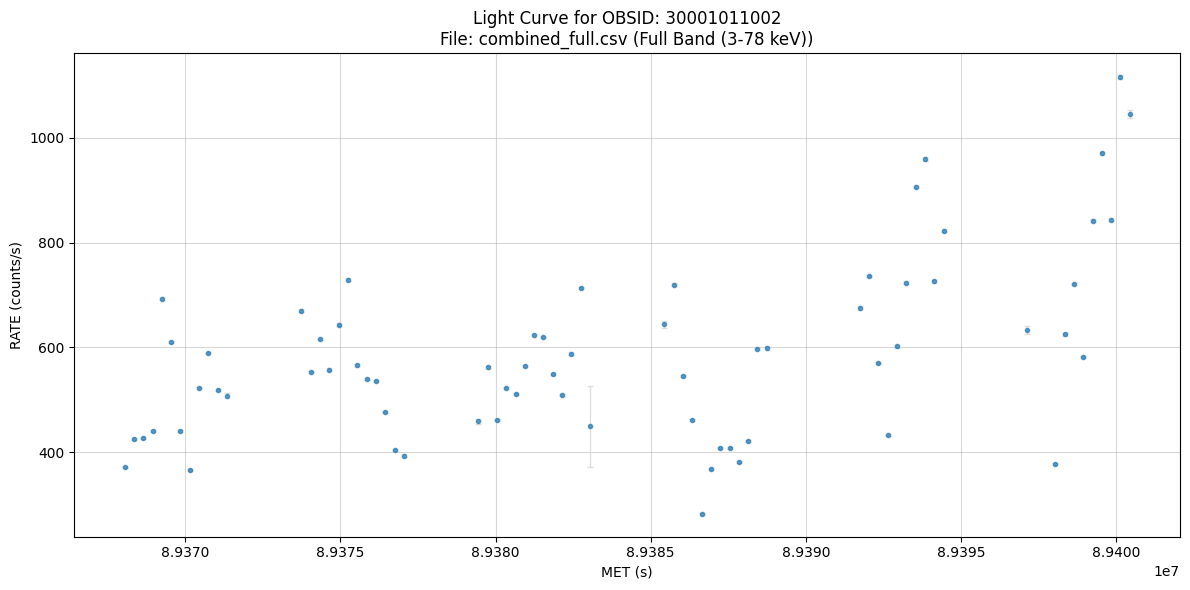

  Displayed light curve for OBSID 30001011002.
    Could not plot periodogram: No data for 30001011002 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30001011002, Period: 9026.84s ---
File: combined_full.csv (Full Band (3-78 keV))


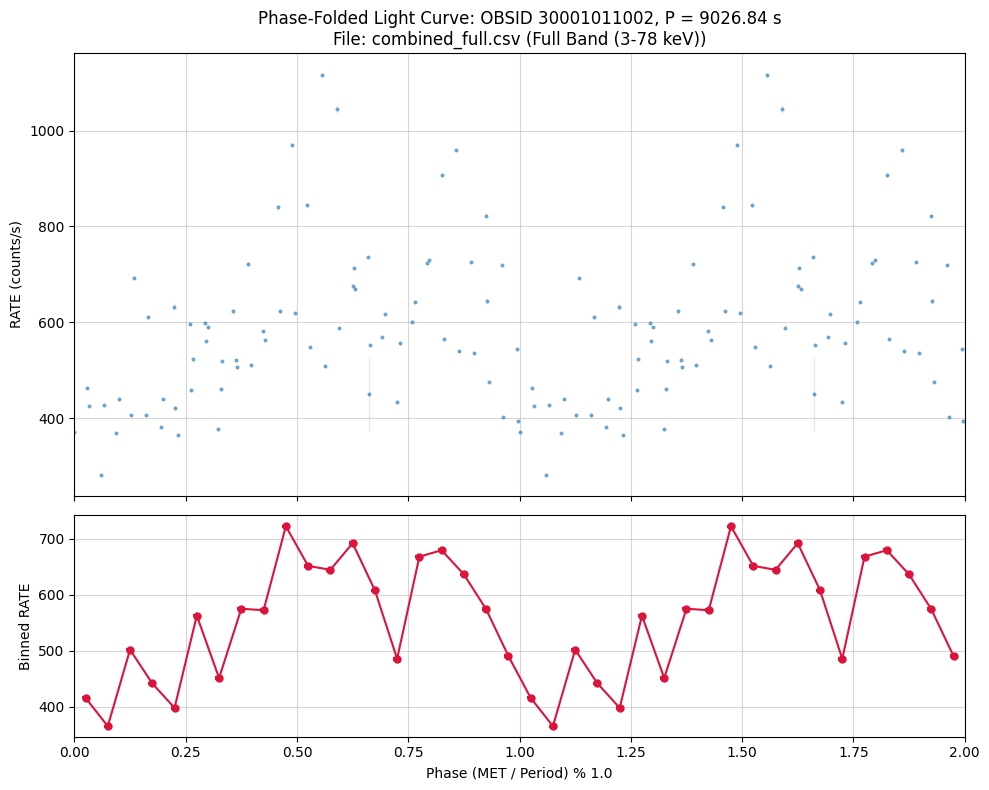

  Displayed phase-folded light curve for OBSID 30001011002.
== Finished Verifying OBSID: 30001011002 ==

== Verifying OBSID: 30001011005 ==

  -- Investigating Period ~75.11s for OBSID 30001011005 --

--- Plotting Light Curve for OBSID: 30001011005 from File: combined_full.csv (Full Band (3-78 keV)) ---


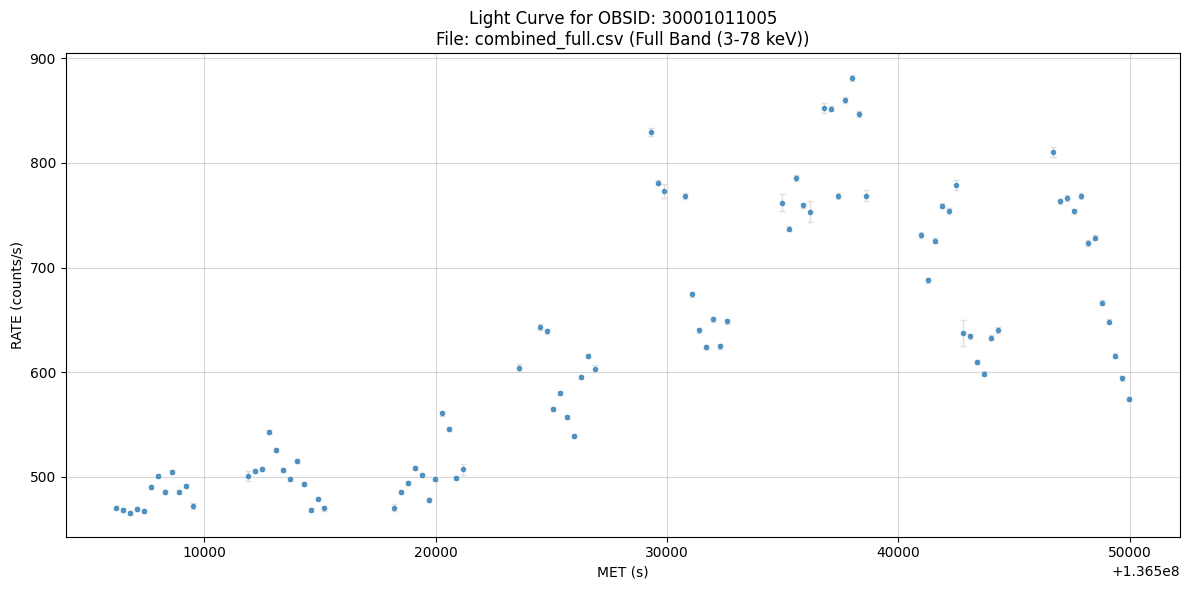

  Displayed light curve for OBSID 30001011005.
    Could not plot periodogram: No data for 30001011005 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30001011005, Period: 75.11s ---
File: combined_full.csv (Full Band (3-78 keV))


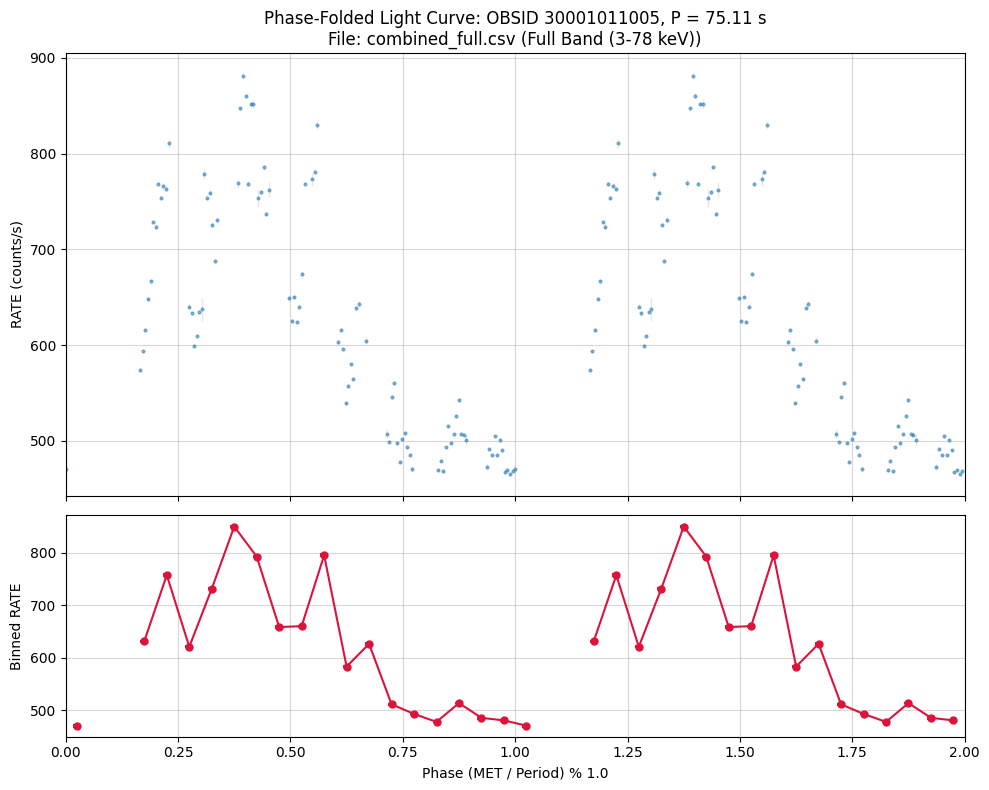

  Displayed phase-folded light curve for OBSID 30001011005.
== Finished Verifying OBSID: 30001011005 ==

== Verifying OBSID: 30001011007 ==

  -- Investigating Period ~150.37s for OBSID 30001011007 --

--- Plotting Light Curve for OBSID: 30001011007 from File: combined_full.csv (Full Band (3-78 keV)) ---


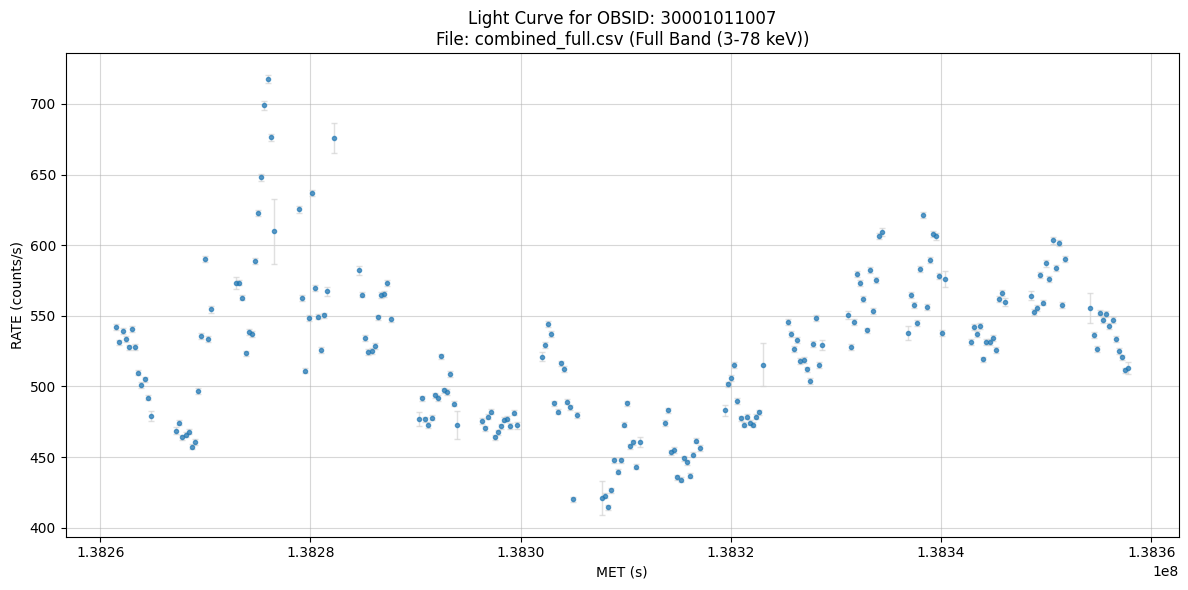

  Displayed light curve for OBSID 30001011007.
    Could not plot periodogram: No data for 30001011007 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30001011007, Period: 150.37s ---
File: combined_full.csv (Full Band (3-78 keV))


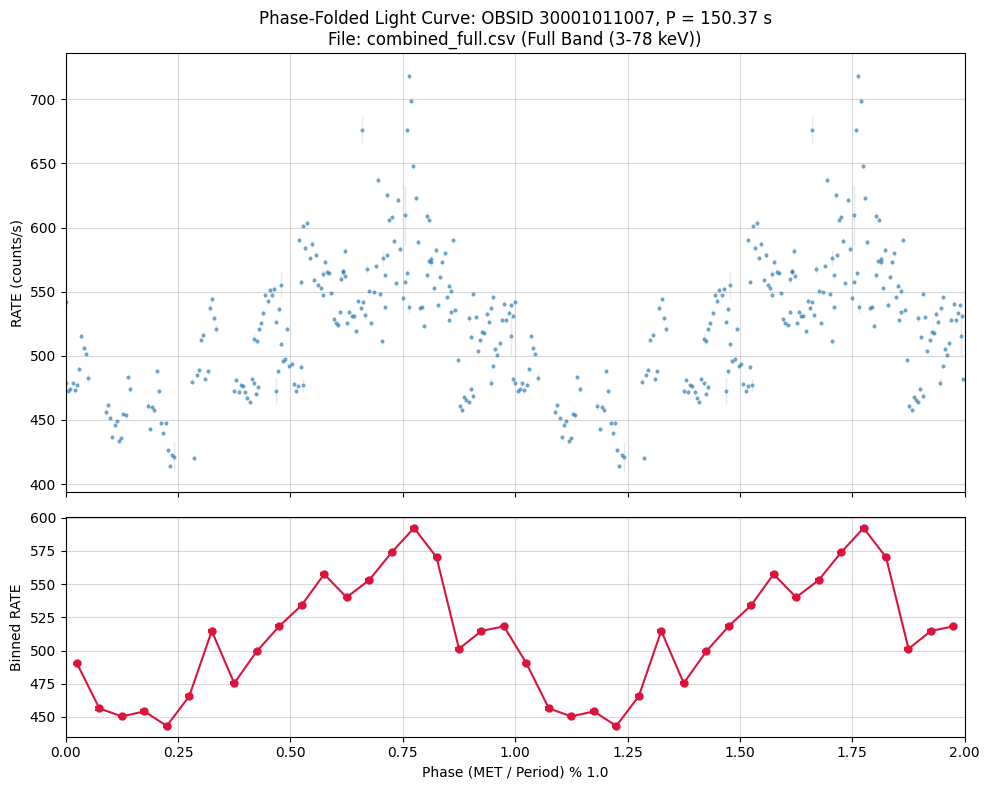

  Displayed phase-folded light curve for OBSID 30001011007.
== Finished Verifying OBSID: 30001011007 ==

== Verifying OBSID: 30001011009 ==

  -- Investigating Period ~302.54s for OBSID 30001011009 --

--- Plotting Light Curve for OBSID: 30001011009 from File: combined_full.csv (Full Band (3-78 keV)) ---


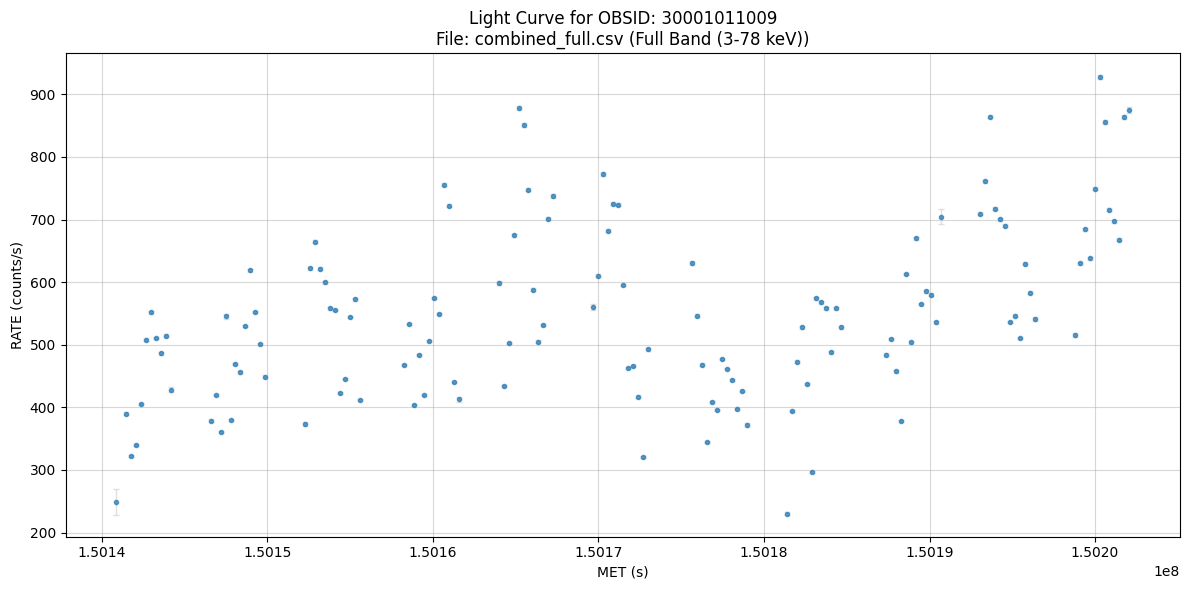

  Displayed light curve for OBSID 30001011009.
    Could not plot periodogram: No data for 30001011009 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30001011009, Period: 302.54s ---
File: combined_full.csv (Full Band (3-78 keV))


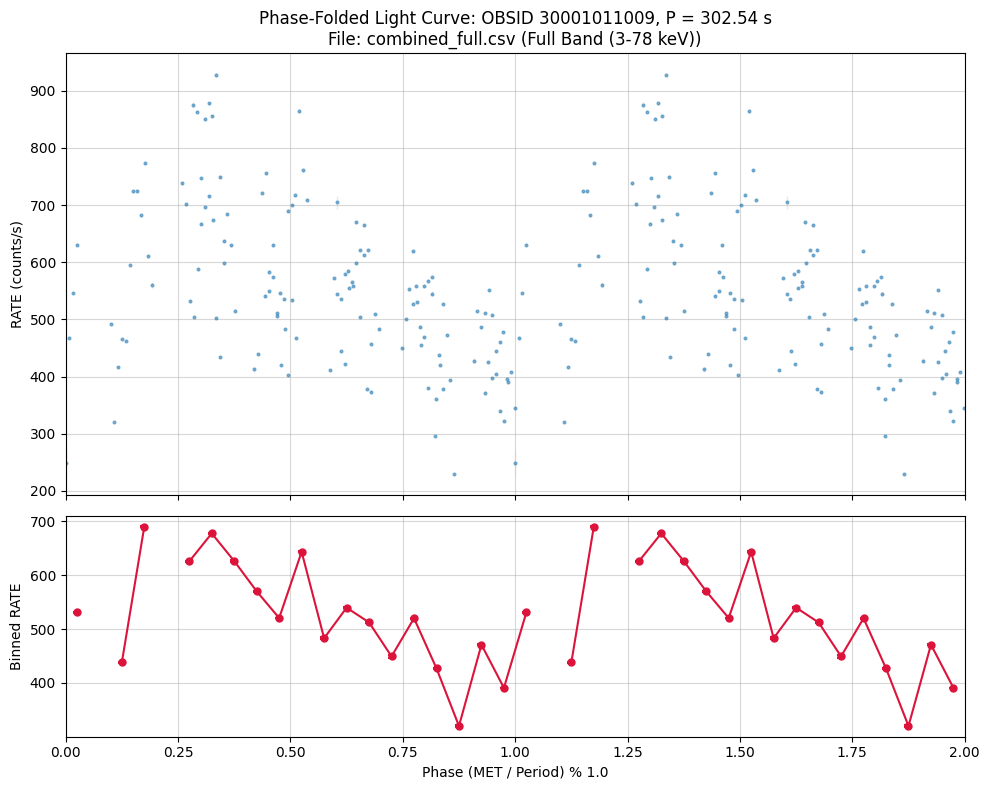

  Displayed phase-folded light curve for OBSID 30001011009.
== Finished Verifying OBSID: 30001011009 ==

== Verifying OBSID: 30001011011 ==

  -- Investigating Period ~50.05s for OBSID 30001011011 --

--- Plotting Light Curve for OBSID: 30001011011 from File: combined_full.csv (Full Band (3-78 keV)) ---


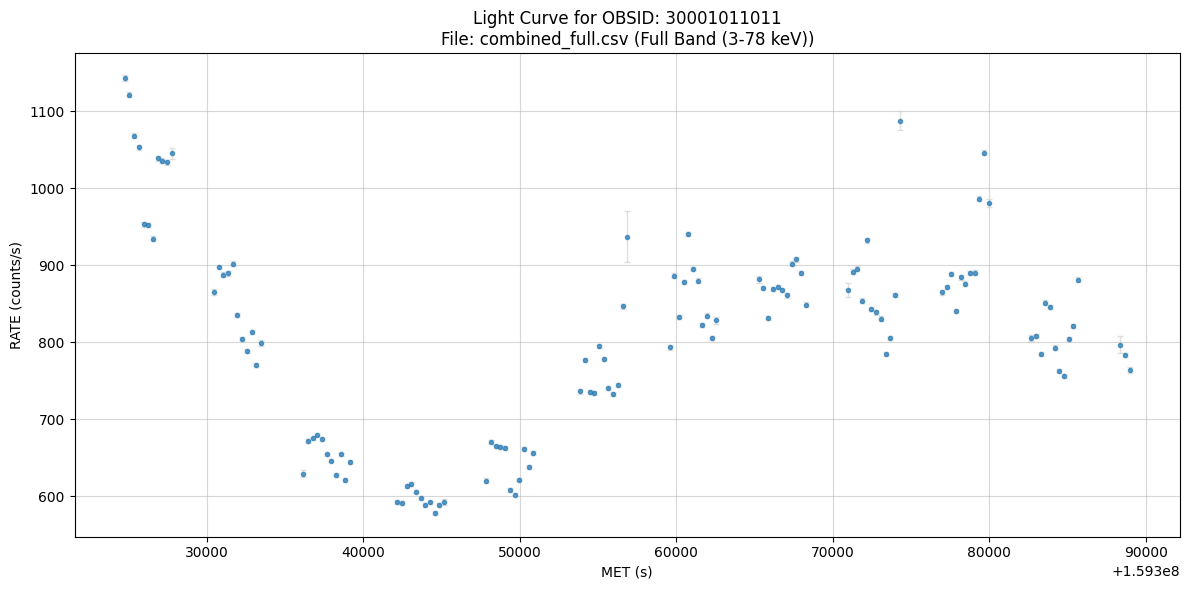

  Displayed light curve for OBSID 30001011011.
    Could not plot periodogram: No data for 30001011011 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30001011011, Period: 50.05s ---
File: combined_full.csv (Full Band (3-78 keV))


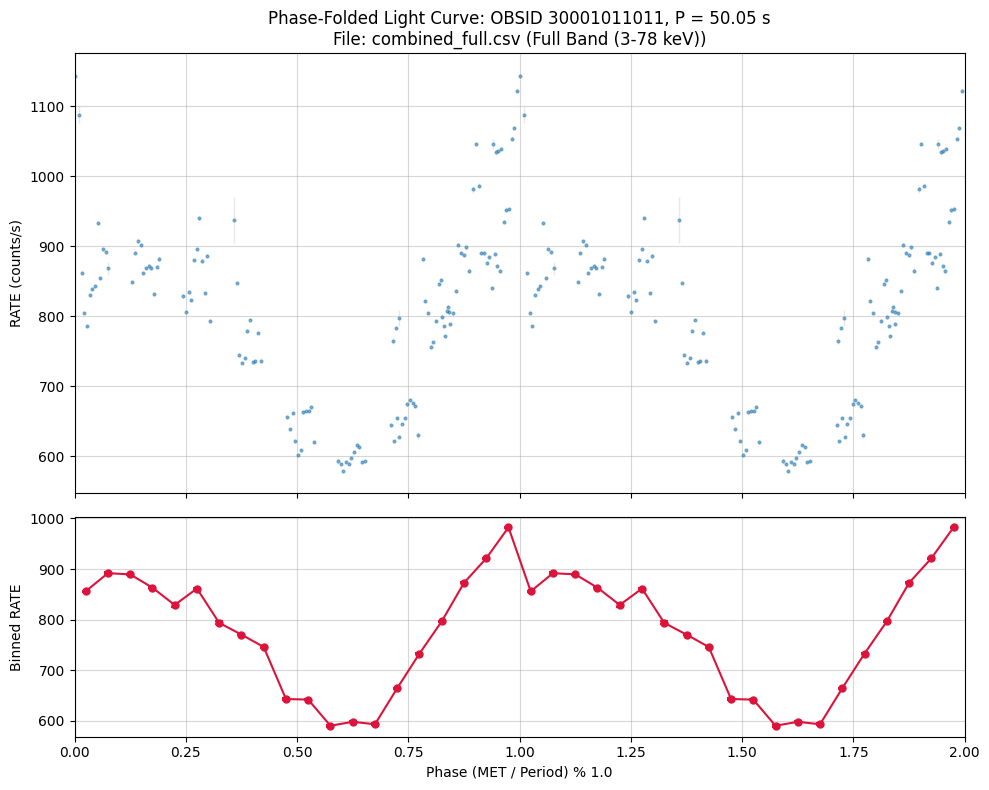

  Displayed phase-folded light curve for OBSID 30001011011.
== Finished Verifying OBSID: 30001011011 ==

== Verifying OBSID: 30002150002 ==

  -- Investigating Period ~99.91s for OBSID 30002150002 --

--- Plotting Light Curve for OBSID: 30002150002 from File: combined_full.csv (Full Band (3-78 keV)) ---


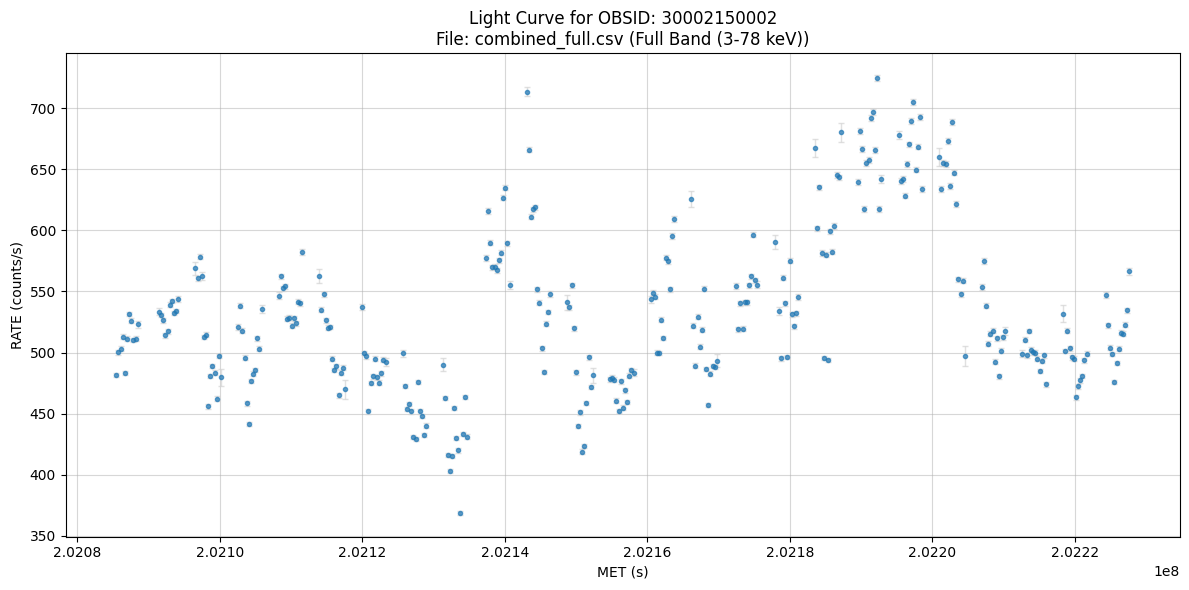

  Displayed light curve for OBSID 30002150002.
    Could not plot periodogram: No data for 30002150002 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30002150002, Period: 99.91s ---
File: combined_full.csv (Full Band (3-78 keV))


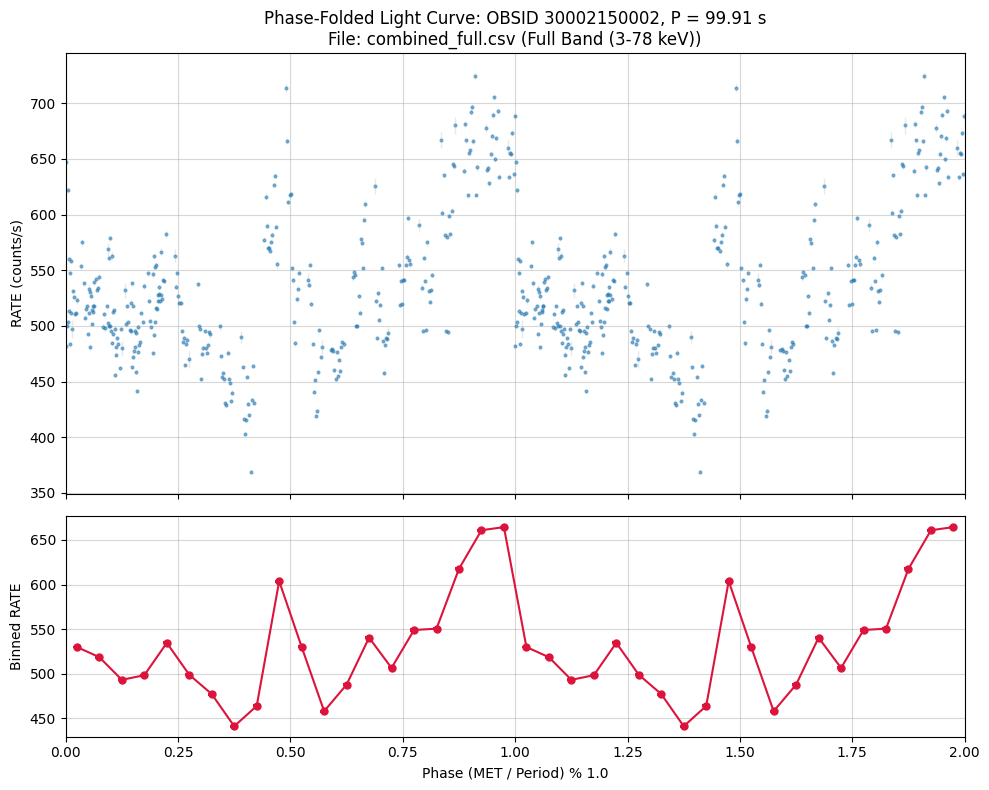

  Displayed phase-folded light curve for OBSID 30002150002.
== Finished Verifying OBSID: 30002150002 ==

== Verifying OBSID: 30002150004 ==

  -- Investigating Period ~74.97s for OBSID 30002150004 --

--- Plotting Light Curve for OBSID: 30002150004 from File: combined_full.csv (Full Band (3-78 keV)) ---


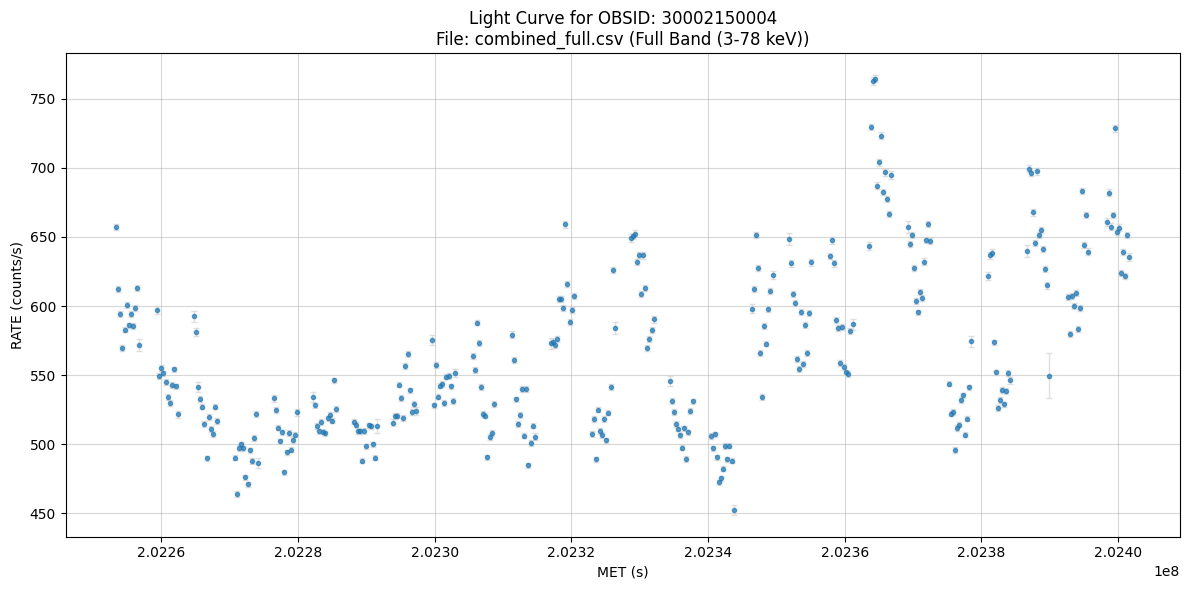

  Displayed light curve for OBSID 30002150004.
    Could not plot periodogram: No data for 30002150004 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30002150004, Period: 74.97s ---
File: combined_full.csv (Full Band (3-78 keV))


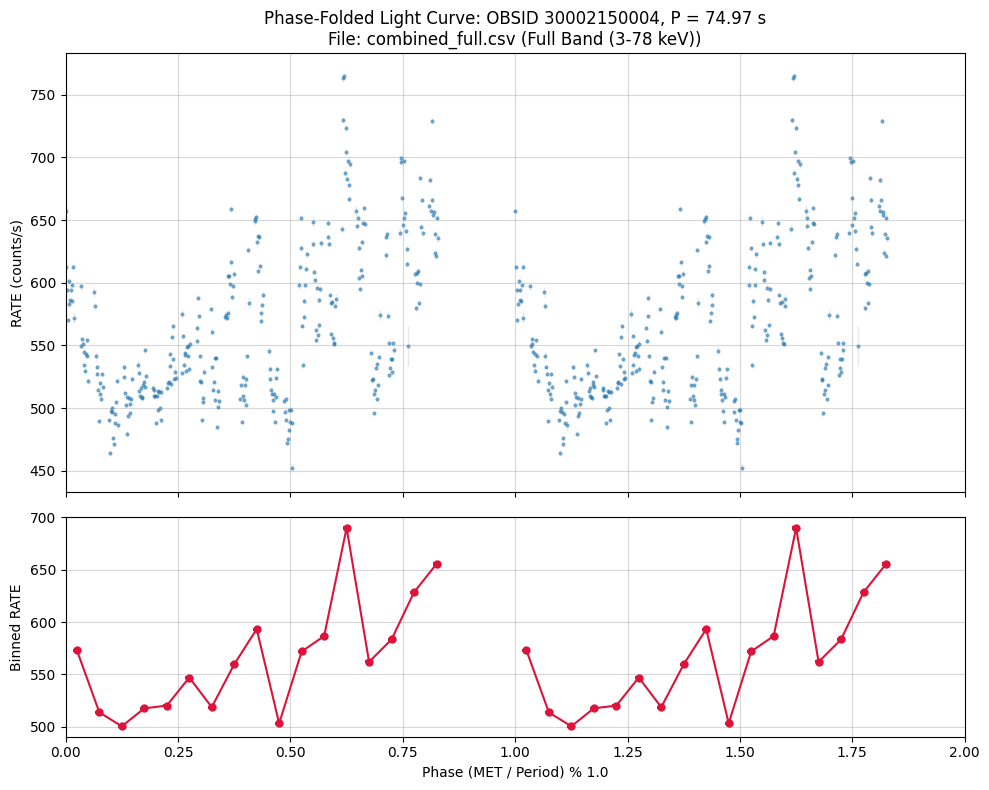

  Displayed phase-folded light curve for OBSID 30002150004.
== Finished Verifying OBSID: 30002150004 ==

== Verifying OBSID: 30002150008 ==

  -- Investigating Period ~75.07s for OBSID 30002150008 --

--- Plotting Light Curve for OBSID: 30002150008 from File: combined_full.csv (Full Band (3-78 keV)) ---


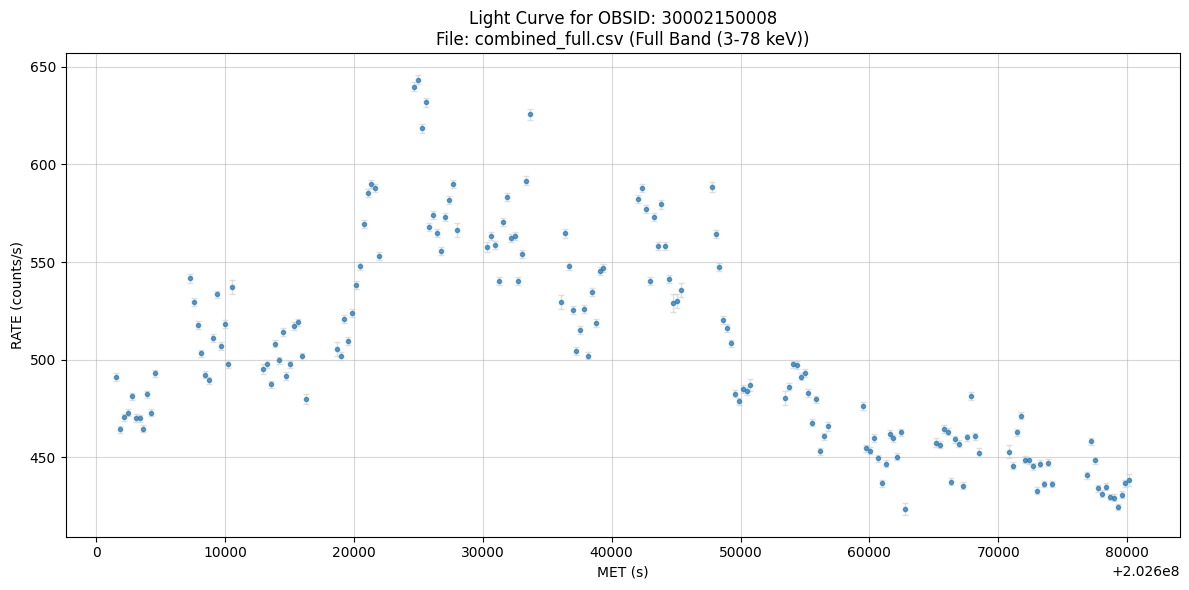

  Displayed light curve for OBSID 30002150008.
    Could not plot periodogram: No data for 30002150008 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30002150008, Period: 75.07s ---
File: combined_full.csv (Full Band (3-78 keV))


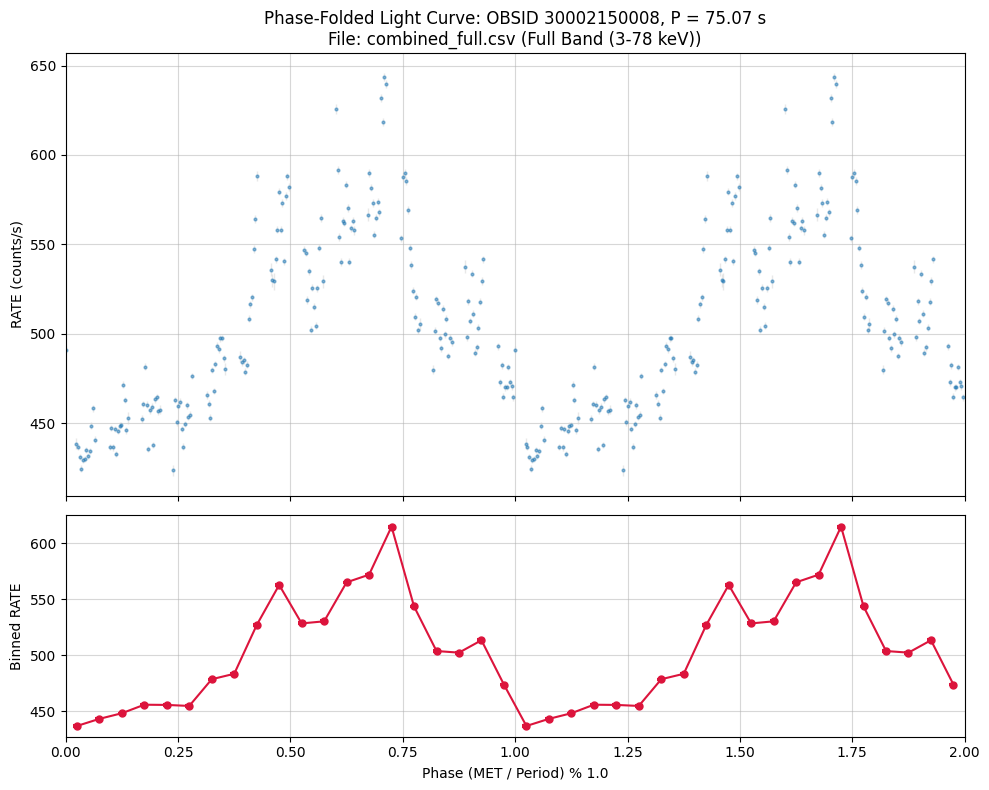

  Displayed phase-folded light curve for OBSID 30002150008.
== Finished Verifying OBSID: 30002150008 ==

== Verifying OBSID: 30202032002 ==

  -- Investigating Period ~75.10s for OBSID 30202032002 --

--- Plotting Light Curve for OBSID: 30202032002 from File: combined_full.csv (Full Band (3-78 keV)) ---


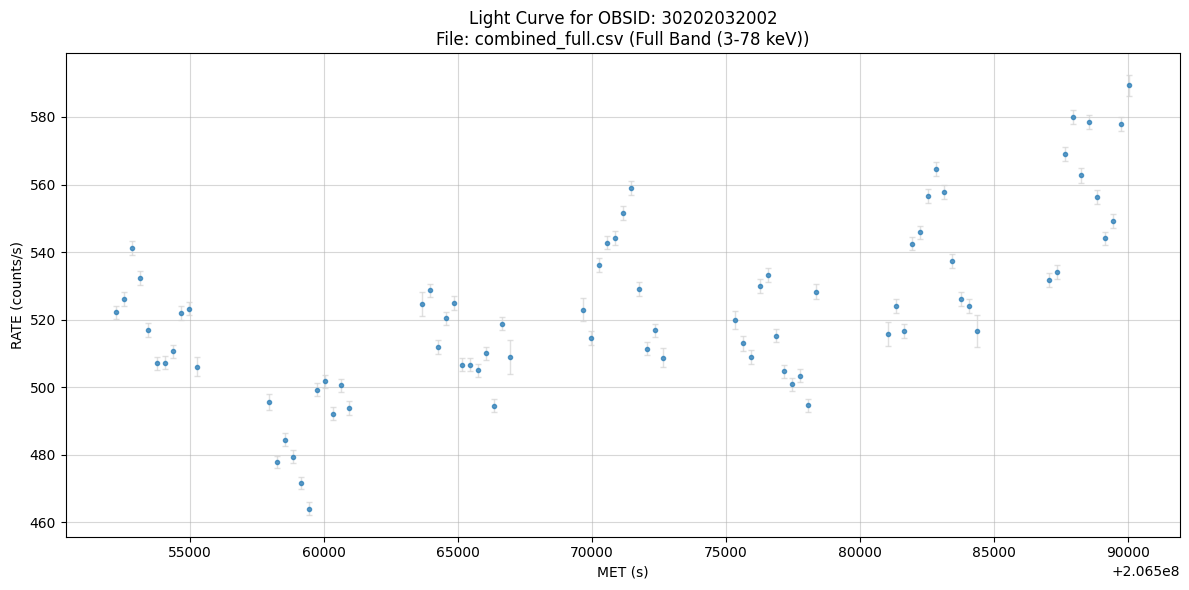

  Displayed light curve for OBSID 30202032002.
    Could not plot periodogram: No data for 30202032002 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30202032002, Period: 75.10s ---
File: combined_full.csv (Full Band (3-78 keV))


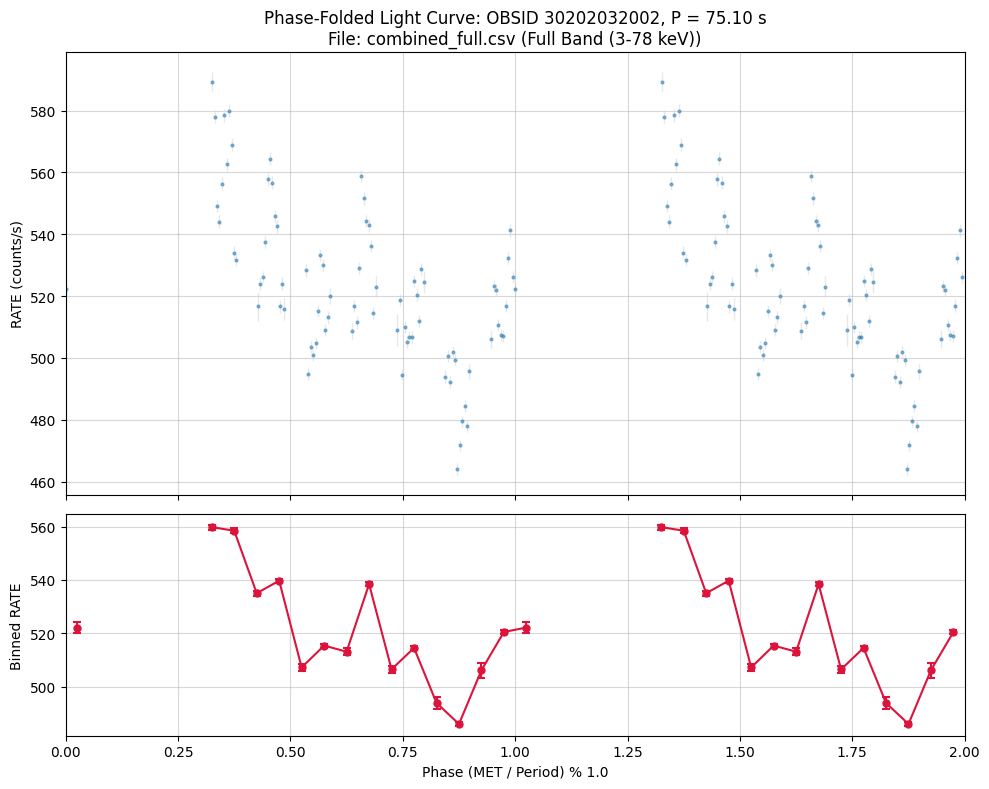

  Displayed phase-folded light curve for OBSID 30202032002.
== Finished Verifying OBSID: 30202032002 ==

== Verifying OBSID: 30302019004 ==

  -- Investigating Period ~100.72s for OBSID 30302019004 --

--- Plotting Light Curve for OBSID: 30302019004 from File: combined_full.csv (Full Band (3-78 keV)) ---


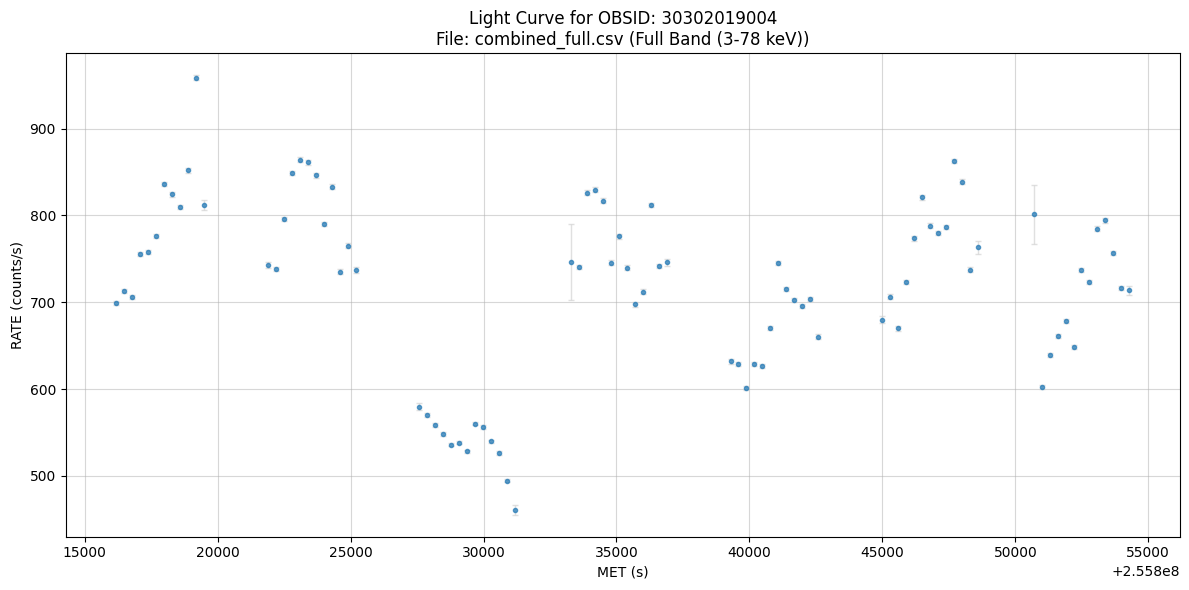

  Displayed light curve for OBSID 30302019004.
    Could not plot periodogram: No data for 30302019004 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30302019004, Period: 100.72s ---
File: combined_full.csv (Full Band (3-78 keV))


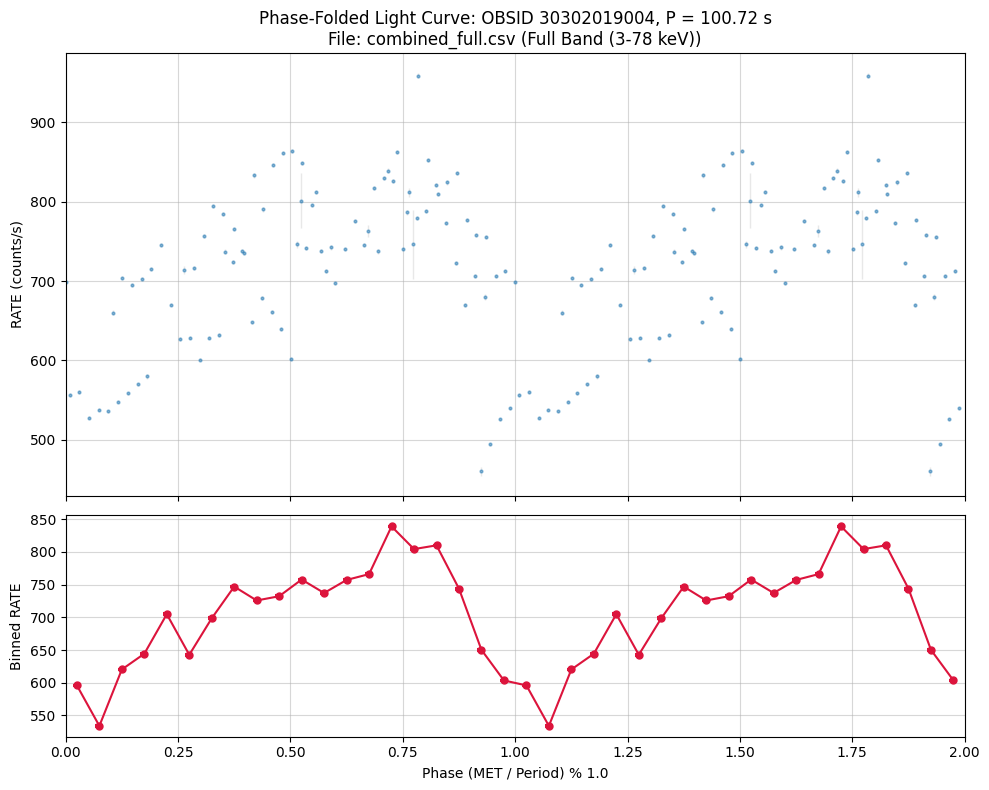

  Displayed phase-folded light curve for OBSID 30302019004.
== Finished Verifying OBSID: 30302019004 ==

== Verifying OBSID: 30302019012 ==

  -- Investigating Period ~302.01s for OBSID 30302019012 --

--- Plotting Light Curve for OBSID: 30302019012 from File: combined_full.csv (Full Band (3-78 keV)) ---


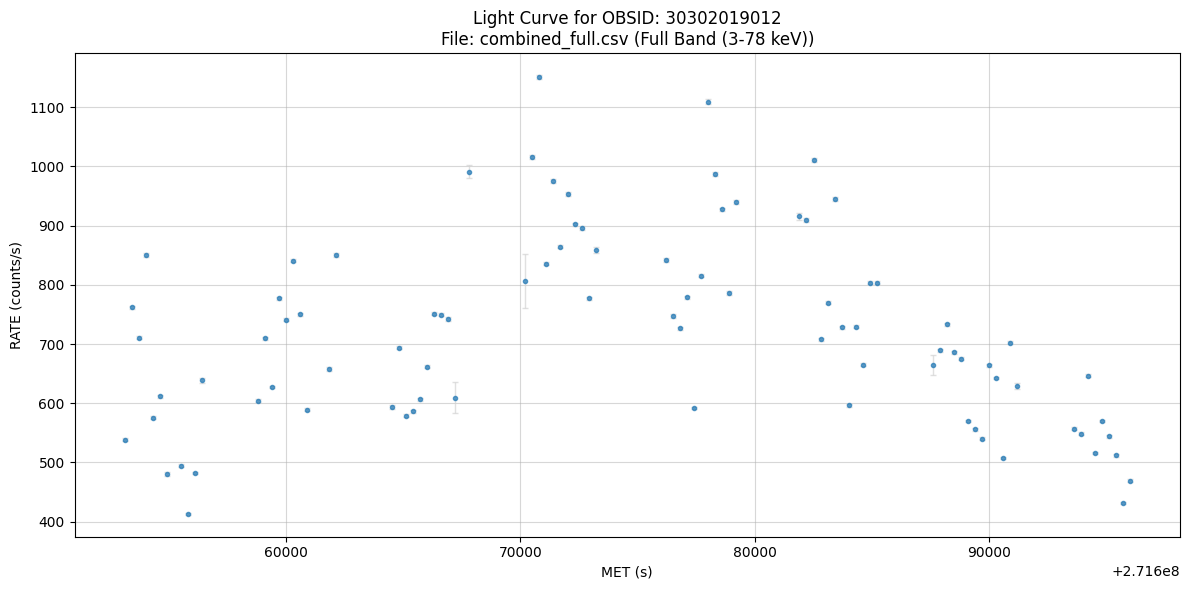

  Displayed light curve for OBSID 30302019012.
    Could not plot periodogram: No data for 30302019012 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30302019012, Period: 302.01s ---
File: combined_full.csv (Full Band (3-78 keV))


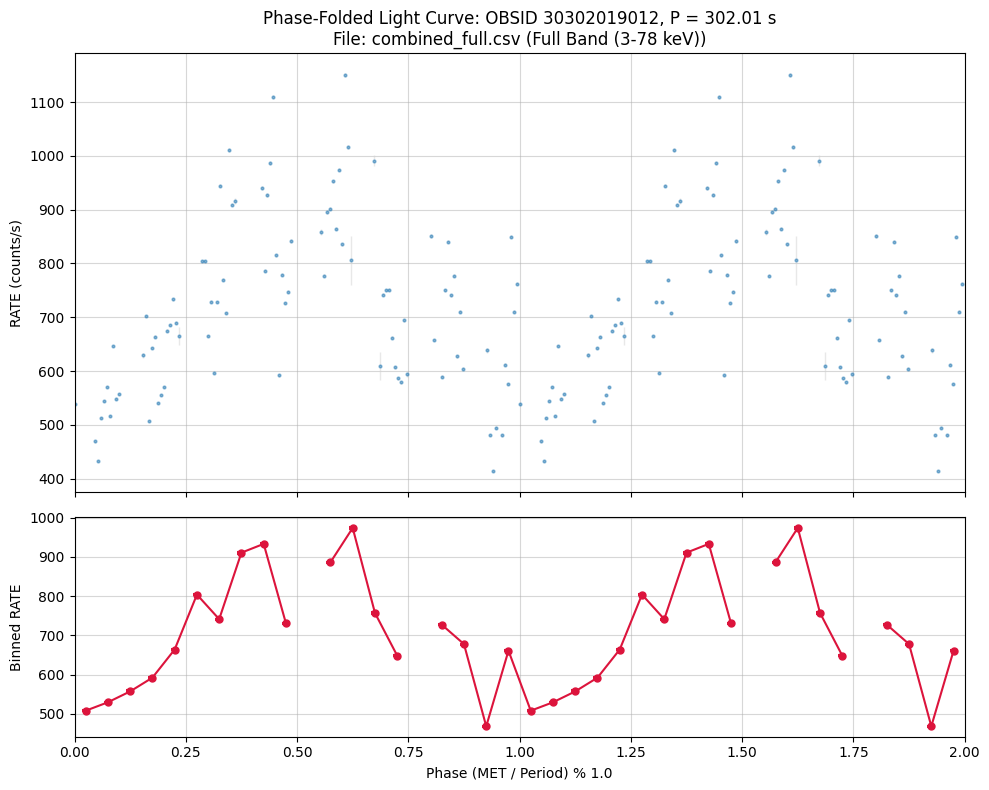

  Displayed phase-folded light curve for OBSID 30302019012.
== Finished Verifying OBSID: 30302019012 ==

== Verifying OBSID: 30702017006 ==

  -- Investigating Period ~75.21s for OBSID 30702017006 --

--- Plotting Light Curve for OBSID: 30702017006 from File: combined_full.csv (Full Band (3-78 keV)) ---


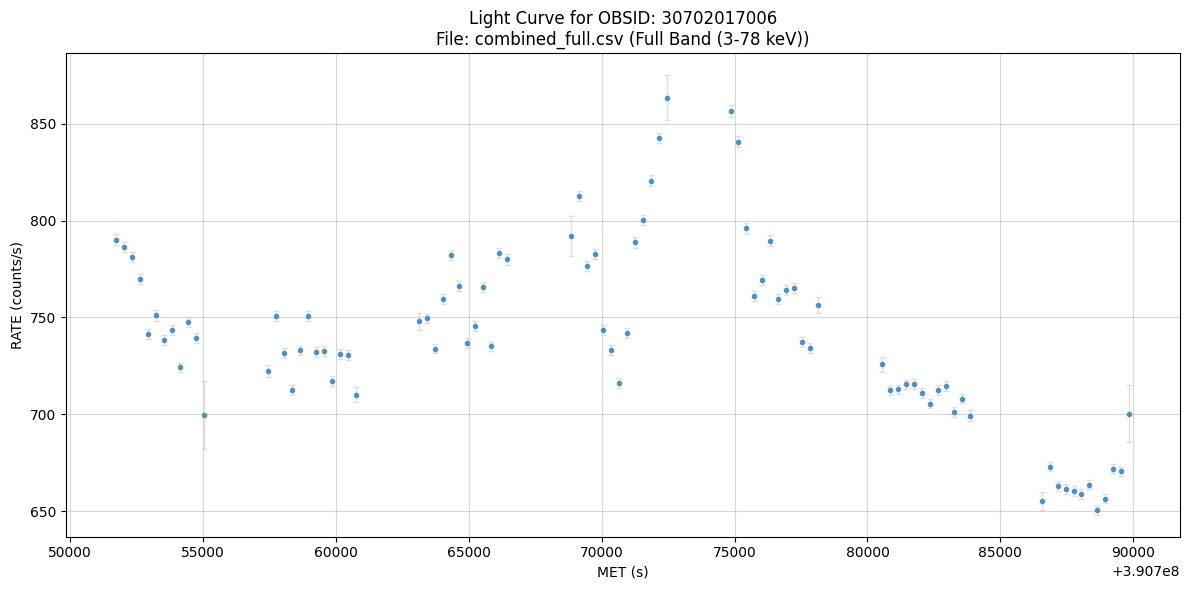

  Displayed light curve for OBSID 30702017006.
    Could not plot periodogram: No data for 30702017006 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30702017006, Period: 75.21s ---
File: combined_full.csv (Full Band (3-78 keV))


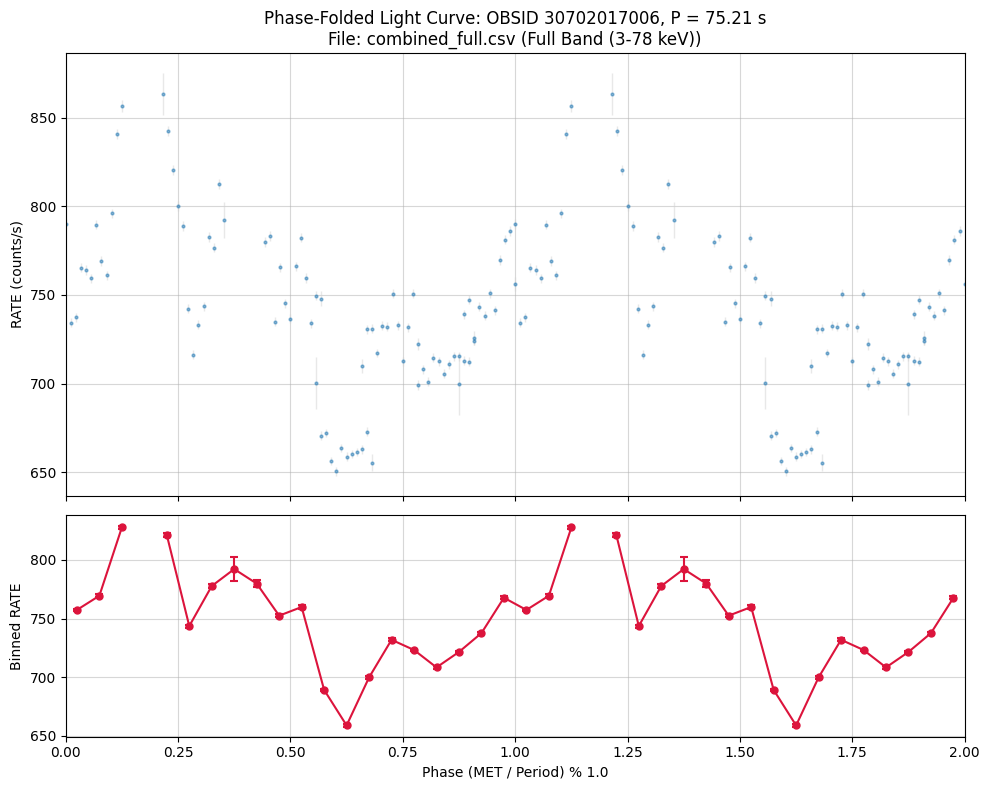

  Displayed phase-folded light curve for OBSID 30702017006.
== Finished Verifying OBSID: 30702017006 ==

== Verifying OBSID: 30901039002 ==

  -- Investigating Period ~60.05s for OBSID 30901039002 --

--- Plotting Light Curve for OBSID: 30901039002 from File: combined_full.csv (Full Band (3-78 keV)) ---


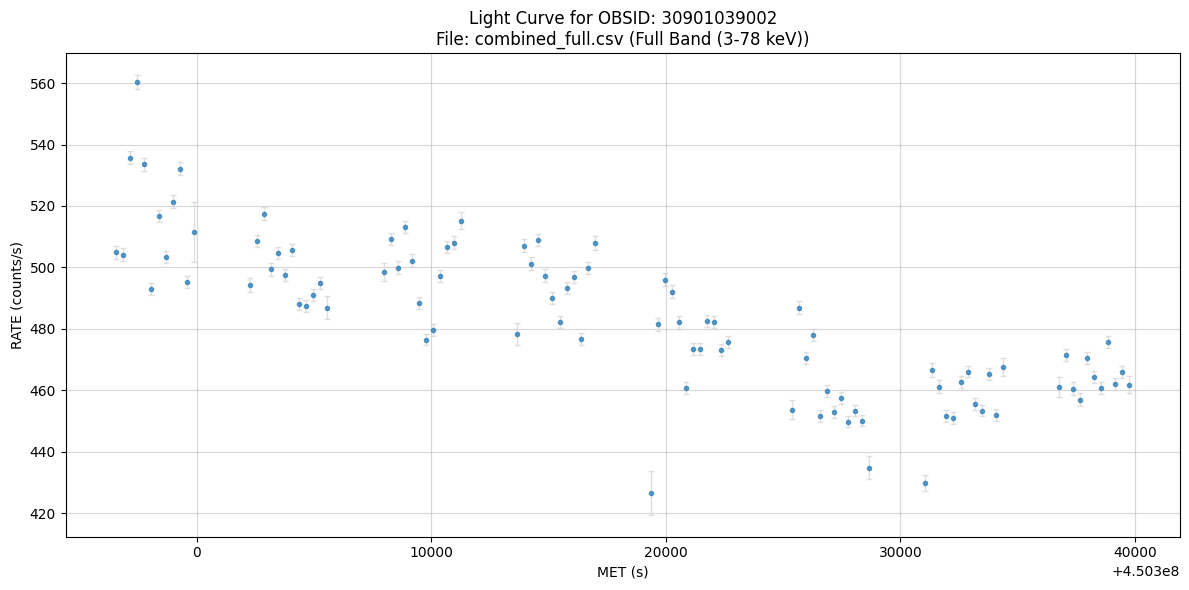

  Displayed light curve for OBSID 30901039002.
    Could not plot periodogram: No data for 30901039002 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 30901039002, Period: 60.05s ---
File: combined_full.csv (Full Band (3-78 keV))


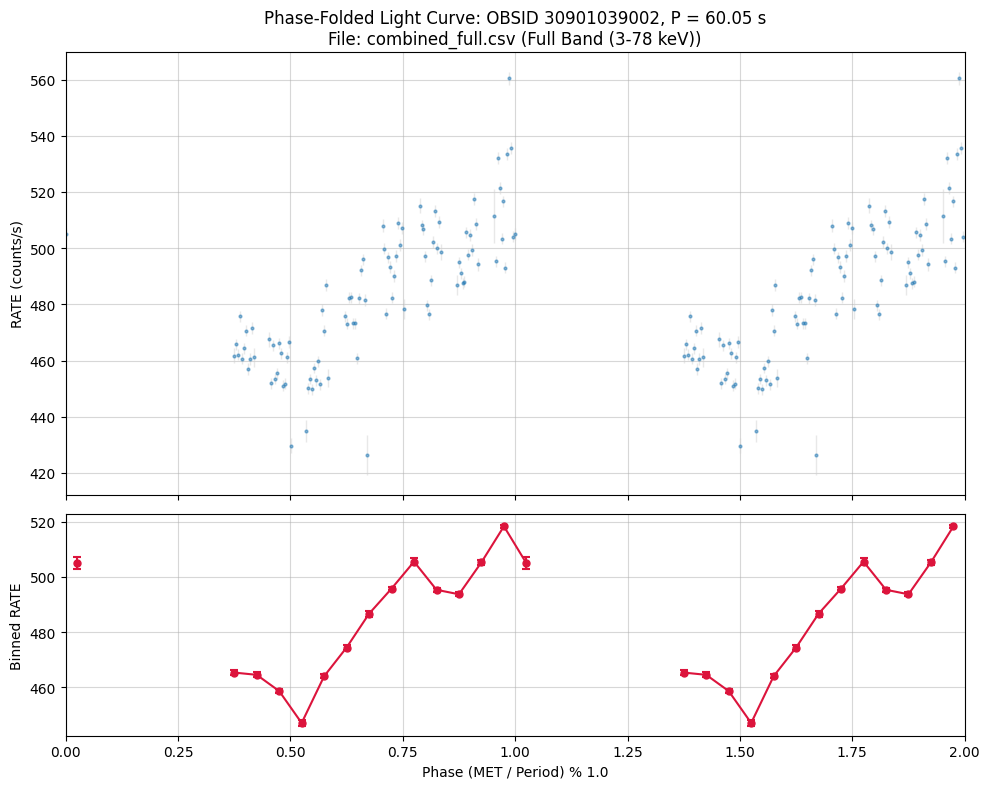

  Displayed phase-folded light curve for OBSID 30901039002.
== Finished Verifying OBSID: 30901039002 ==

== Verifying OBSID: 80502335002 ==

  -- Investigating Period ~150.61s for OBSID 80502335002 --

--- Plotting Light Curve for OBSID: 80502335002 from File: combined_full.csv (Full Band (3-78 keV)) ---


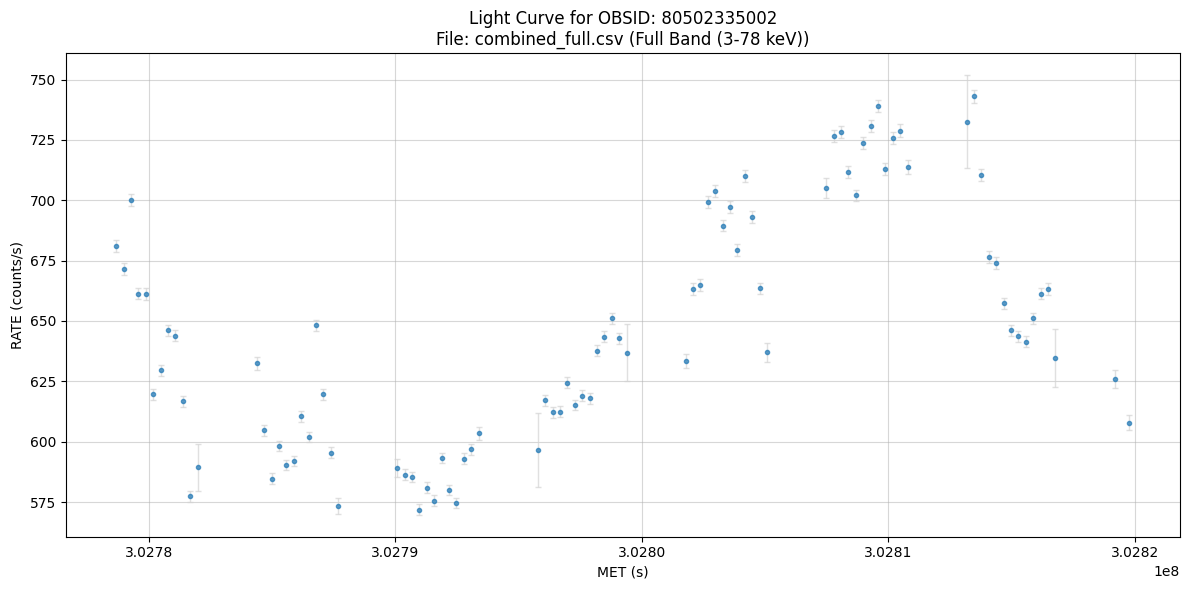

  Displayed light curve for OBSID 80502335002.
    Could not plot periodogram: No data for 80502335002 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 80502335002, Period: 150.61s ---
File: combined_full.csv (Full Band (3-78 keV))


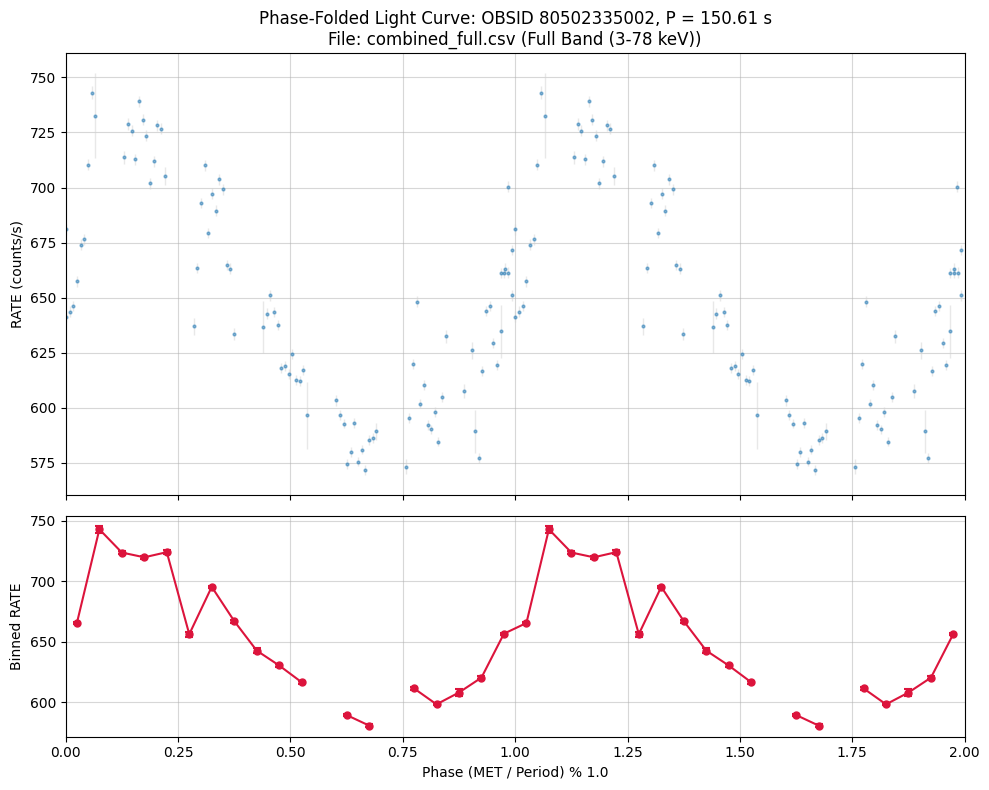

  Displayed phase-folded light curve for OBSID 80502335002.
== Finished Verifying OBSID: 80502335002 ==

== Verifying OBSID: 80902318002 ==

  -- Investigating Period ~152.24s for OBSID 80902318002 --

--- Plotting Light Curve for OBSID: 80902318002 from File: combined_full.csv (Full Band (3-78 keV)) ---


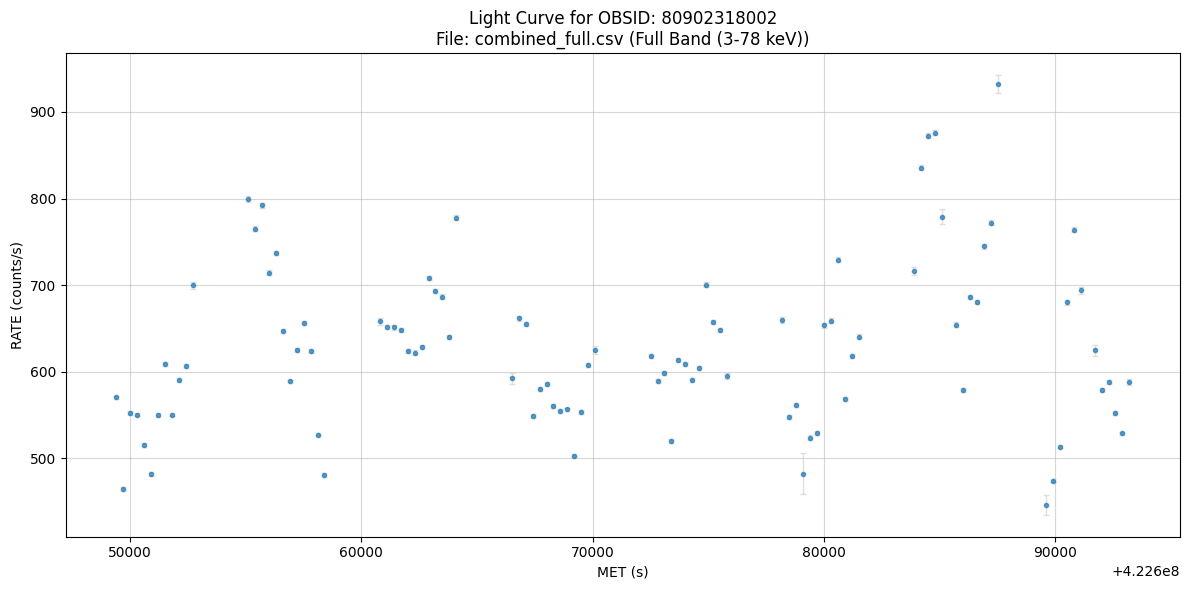

  Displayed light curve for OBSID 80902318002.
    Could not plot periodogram: No data for 80902318002 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 80902318002, Period: 152.24s ---
File: combined_full.csv (Full Band (3-78 keV))


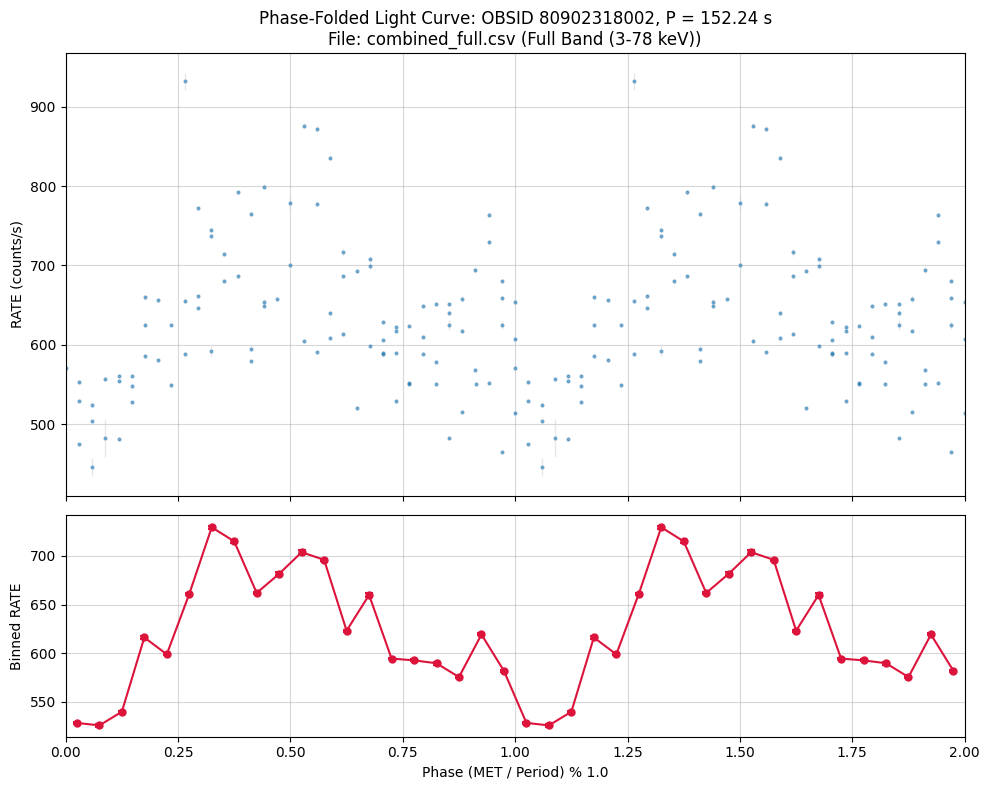

  Displayed phase-folded light curve for OBSID 80902318002.
== Finished Verifying OBSID: 80902318002 ==

== Verifying OBSID: 80902318004 ==

  -- Investigating Period ~59.94s for OBSID 80902318004 --

--- Plotting Light Curve for OBSID: 80902318004 from File: combined_full.csv (Full Band (3-78 keV)) ---


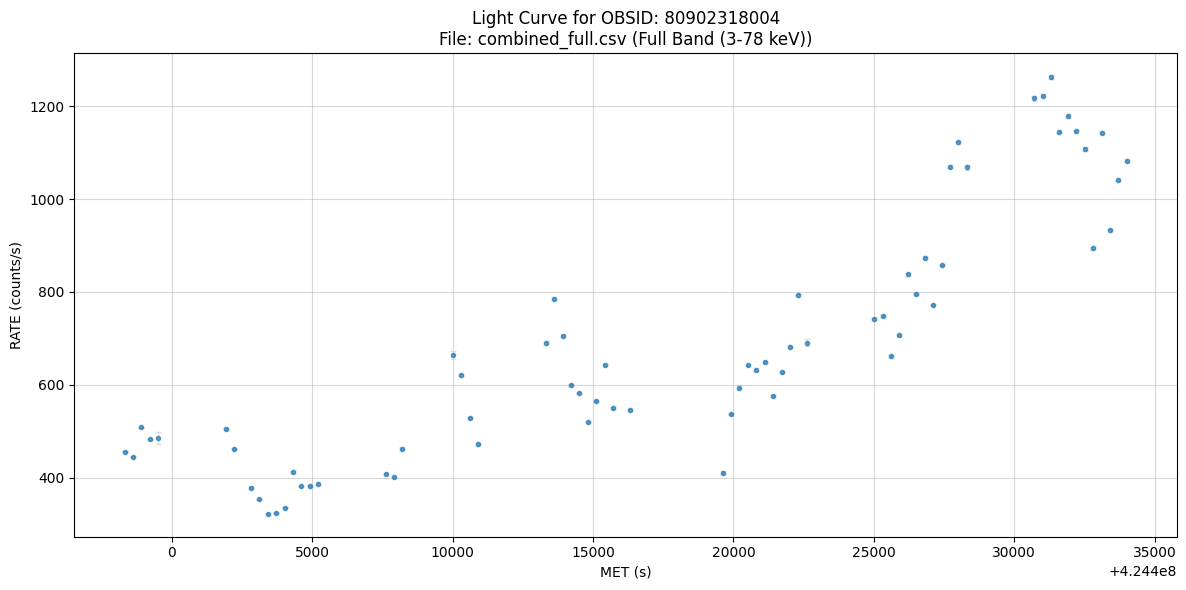

  Displayed light curve for OBSID 80902318004.
    Could not plot periodogram: No data for 80902318004 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 80902318004, Period: 59.94s ---
File: combined_full.csv (Full Band (3-78 keV))


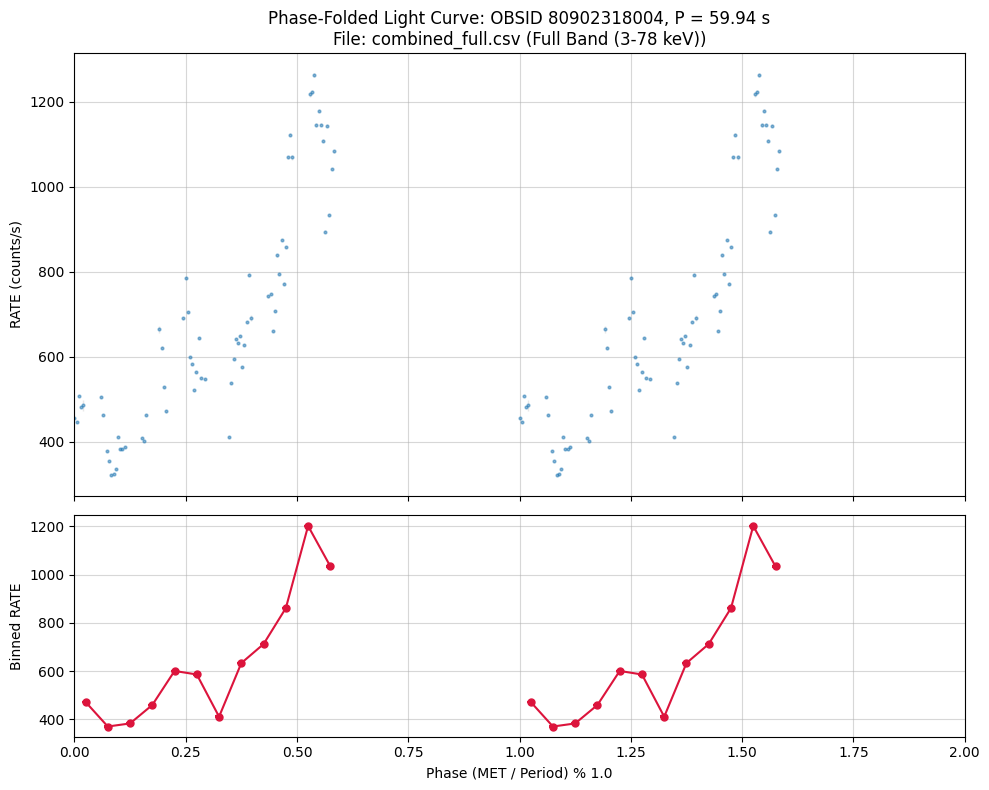

  Displayed phase-folded light curve for OBSID 80902318004.
== Finished Verifying OBSID: 80902318004 ==

== Verifying OBSID: 90101020002 ==

  -- Investigating Period ~149.83s for OBSID 90101020002 --

--- Plotting Light Curve for OBSID: 90101020002 from File: combined_full.csv (Full Band (3-78 keV)) ---


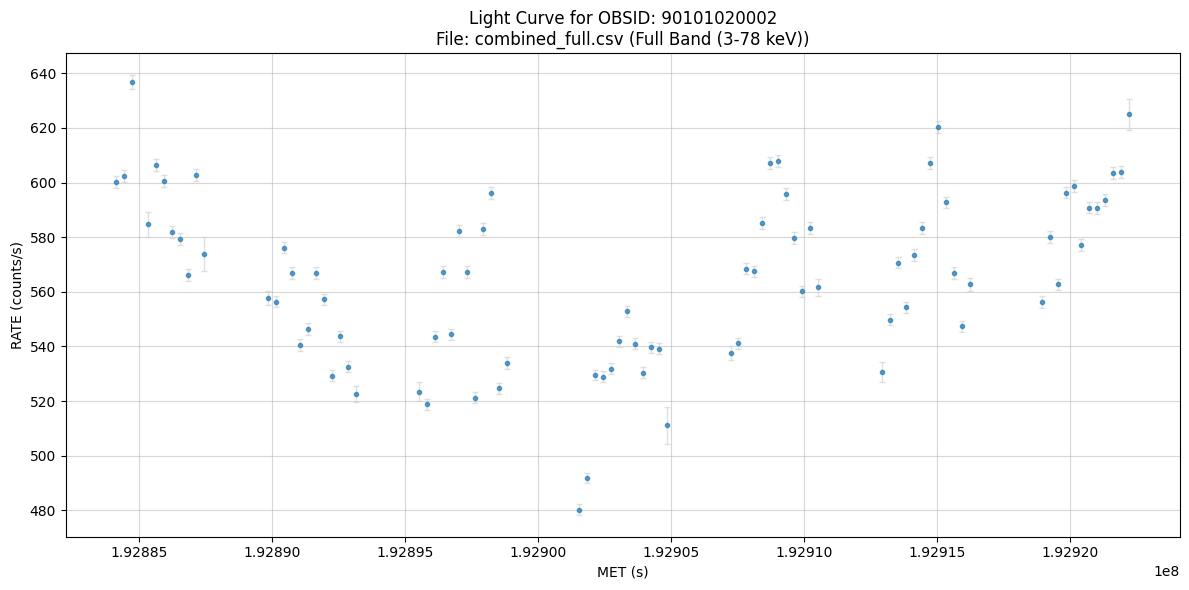

  Displayed light curve for OBSID 90101020002.
    Could not plot periodogram: No data for 90101020002 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 90101020002, Period: 149.83s ---
File: combined_full.csv (Full Band (3-78 keV))


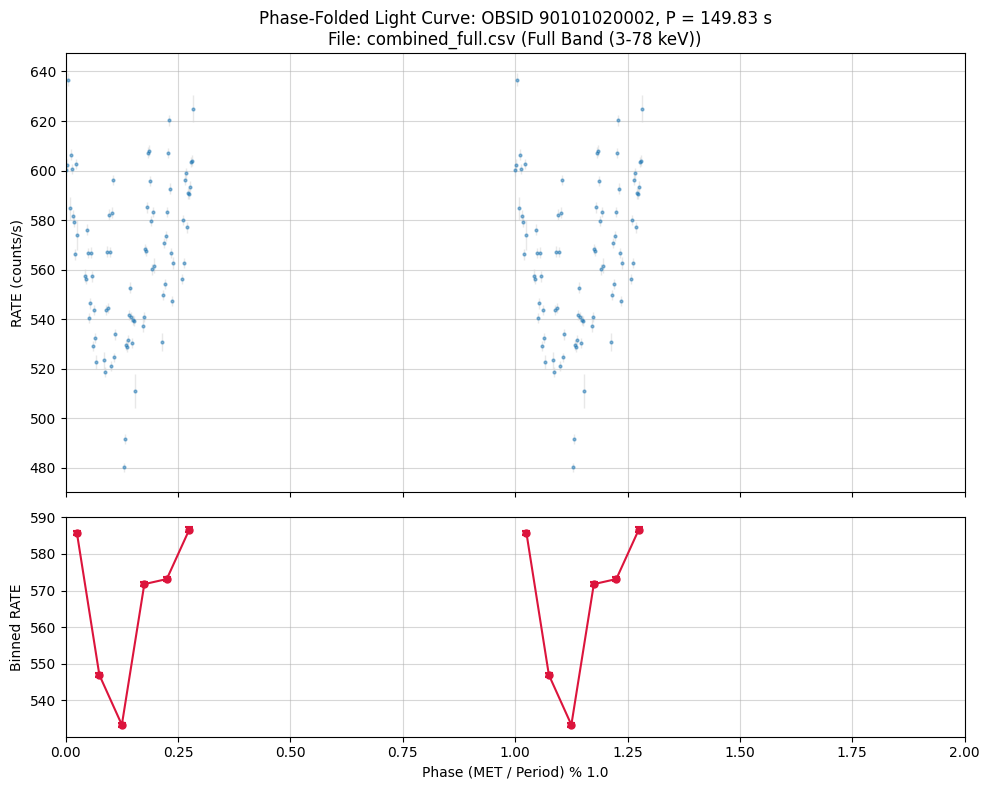

  Displayed phase-folded light curve for OBSID 90101020002.
== Finished Verifying OBSID: 90101020002 ==

== Verifying OBSID: 90802013002 ==

  -- Investigating Period ~150.58s for OBSID 90802013002 --

--- Plotting Light Curve for OBSID: 90802013002 from File: combined_full.csv (Full Band (3-78 keV)) ---


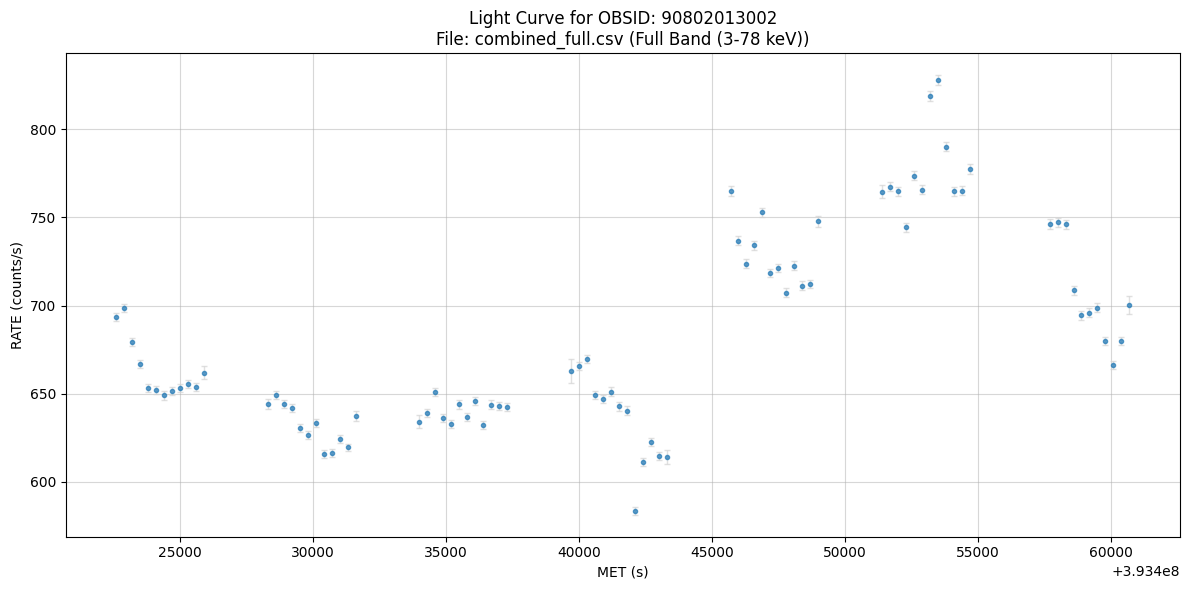

  Displayed light curve for OBSID 90802013002.
    Could not plot periodogram: No data for 90802013002 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 90802013002, Period: 150.58s ---
File: combined_full.csv (Full Band (3-78 keV))


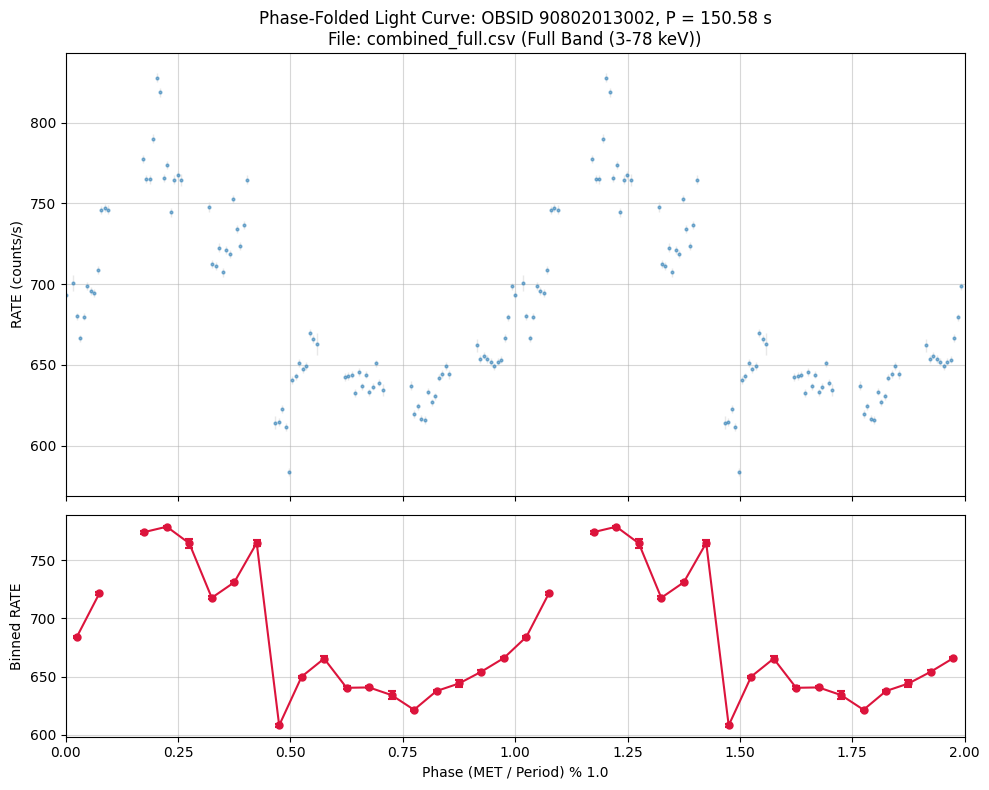

  Displayed phase-folded light curve for OBSID 90802013002.
== Finished Verifying OBSID: 90802013002 ==

== Verifying OBSID: 90802013004 ==

  -- Investigating Period ~73.99s for OBSID 90802013004 --

--- Plotting Light Curve for OBSID: 90802013004 from File: combined_full.csv (Full Band (3-78 keV)) ---


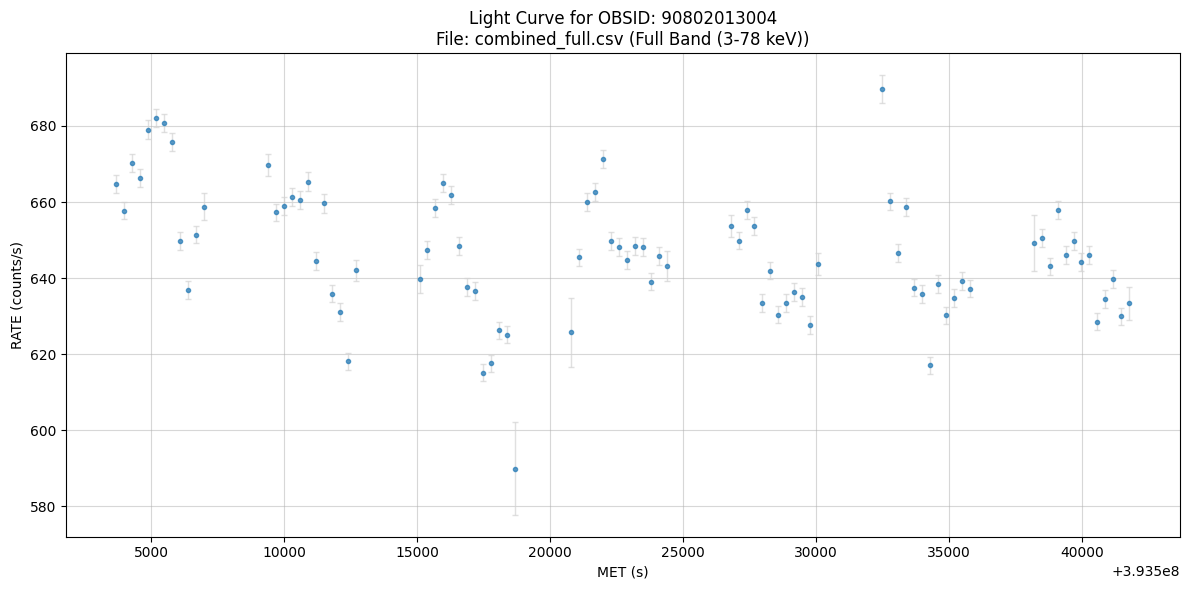

  Displayed light curve for OBSID 90802013004.
    Could not plot periodogram: No data for 90802013004 in combined_full.csv

--- Plotting Phase-Folded Light Curve for OBSID: 90802013004, Period: 73.99s ---
File: combined_full.csv (Full Band (3-78 keV))


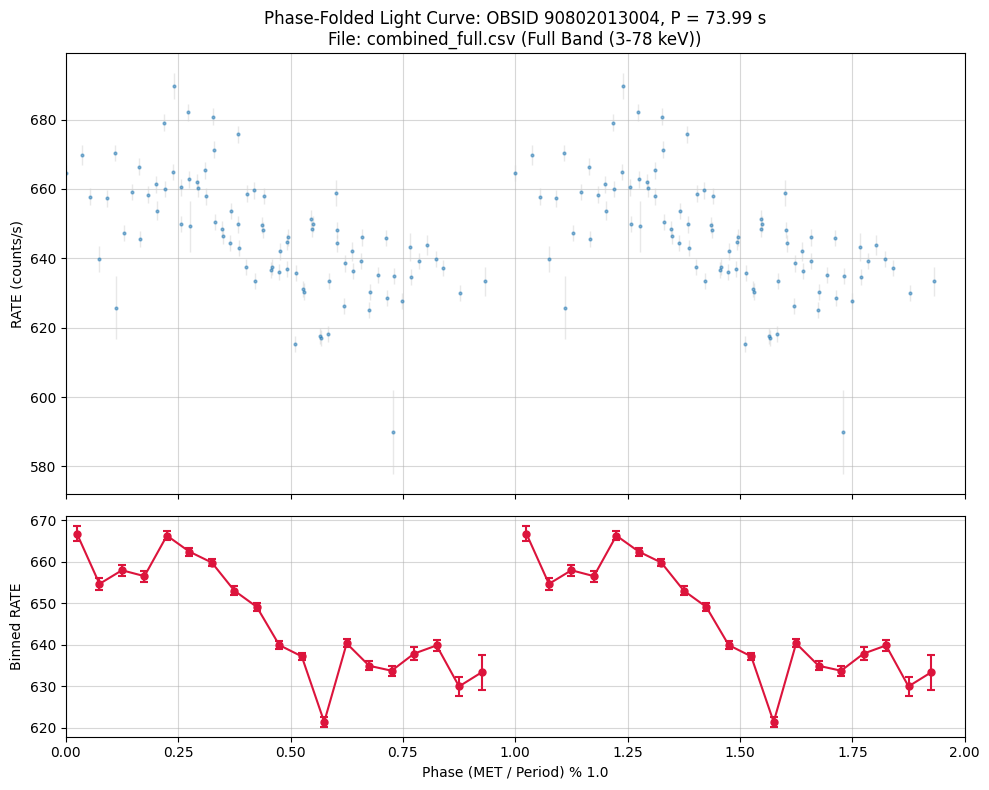

  Displayed phase-folded light curve for OBSID 90802013004.
== Finished Verifying OBSID: 90802013004 ==

Auto-plotting finished for 19 consistent OBSID/period combinations.

--- Manual Plotting Examples (Still Available) ---
You can still manually call the plotting functions for any specific OBSID.
Example 1: plot_light_curve(loaded_dataframes['combined_hard.csv'], '30001011007', 'combined_hard.csv', energy_bands_map['combined_hard.csv'])
Example 2: plot_phase_folded_light_curve(loaded_dataframes['combined_hard.csv'], '30001011007', 150.37, 'combined_hard.csv', energy_bands_map['combined_hard.csv'])
Example 3: Plotting periodogram requires the DataFrame slice:
obsid_for_lsp = '30001011007'
file_for_lsp = 'combined_hard.csv'
if loaded_dataframes.get(file_for_lsp) is not None:
    df_obs = loaded_dataframes[file_for_lsp][loaded_dataframes[file_for_lsp]['OBSID'] == obsid_for_lsp]
    if not df_obs.empty:
        plot_specific_obsid_periodogram(df_obs, obsid_for_lsp, file_for_lsp, energy_b

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle # Using scipy as per the user's last run script
import time

# --- Configuration from the user's Scipy-based script & for this toolkit ---
# Ensure these match the settings used when 'all_results' was generated
FAP_THRESHOLD = 0.01  # Report OBSIDs if FAP of highest peak is below this
N_BOOTSTRAP_ITERATIONS = 1000 # Used if re-calculating FAP (e.g. in periodogram plot)
MIN_PERIOD_TO_SEARCH_S = 50.0
MIN_DATA_POINTS_FOR_LSP = 10

# Toolkit-specific configuration
PERIOD_TOLERANCE_PERCENT = 10.0 # Percentage tolerance for considering periods "similar" across bands
PHASE_BINS = 20 # Number of bins for binned phase-folded light curve

# --- Functions for periodogram plotting (re-analysis for visualization) ---
def calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, observed_peak_power, n_bootstraps):
    """ Estimates False Alarm Probability (FAP) using bootstrap. """
    if len(t) < MIN_DATA_POINTS_FOR_LSP: return 1.0
    bootstrap_peak_powers = []
    for _ in range(n_bootstraps):
        y_shuffled = np.random.permutation(y_mean_subtracted)
        # Ensure ang_freqs is not empty and has valid range before calling lombscargle
        if len(ang_freqs) == 0 or ang_freqs.max() <= ang_freqs.min():
            return 1.0 # Cannot calculate FAP
        power_shuffled = lombscargle(t, y_shuffled, ang_freqs, normalize=True)
        if len(power_shuffled) > 0:
            bootstrap_peak_powers.append(np.max(power_shuffled))
        else:
            pass

    if not bootstrap_peak_powers:
        return 1.0

    false_alarms = np.sum(np.array(bootstrap_peak_powers) >= observed_peak_power)
    if n_bootstraps > 0:
        return false_alarms / n_bootstraps
    else:
        return 1.0

def analyze_obsid_periodicity_for_plot(df_obsid_data, obsid, file_name_full, energy_band_name):
    """
    Calculates Lomb-Scargle periodogram details for a single OBSID for plotting.
    Returns the full result dictionary including frequencies and power arrays.
    """
    if 'MET' not in df_obsid_data.columns or 'RATE' not in df_obsid_data.columns:
        print(f"Debug: Missing MET/RATE for OBSID {obsid} in {file_name_full}")
        return None
    try:
        df_obsid_data['MET'] = pd.to_numeric(df_obsid_data['MET'])
        df_obsid_data['RATE'] = pd.to_numeric(df_obsid_data['RATE'])
    except ValueError:
        print(f"Debug: Non-numeric MET/RATE for OBSID {obsid} in {file_name_full}")
        return None

    df_cleaned = df_obsid_data[['MET', 'RATE']].dropna().sort_values('MET')
    if len(df_cleaned) < MIN_DATA_POINTS_FOR_LSP:
        return None

    t = df_cleaned['MET'].values
    y = df_cleaned['RATE'].values
    y_mean_subtracted = y - y.mean()
    t_span = t.max() - t.min()
    if t_span == 0:
        return None

    min_freq_hz = 1.0 / t_span
    max_freq_hz = 1.0 / MIN_PERIOD_TO_SEARCH_S
    if t_span < 2.0 * MIN_PERIOD_TO_SEARCH_S:
        max_freq_hz = 1.0 / (t_span / 2.0)

    if min_freq_hz >= max_freq_hz:
        return None

    num_freq_points = max(int(len(t) * 5), 2000)

    if max_freq_hz <= min_freq_hz:
        return None

    ang_freqs = np.linspace(2 * np.pi * min_freq_hz, 2 * np.pi * max_freq_hz, num_freq_points)
    if len(ang_freqs) == 0 :
        return None

    power_normalized = lombscargle(t, y_mean_subtracted, ang_freqs, normalize=True)
    if len(power_normalized) == 0:
        return None

    freqs_hz = ang_freqs / (2 * np.pi)

    peak_index = np.argmax(power_normalized)
    peak_freq_hz = freqs_hz[peak_index]
    peak_power_norm = power_normalized[peak_index]
    peak_period_s = 1.0 / peak_freq_hz if peak_freq_hz > 0 else np.inf

    # Calculate FAP using the bootstrap function
    fap = calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, peak_power_norm, N_BOOTSTRAP_ITERATIONS)

    return {
        'obsid': obsid, 'file': file_name_full, 'band': energy_band_name,
        'peak_freq_hz': peak_freq_hz, 'peak_period_s': peak_period_s,
        'peak_power_normalized': peak_power_norm, 'fap': fap,
        'num_points': len(t), 't_span_s': t_span,
        'frequencies_for_plot': freqs_hz, 'power_for_plot': power_normalized
    }

def plot_specific_obsid_periodogram(df_obsid_data, obsid, file_name_full, energy_band_name):
    """
    Plots the Lomb-Scargle periodogram for a specific OBSID by re-analyzing.
    """
    print(f"\n--- Plotting Periodogram for OBSID: {obsid} from File: {file_name_full} ({energy_band_name}) ---")

    # Re-analyze to get frequencies and power for plotting
    plot_data = analyze_obsid_periodicity_for_plot(df_obsid_data, obsid, file_name_full, energy_band_name)

    if plot_data is None or 'frequencies_for_plot' not in plot_data or 'power_for_plot' not in plot_data:
        print(f"Could not generate periodogram data for OBSID {obsid} in {file_name_full}. Check data and parameters.")
        return

    plt.figure(figsize=(12, 7))
    plt.plot(plot_data['frequencies_for_plot'], plot_data['power_for_plot'])

    plt.title(f'Lomb-Scargle Periodogram for OBSID: {plot_data["obsid"]}\nFile: {plot_data["file"]} ({plot_data["band"]})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Lomb-Scargle Power (Normalized)')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)

    fap_text = f"{plot_data['fap']:.4f}" if not np.isnan(plot_data['fap']) else "N/A"
    plt.axvline(plot_data['peak_freq_hz'], color='red', linestyle='--', alpha=0.8,
                label=(f'Highest Peak:\nFreq: {plot_data["peak_freq_hz"]:.3e} Hz\n'
                       f'Period: {plot_data["peak_period_s"]:.2f} s\n'
                       f'Norm. Power: {plot_data["peak_power_normalized"]:.3f}\n'
                       f'FAP (recalc): {fap_text}'))
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    print(f"  Displayed Lomb-Scargle for OBSID {plot_data['obsid']}. Peak Freq: {plot_data['peak_freq_hz']:.3e} Hz, Period: {plot_data['peak_period_s']:.2f} s, FAP (recalc): {fap_text}")


# --- Toolkit Functions for Verification ---

def find_consistent_periods(all_results_list, tolerance_percent=PERIOD_TOLERANCE_PERCENT):
    """
    Identifies OBSIDs that show similar significant periods across multiple energy bands.
    'all_results_list' should be the list of dicts from your previous scipy-based script.
    """
    print(f"\n--- Searching for Consistent Periods Across Bands (Tolerance: {tolerance_percent}%) ---")
    obsid_map = {}
    for res in all_results_list:
        if 'fap' not in res or np.isnan(res['fap']) or res['fap'] > FAP_THRESHOLD:
            continue
        obsid_key = str(res['obsid']) if not isinstance(res['obsid'], (int, str, float)) else res['obsid']
        obsid_map.setdefault(obsid_key, []).append(res)

    consistent_obsids_summary = {}

    for obsid, results_for_obsid in obsid_map.items():
        if len(results_for_obsid) < 2:
            continue

        results_for_obsid.sort(key=lambda x: x['peak_period_s'])

        grouped_by_period = []
        temp_group = []
        for res_item in results_for_obsid:
            if not temp_group:
                temp_group.append(res_item)
            else:
                mean_period_of_temp_group = np.mean([r['peak_period_s'] for r in temp_group])
                if mean_period_of_temp_group == 0:
                    if res_item['peak_period_s'] == 0:
                         temp_group.append(res_item)
                    else:
                         if len(temp_group) > 1: grouped_by_period.append(list(temp_group))
                         temp_group = [res_item]
                elif abs(res_item['peak_period_s'] - mean_period_of_temp_group) <= (tolerance_percent / 100.0) * mean_period_of_temp_group:
                    temp_group.append(res_item)
                else:
                    if len(temp_group) > 1:
                        grouped_by_period.append(list(temp_group))
                    temp_group = [res_item]
        if len(temp_group) > 1:
            grouped_by_period.append(list(temp_group))

        if grouped_by_period:
            consistent_obsids_summary[obsid] = {}
            for group in grouped_by_period:
                avg_p = np.mean([r['peak_period_s'] for r in group])
                consistent_obsids_summary[obsid][avg_p] = group

    if not consistent_obsids_summary:
        print("No OBSIDs found with consistent periods across multiple bands meeting the FAP threshold.")
    else:
        print(f"Found {len(consistent_obsids_summary)} OBSIDs with potentially consistent periods across bands:")
        sorted_obsids = sorted(consistent_obsids_summary.keys(), key=lambda x: str(x))
        for obsid in sorted_obsids:
            period_groups = consistent_obsids_summary[obsid]
            print(f"  OBSID: {obsid}")
            sorted_periods = sorted(period_groups.keys())
            for avg_period in sorted_periods:
                band_results_list = period_groups[avg_period]
                bands_present = sorted(list(set([r['band'] for r in band_results_list])))
                if len(bands_present) > 1:
                    print(f"    ~{avg_period:.2f} s detected in: {', '.join(bands_present)}")
                    band_results_list.sort(key=lambda x: x['band'])
                    for r_detail in band_results_list:
                         print(f"      - {r_detail['band']}: P={r_detail['peak_period_s']:.2f}s, FAP={r_detail['fap']:.4f}, Pow={r_detail['peak_power_normalized']:.3f}")
    return consistent_obsids_summary


def plot_light_curve(df_file_data, obsid_to_plot, file_name, energy_band_name):
    """ Plots the light curve (MET vs. RATE) for a specific OBSID. """
    print(f"\n--- Plotting Light Curve for OBSID: {obsid_to_plot} from File: {file_name} ({energy_band_name}) ---")

    obsid_col_type = df_file_data['OBSID'].dtype
    if obsid_col_type == 'int64' and isinstance(obsid_to_plot, str):
        try: obsid_to_plot = int(obsid_to_plot)
        except ValueError: print(f"Warning: OBSID {obsid_to_plot} could not be converted to int for matching.")
    elif obsid_col_type == 'object' and isinstance(obsid_to_plot, (int, float)):
        obsid_to_plot = str(int(obsid_to_plot))

    obs_data = df_file_data[df_file_data['OBSID'] == obsid_to_plot].copy()

    if obs_data.empty:
        print(f"No data found for OBSID {obsid_to_plot} (type: {type(obsid_to_plot)}) in {file_name}.")
        print(f"Available OBSIDs start with: {df_file_data['OBSID'].unique()[:5]}")
        return

    try:
        obs_data['MET'] = pd.to_numeric(obs_data['MET'])
        obs_data['RATE'] = pd.to_numeric(obs_data['RATE'])
    except ValueError:
        print(f"Could not convert MET or RATE to numeric for OBSID {obsid_to_plot}.")
        return

    obs_data.sort_values('MET', inplace=True)

    plt.figure(figsize=(12, 6))
    if 'ERROR' in obs_data.columns:
        obs_data['ERROR'] = pd.to_numeric(obs_data['ERROR'], errors='coerce').fillna(0)
        plt.errorbar(obs_data['MET'], obs_data['RATE'], yerr=obs_data['ERROR'], fmt='o', markersize=3, alpha=0.7, ecolor='lightgray', capsize=2, elinewidth=1)
    else:
        plt.plot(obs_data['MET'], obs_data['RATE'], 'o-', markersize=3, alpha=0.7)

    plt.title(f'Light Curve for OBSID: {obsid_to_plot}\nFile: {file_name} ({energy_band_name})')
    plt.xlabel('MET (s)')
    plt.ylabel('RATE (counts/s)')
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()
    print(f"  Displayed light curve for OBSID {obsid_to_plot}.")


def plot_phase_folded_light_curve(df_file_data, obsid_to_plot, period_s, file_name, energy_band_name, n_bins=PHASE_BINS):
    """ Generates and plots a phase-folded light curve for a specific OBSID and period. """
    print(f"\n--- Plotting Phase-Folded Light Curve for OBSID: {obsid_to_plot}, Period: {period_s:.2f}s ---")
    print(f"File: {file_name} ({energy_band_name})")

    obsid_col_type = df_file_data['OBSID'].dtype
    if obsid_col_type == 'int64' and isinstance(obsid_to_plot, str):
        try: obsid_to_plot = int(obsid_to_plot)
        except ValueError: print(f"Warning: OBSID {obsid_to_plot} could not be converted to int for matching (phase folding).")
    elif obsid_col_type == 'object' and isinstance(obsid_to_plot, (int, float)):
         obsid_to_plot = str(int(obsid_to_plot))

    obs_data = df_file_data[df_file_data['OBSID'] == obsid_to_plot].copy()

    if obs_data.empty:
        print(f"No data found for OBSID {obsid_to_plot} (type: {type(obsid_to_plot)}) in {file_name}.")
        print(f"Available OBSIDs start with: {df_file_data['OBSID'].unique()[:5]}")
        return

    if period_s <= 0: print("Period must be positive."); return

    try:
        obs_data['MET'] = pd.to_numeric(obs_data['MET'])
        obs_data['RATE'] = pd.to_numeric(obs_data['RATE'])
    except ValueError:
        print(f"Could not convert MET or RATE to numeric for OBSID {obsid_to_plot} (phase folding).")
        return

    obs_data.sort_values('MET', inplace=True)

    if len(obs_data) < 2 :
        print(f"Not enough data points ({len(obs_data)}) for OBSID {obsid_to_plot} to phase fold.")
        return

    time_relative = obs_data['MET'].values - obs_data['MET'].iloc[0]
    phase = (time_relative / period_s) % 1.0
    phase_plot = np.concatenate((phase, phase + 1))
    rate_plot = np.concatenate((obs_data['RATE'].values, obs_data['RATE'].values))

    error_present_and_valid = False
    if 'ERROR' in obs_data.columns:
        obs_data['ERROR'] = pd.to_numeric(obs_data['ERROR'], errors='coerce')
        if not obs_data['ERROR'].isnull().all():
            error_values = obs_data['ERROR'].fillna(np.nan).values
            error_plot = np.concatenate((error_values, error_values))
            error_present_and_valid = True

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    if error_present_and_valid:
         axs[0].errorbar(phase_plot, rate_plot, yerr=error_plot, fmt='.', markersize=4, alpha=0.5, ecolor='lightgray', capsize=0, elinewidth=1)
    else:
        axs[0].plot(phase_plot, rate_plot, '.', markersize=4, alpha=0.5)
    axs[0].set_ylabel('RATE (counts/s)')
    axs[0].set_title(f'Phase-Folded Light Curve: OBSID {obsid_to_plot}, P = {period_s:.2f} s\nFile: {file_name} ({energy_band_name})')
    axs[0].grid(True, alpha=0.5)

    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    binned_mean_rate = np.full(n_bins, np.nan)
    binned_std_err_mean = np.full(n_bins, np.nan)

    for i in range(n_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i+1])
        n_in_bin = np.sum(mask)
        if n_in_bin == 0: continue

        rates_in_bin = obs_data['RATE'][mask].values

        current_bin_errors_valid = False
        if error_present_and_valid:
            errors_in_bin_series = obs_data['ERROR'][mask]
            if not errors_in_bin_series.isnull().all() and (errors_in_bin_series.dropna() > 0).all():
                errors_in_bin = errors_in_bin_series.values
                current_bin_errors_valid = True

        if current_bin_errors_valid:
            valid_error_mask_in_bin = ~np.isnan(errors_in_bin) & (errors_in_bin > 0)
            if np.sum(valid_error_mask_in_bin) > 0:
                weights = 1.0 / (errors_in_bin[valid_error_mask_in_bin]**2)
                rates_for_weighting = rates_in_bin[valid_error_mask_in_bin]
                if np.sum(weights) > 0:
                    binned_mean_rate[i] = np.sum(rates_for_weighting * weights) / np.sum(weights)
                    binned_std_err_mean[i] = np.sqrt(1.0 / np.sum(weights))
            else:
                 if len(rates_in_bin) > 0:
                    binned_mean_rate[i] = np.mean(rates_in_bin)
                    if len(rates_in_bin) > 1:
                        binned_std_err_mean[i] = np.std(rates_in_bin, ddof=1) / np.sqrt(len(rates_in_bin))

        else:
            if len(rates_in_bin) > 0:
                binned_mean_rate[i] = np.mean(rates_in_bin)
                if len(rates_in_bin) > 1:
                    binned_std_err_mean[i] = np.std(rates_in_bin, ddof=1) / np.sqrt(len(rates_in_bin))

    bin_centers_plot = np.concatenate((bin_centers, bin_centers + 1))
    binned_mean_rate_plot = np.concatenate((binned_mean_rate, binned_mean_rate))
    binned_std_err_mean_plot = np.concatenate((binned_std_err_mean, binned_std_err_mean))

    axs[1].errorbar(bin_centers_plot, binned_mean_rate_plot, yerr=binned_std_err_mean_plot, fmt='o-', capsize=3, markersize=5, color='crimson', elinewidth=1.5, capthick=1.5)
    axs[1].set_xlabel('Phase (MET / Period) % 1.0')
    axs[1].set_ylabel('Binned RATE')
    axs[1].set_xlim(0, 2); axs[1].grid(True, alpha=0.5)
    plt.tight_layout(); plt.show()
    print(f"  Displayed phase-folded light curve for OBSID {obsid_to_plot}.")

# --- Main execution block for using the toolkit ---
if __name__ == '__main__':
    # IMPORTANT: This script ASSUMES that the variable 'all_results'
    # (containing the list of dictionaries from your previous scipy-based Lomb-Scargle script)
    # is ALREADY DEFINED and POPULATED in your current Python session/notebook.

    # Check if 'all_results' exists. If not, print a message and define as empty.
    if 'all_results' not in locals() and 'all_results' not in globals():
        print("ERROR: The list 'all_results' (from your previous Lomb-Scargle script) was not found.")
        print("Please ensure 'all_results' is populated in your current session before running this toolkit.")
        all_results = []
    elif not isinstance(all_results, list):
        print("ERROR: 'all_results' was found but is not a list. Please ensure it's the correct list of dictionaries.")
        all_results = []
    elif not all_results: # If it exists but is empty
        print("Warning: The 'all_results' list is empty. Cannot perform verification.")

    # --- Step 1: Load the actual CSV data files ---
    loaded_dataframes = {}
    file_paths_to_load = ['combined_hard.csv', 'combined_soft.csv', 'combined_full.csv']
    energy_bands_map = {
        'combined_hard.csv': 'Hard Band (10.04-78 keV)',
        'combined_soft.csv': 'Soft Band (3-10 keV)',
        'combined_full.csv': 'Full Band (3-78 keV)'
    }

    print("\nLoading CSV data files for verification plots...")
    all_files_loaded = True
    for fp in file_paths_to_load:
        try:
            loaded_dataframes[fp] = pd.read_csv(fp)
            print(f"  Successfully loaded {fp}")
        except FileNotFoundError:
            print(f"  Error: File {fp} not found. Please ensure it's in the correct directory.")
            loaded_dataframes[fp] = None
            all_files_loaded = False
        except Exception as e:
            print(f"  Error loading {fp}: {e}")
            loaded_dataframes[fp] = None
            all_files_loaded = False

    if not all_files_loaded:
         print("\nWarning: Not all CSV data files were loaded. Plotting functions might fail if data is missing.")

    # --- Step 2: Find Consistent Periods ---
    consistent_summary = {} # Initialize
    if all_results: # Only run if all_results is not empty
        consistent_summary = find_consistent_periods(all_results, tolerance_percent=PERIOD_TOLERANCE_PERCENT)
    else:
        print("Skipping 'find_consistent_periods' as 'all_results' is empty or not defined.")

    # --- Step 3: Automatic Plotting for Consistent OBSIDs ---
    print("\n--- Auto-Plotting Verification for Consistent OBSIDs ---")
    if not consistent_summary:
        print("No consistent OBSIDs found to plot.")
    elif not all_files_loaded:
        print("Skipping auto-plotting because not all data files were loaded.")
    else:
        plotted_count = 0
        # Sort OBSIDs for consistent plotting order
        sorted_obsids_to_plot = sorted(consistent_summary.keys(), key=lambda x: str(x))

        for obsid in sorted_obsids_to_plot:
            period_groups = consistent_summary[obsid]
            print(f"\n== Verifying OBSID: {obsid} ==")

            # Sort the periods found for this OBSID
            sorted_periods_for_obsid = sorted(period_groups.keys())

            for avg_period in sorted_periods_for_obsid:
                band_results_list = period_groups[avg_period]

                # Choose one representative result from the group (e.g., the first one)
                # to get file name and band name for plotting
                # Prioritize 'full' band if available for plotting, then 'soft', then 'hard'
                rep_result = None
                for res in band_results_list:
                    if 'full' in res['file'].lower():
                        rep_result = res
                        break
                if rep_result is None:
                     for res in band_results_list:
                         if 'soft' in res['file'].lower():
                             rep_result = res
                             break
                if rep_result is None:
                    rep_result = band_results_list[0] # Default to the first one

                file_to_use = rep_result['file']
                band_to_use = rep_result['band']
                period_to_use = avg_period # Use the average period for folding

                print(f"\n  -- Investigating Period ~{period_to_use:.2f}s for OBSID {obsid} --")

                if loaded_dataframes.get(file_to_use) is not None:
                    # 1. Plot Light Curve
                    plot_light_curve(loaded_dataframes[file_to_use], obsid, file_to_use, band_to_use)

                    # 2. Plot Periodogram (re-calculates)
                    df_obs_data_for_lsp = loaded_dataframes[file_to_use][loaded_dataframes[file_to_use]['OBSID'] == obsid]
                    if not df_obs_data_for_lsp.empty:
                         plot_specific_obsid_periodogram(df_obs_data_for_lsp, obsid, file_to_use, band_to_use)
                    else:
                         print(f"    Could not plot periodogram: No data for {obsid} in {file_to_use}")

                    # 3. Plot Phase-Folded Curve
                    plot_phase_folded_light_curve(loaded_dataframes[file_to_use], obsid, period_to_use, file_to_use, band_to_use)

                    plotted_count += 1
                else:
                    print(f"    Skipping plots for OBSID {obsid}, Period ~{period_to_use:.2f}s because data file {file_to_use} was not loaded.")

            print(f"== Finished Verifying OBSID: {obsid} ==")

        if plotted_count == 0 and consistent_summary:
             print("Auto-plotting finished, but no plots were generated (likely due to missing data files).")
        elif plotted_count > 0:
             print(f"\nAuto-plotting finished for {plotted_count} consistent OBSID/period combinations.")


    # --- Keep Manual Plotting Examples ---
    print("\n--- Manual Plotting Examples (Still Available) ---")
    print("You can still manually call the plotting functions for any specific OBSID.")
    print("Example 1: plot_light_curve(loaded_dataframes['combined_hard.csv'], '30001011007', 'combined_hard.csv', energy_bands_map['combined_hard.csv'])")
    print("Example 2: plot_phase_folded_light_curve(loaded_dataframes['combined_hard.csv'], '30001011007', 150.37, 'combined_hard.csv', energy_bands_map['combined_hard.csv'])")
    print("Example 3: Plotting periodogram requires the DataFrame slice:")
    print("obsid_for_lsp = '30001011007'")
    print("file_for_lsp = 'combined_hard.csv'")
    print("if loaded_dataframes.get(file_for_lsp) is not None:")
    print("    df_obs = loaded_dataframes[file_for_lsp][loaded_dataframes[file_for_lsp]['OBSID'] == obsid_for_lsp]")
    print("    if not df_obs.empty:")
    print("        plot_specific_obsid_periodogram(df_obs, obsid_for_lsp, file_for_lsp, energy_bands_map[file_for_lsp])")
    print("    else: print(f'No data for {obsid_for_lsp} in {file_for_lsp}')")
    print("else: print(f'File {file_for_lsp} not loaded')")

    print("\n--- Toolkit Execution Complete ---")



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Still needed for the plotting functions if called manually
from scipy.signal import lombscargle # Using scipy as per the user's last run script
import time

# --- Configuration from the user's Scipy-based script & for this toolkit ---
# Ensure these match the settings used when 'all_results' was generated
FAP_THRESHOLD = 0.01  # Report OBSIDs if FAP of highest peak is below this
N_BOOTSTRAP_ITERATIONS = 1000 # Used if re-calculating FAP (e.g. in periodogram plot)
MIN_PERIOD_TO_SEARCH_S = 50.0
MIN_DATA_POINTS_FOR_LSP = 10

# Toolkit-specific configuration
PERIOD_TOLERANCE_PERCENT = 10.0 # Percentage tolerance for considering periods "similar" across bands
PHASE_BINS = 20 # Number of bins for binned phase-folded light curve (used in manual plotting)

# --- Helper Functions (Kept for potential manual plotting, find_consistent_periods needs them) ---

def calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, observed_peak_power, n_bootstraps):
    """ Estimates False Alarm Probability (FAP) using bootstrap. """
    if len(t) < MIN_DATA_POINTS_FOR_LSP: return 1.0
    bootstrap_peak_powers = []
    for _ in range(n_bootstraps):
        y_shuffled = np.random.permutation(y_mean_subtracted)
        if len(ang_freqs) == 0 or ang_freqs.max() <= ang_freqs.min(): return 1.0
        power_shuffled = lombscargle(t, y_shuffled, ang_freqs, normalize=True)
        if len(power_shuffled) > 0: bootstrap_peak_powers.append(np.max(power_shuffled))

    if not bootstrap_peak_powers: return 1.0
    false_alarms = np.sum(np.array(bootstrap_peak_powers) >= observed_peak_power)
    return false_alarms / n_bootstraps if n_bootstraps > 0 else 1.0

def analyze_obsid_periodicity_for_plot(df_obsid_data, obsid, file_name_full, energy_band_name):
    """
    Calculates Lomb-Scargle periodogram details for a single OBSID for plotting.
    Returns the full result dictionary including frequencies and power arrays.
    Needed by plot_specific_obsid_periodogram if called manually.
    """
    if 'MET' not in df_obsid_data.columns or 'RATE' not in df_obsid_data.columns: return None
    try:
        df_obsid_data['MET'] = pd.to_numeric(df_obsid_data['MET'])
        df_obsid_data['RATE'] = pd.to_numeric(df_obsid_data['RATE'])
    except ValueError: return None

    df_cleaned = df_obsid_data[['MET', 'RATE']].dropna().sort_values('MET')
    if len(df_cleaned) < MIN_DATA_POINTS_FOR_LSP: return None
    t = df_cleaned['MET'].values
    y = df_cleaned['RATE'].values
    y_mean_subtracted = y - y.mean()
    t_span = t.max() - t.min()
    if t_span == 0: return None

    min_freq_hz = 1.0 / t_span
    max_freq_hz = 1.0 / MIN_PERIOD_TO_SEARCH_S
    if t_span < 2.0 * MIN_PERIOD_TO_SEARCH_S: max_freq_hz = 1.0 / (t_span / 2.0)
    if min_freq_hz >= max_freq_hz: return None
    num_freq_points = max(int(len(t) * 5), 2000)
    if max_freq_hz <= min_freq_hz: return None
    ang_freqs = np.linspace(2 * np.pi * min_freq_hz, 2 * np.pi * max_freq_hz, num_freq_points)
    if len(ang_freqs) == 0 : return None
    power_normalized = lombscargle(t, y_mean_subtracted, ang_freqs, normalize=True)
    if len(power_normalized) == 0: return None
    freqs_hz = ang_freqs / (2 * np.pi)
    peak_index = np.argmax(power_normalized)
    peak_freq_hz = freqs_hz[peak_index]
    peak_power_norm = power_normalized[peak_index]
    peak_period_s = 1.0 / peak_freq_hz if peak_freq_hz > 0 else np.inf
    fap = calculate_fap_bootstrap(t, y_mean_subtracted, ang_freqs, peak_power_norm, N_BOOTSTRAP_ITERATIONS)

    return {
        'obsid': obsid, 'file': file_name_full, 'band': energy_band_name,
        'peak_freq_hz': peak_freq_hz, 'peak_period_s': peak_period_s,
        'peak_power_normalized': peak_power_norm, 'fap': fap,
        'num_points': len(t), 't_span_s': t_span,
        'frequencies_for_plot': freqs_hz, 'power_for_plot': power_normalized,
        'min_met': t.min()
    }

# --- Plotting Functions (available for manual use) ---

def plot_specific_obsid_periodogram(df_obsid_data, obsid, file_name_full, energy_band_name):
    """ Plots the Lomb-Scargle periodogram for a specific OBSID by re-analyzing. """
    print(f"\n--- Plotting Periodogram for OBSID: {obsid} from File: {file_name_full} ({energy_band_name}) ---")
    plot_data = analyze_obsid_periodicity_for_plot(df_obsid_data, obsid, file_name_full, energy_band_name)
    if plot_data is None or 'frequencies_for_plot' not in plot_data or 'power_for_plot' not in plot_data:
        print(f"Could not generate periodogram data for OBSID {obsid} in {file_name_full}.")
        return
    plt.figure(figsize=(12, 7))
    plt.plot(plot_data['frequencies_for_plot'], plot_data['power_for_plot'])
    plt.title(f'Lomb-Scargle Periodogram for OBSID: {plot_data["obsid"]}\nFile: {plot_data["file"]} ({plot_data["band"]})')
    plt.xlabel('Frequency (Hz)'); plt.ylabel('Lomb-Scargle Power (Normalized)')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    fap_text = f"{plot_data['fap']:.4f}" if not np.isnan(plot_data['fap']) else "N/A"
    plt.axvline(plot_data['peak_freq_hz'], color='red', linestyle='--', alpha=0.8,
                label=(f'Highest Peak:\nFreq: {plot_data["peak_freq_hz"]:.3e} Hz\n'
                       f'Period: {plot_data["peak_period_s"]:.2f} s\n'
                       f'Norm. Power: {plot_data["peak_power_normalized"]:.3f}\n'
                       f'FAP (recalc): {fap_text}'))
    plt.legend(loc='upper right'); plt.tight_layout(); plt.show()
    print(f"  Displayed Lomb-Scargle for OBSID {plot_data['obsid']}.")

def plot_light_curve(df_file_data, obsid_to_plot, file_name, energy_band_name):
    """ Plots the light curve (MET vs. RATE) for a specific OBSID. """
    print(f"\n--- Plotting Light Curve for OBSID: {obsid_to_plot} from File: {file_name} ({energy_band_name}) ---")
    obsid_col_type = df_file_data['OBSID'].dtype
    if obsid_col_type == 'int64' and isinstance(obsid_to_plot, str):
        try: obsid_to_plot = int(obsid_to_plot)
        except ValueError: print(f"Warning: OBSID {obsid_to_plot} could not be converted to int.")
    elif obsid_col_type == 'object' and isinstance(obsid_to_plot, (int, float)):
        obsid_to_plot = str(int(obsid_to_plot))
    obs_data = df_file_data[df_file_data['OBSID'] == obsid_to_plot].copy()
    if obs_data.empty:
        print(f"No data found for OBSID {obsid_to_plot} in {file_name}.")
        return
    try:
        obs_data['MET'] = pd.to_numeric(obs_data['MET'])
        obs_data['RATE'] = pd.to_numeric(obs_data['RATE'])
    except ValueError: print(f"Could not convert MET/RATE for OBSID {obsid_to_plot}."); return
    obs_data.sort_values('MET', inplace=True)
    plt.figure(figsize=(12, 6))
    if 'ERROR' in obs_data.columns:
        obs_data['ERROR'] = pd.to_numeric(obs_data['ERROR'], errors='coerce').fillna(0)
        plt.errorbar(obs_data['MET'], obs_data['RATE'], yerr=obs_data['ERROR'], fmt='o', markersize=3, alpha=0.7, ecolor='lightgray', capsize=2, elinewidth=1)
    else: plt.plot(obs_data['MET'], obs_data['RATE'], 'o-', markersize=3, alpha=0.7)
    plt.title(f'Light Curve for OBSID: {obsid_to_plot}\nFile: {file_name} ({energy_band_name})')
    plt.xlabel('MET (s)'); plt.ylabel('RATE (counts/s)'); plt.grid(True, alpha=0.5)
    plt.tight_layout(); plt.show()
    print(f"  Displayed light curve for OBSID {obsid_to_plot}.")

def plot_phase_folded_light_curve(df_file_data, obsid_to_plot, period_s, file_name, energy_band_name, n_bins=PHASE_BINS):
    """ Generates and plots a phase-folded light curve for a specific OBSID and period. """
    print(f"\n--- Plotting Phase-Folded Light Curve for OBSID: {obsid_to_plot}, Period: {period_s:.2f}s ---")
    print(f"File: {file_name} ({energy_band_name})")
    obsid_col_type = df_file_data['OBSID'].dtype
    if obsid_col_type == 'int64' and isinstance(obsid_to_plot, str):
        try: obsid_to_plot = int(obsid_to_plot)
        except ValueError: print(f"Warning: OBSID {obsid_to_plot} could not be converted to int.")
    elif obsid_col_type == 'object' and isinstance(obsid_to_plot, (int, float)):
         obsid_to_plot = str(int(obsid_to_plot))
    obs_data = df_file_data[df_file_data['OBSID'] == obsid_to_plot].copy()
    if obs_data.empty: print(f"No data found for OBSID {obsid_to_plot} in {file_name}."); return
    if period_s <= 0: print("Period must be positive."); return
    try:
        obs_data['MET'] = pd.to_numeric(obs_data['MET'])
        obs_data['RATE'] = pd.to_numeric(obs_data['RATE'])
    except ValueError: print(f"Could not convert MET/RATE for OBSID {obsid_to_plot}."); return
    obs_data.sort_values('MET', inplace=True)
    if len(obs_data) < 2 : print(f"Not enough data points ({len(obs_data)}) for OBSID {obsid_to_plot} to phase fold."); return
    time_relative = obs_data['MET'].values - obs_data['MET'].iloc[0]
    phase = (time_relative / period_s) % 1.0
    phase_plot = np.concatenate((phase, phase + 1))
    rate_plot = np.concatenate((obs_data['RATE'].values, obs_data['RATE'].values))
    error_present_and_valid = False
    if 'ERROR' in obs_data.columns:
        obs_data['ERROR'] = pd.to_numeric(obs_data['ERROR'], errors='coerce')
        if not obs_data['ERROR'].isnull().all():
            error_values = obs_data['ERROR'].fillna(np.nan).values
            error_plot = np.concatenate((error_values, error_values))
            error_present_and_valid = True
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    if error_present_and_valid:
         axs[0].errorbar(phase_plot, rate_plot, yerr=error_plot, fmt='.', markersize=4, alpha=0.5, ecolor='lightgray', capsize=0, elinewidth=1)
    else: axs[0].plot(phase_plot, rate_plot, '.', markersize=4, alpha=0.5)
    axs[0].set_ylabel('RATE (counts/s)')
    axs[0].set_title(f'Phase-Folded Light Curve: OBSID {obsid_to_plot}, P = {period_s:.2f} s\nFile: {file_name} ({energy_band_name})')
    axs[0].grid(True, alpha=0.5)
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    binned_mean_rate = np.full(n_bins, np.nan)
    binned_std_err_mean = np.full(n_bins, np.nan)
    for i in range(n_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i+1])
        n_in_bin = np.sum(mask)
        if n_in_bin == 0: continue
        rates_in_bin = obs_data['RATE'][mask].values
        current_bin_errors_valid = False
        if error_present_and_valid:
            errors_in_bin_series = obs_data['ERROR'][mask]
            if not errors_in_bin_series.isnull().all() and (errors_in_bin_series.dropna() > 0).all():
                errors_in_bin = errors_in_bin_series.values
                current_bin_errors_valid = True
        if current_bin_errors_valid:
            valid_error_mask_in_bin = ~np.isnan(errors_in_bin) & (errors_in_bin > 0)
            if np.sum(valid_error_mask_in_bin) > 0:
                weights = 1.0 / (errors_in_bin[valid_error_mask_in_bin]**2)
                rates_for_weighting = rates_in_bin[valid_error_mask_in_bin]
                if np.sum(weights) > 0:
                    binned_mean_rate[i] = np.sum(rates_for_weighting * weights) / np.sum(weights)
                    binned_std_err_mean[i] = np.sqrt(1.0 / np.sum(weights))
            else:
                 if len(rates_in_bin) > 0:
                    binned_mean_rate[i] = np.mean(rates_in_bin)
                    if len(rates_in_bin) > 1: binned_std_err_mean[i] = np.std(rates_in_bin, ddof=1) / np.sqrt(len(rates_in_bin))
        else:
            if len(rates_in_bin) > 0:
                binned_mean_rate[i] = np.mean(rates_in_bin)
                if len(rates_in_bin) > 1: binned_std_err_mean[i] = np.std(rates_in_bin, ddof=1) / np.sqrt(len(rates_in_bin))
    bin_centers_plot = np.concatenate((bin_centers, bin_centers + 1))
    binned_mean_rate_plot = np.concatenate((binned_mean_rate, binned_mean_rate))
    binned_std_err_mean_plot = np.concatenate((binned_std_err_mean, binned_std_err_mean))
    axs[1].errorbar(bin_centers_plot, binned_mean_rate_plot, yerr=binned_std_err_mean_plot, fmt='o-', capsize=3, markersize=5, color='crimson', elinewidth=1.5, capthick=1.5)
    axs[1].set_xlabel('Phase (MET / Period) % 1.0'); axs[1].set_ylabel('Binned RATE')
    axs[1].set_xlim(0, 2); axs[1].grid(True, alpha=0.5)
    plt.tight_layout(); plt.show()
    print(f"  Displayed phase-folded light curve for OBSID {obsid_to_plot}.")

# --- Function to Find Consistent Periods ---
def find_consistent_periods(all_results_list, tolerance_percent=PERIOD_TOLERANCE_PERCENT):
    """
    Identifies OBSIDs that show similar significant periods across multiple energy bands.
    'all_results_list' should be the list of dicts from your previous scipy-based script.
    """
    print(f"\n--- Searching for Consistent Periods Across Bands (Tolerance: {tolerance_percent}%) ---")
    obsid_map = {}
    for res in all_results_list:
        if 'fap' not in res or np.isnan(res['fap']) or res['fap'] > FAP_THRESHOLD:
            continue
        obsid_key = str(res['obsid']) if not isinstance(res['obsid'], (int, str, float)) else res['obsid']
        obsid_map.setdefault(obsid_key, []).append(res)

    consistent_obsids_summary = {}

    for obsid, results_for_obsid in obsid_map.items():
        if len(results_for_obsid) < 2:
            continue

        results_for_obsid.sort(key=lambda x: x['peak_period_s'])

        grouped_by_period = []
        temp_group = []
        for res_item in results_for_obsid:
            if not temp_group:
                temp_group.append(res_item)
            else:
                mean_period_of_temp_group = np.mean([r['peak_period_s'] for r in temp_group])
                if mean_period_of_temp_group == 0:
                    if res_item['peak_period_s'] == 0: temp_group.append(res_item)
                    else:
                         if len(temp_group) > 1: grouped_by_period.append(list(temp_group))
                         temp_group = [res_item]
                elif abs(res_item['peak_period_s'] - mean_period_of_temp_group) <= (tolerance_percent / 100.0) * mean_period_of_temp_group:
                    temp_group.append(res_item)
                else:
                    if len(temp_group) > 1: grouped_by_period.append(list(temp_group))
                    temp_group = [res_item]
        if len(temp_group) > 1:
            grouped_by_period.append(list(temp_group))

        if grouped_by_period:
            consistent_obsids_summary[obsid] = {}
            for group in grouped_by_period:
                avg_p = np.mean([r['peak_period_s'] for r in group])
                consistent_obsids_summary[obsid][avg_p] = group

    if not consistent_obsids_summary:
        print("No OBSIDs found with consistent periods across multiple bands meeting the FAP threshold.")
    else:
        print(f"Found {len(consistent_obsids_summary)} OBSIDs with potentially consistent periods across bands.")
        # Detailed printing of consistent periods is moved to the main block after sorting

    return consistent_obsids_summary

# --- Main execution block for using the toolkit ---
if __name__ == '__main__':
    # IMPORTANT: This script ASSUMES that the variable 'all_results'
    # (containing the list of dictionaries from your previous scipy-based Lomb-Scargle script)
    # is ALREADY DEFINED and POPULATED in your current Python session/notebook.

    # Check if 'all_results' exists. If not, print a message and define as empty.
    if 'all_results' not in locals() and 'all_results' not in globals():
        print("ERROR: The list 'all_results' (from your previous Lomb-Scargle script) was not found.")
        print("Please ensure 'all_results' is populated in your current session before running this toolkit.")
        all_results = []
    elif not isinstance(all_results, list):
        print("ERROR: 'all_results' was found but is not a list. Please ensure it's the correct list of dictionaries.")
        all_results = []
    elif not all_results: # If it exists but is empty
        print("Warning: The 'all_results' list is empty. Cannot perform verification.")

    # --- Step 1: Load the actual CSV data files ---
    # This is still necessary if you want to use the manual plotting examples later.
    loaded_dataframes = {}
    file_paths_to_load = ['combined_hard.csv', 'combined_soft.csv', 'combined_full.csv']
    energy_bands_map = {
        'combined_hard.csv': 'Hard Band (10.04-78 keV)',
        'combined_soft.csv': 'Soft Band (3-10 keV)',
        'combined_full.csv': 'Full Band (3-78 keV)'
    }

    print("\nLoading CSV data files (needed for manual plotting examples)...")
    all_files_loaded = True
    obsid_start_times = {} # Dictionary to store {obsid: min_met}

    for fp in file_paths_to_load:
        try:
            df = pd.read_csv(fp)
            loaded_dataframes[fp] = df
            print(f"  Successfully loaded {fp}")
            # Store min MET for each OBSID
            if 'OBSID' in df.columns and 'MET' in df.columns:
                 df['MET_num'] = pd.to_numeric(df['MET'], errors='coerce')
                 min_mets = df.groupby('OBSID')['MET_num'].min()
                 for obsid, min_met in min_mets.items():
                     # Ensure obsid_key is consistent (string)
                     obsid_key = str(obsid) if not isinstance(obsid, (int, str, float)) else str(int(obsid)) if isinstance(obsid, float) else str(obsid)
                     if not pd.isna(min_met): # Only store if min_met is valid
                         if obsid_key not in obsid_start_times or min_met < obsid_start_times[obsid_key]:
                              obsid_start_times[obsid_key] = min_met
            else:
                 print(f"  Warning: Could not find 'OBSID' or 'MET' columns in {fp} to determine start times.")

        except FileNotFoundError:
            print(f"  Error: File {fp} not found. Please ensure it's in the correct directory.")
            loaded_dataframes[fp] = None
            all_files_loaded = False
        except Exception as e:
            print(f"  Error loading {fp}: {e}")
            loaded_dataframes[fp] = None
            all_files_loaded = False

    if not all_files_loaded:
         print("\nWarning: Not all CSV data files were loaded. Manual plotting examples might fail.")

    # --- Step 2: Find Consistent Periods ---
    consistent_summary = {} # Initialize
    if all_results: # Only run if all_results is not empty
        consistent_summary = find_consistent_periods(all_results, tolerance_percent=PERIOD_TOLERANCE_PERCENT)
    else:
        print("Skipping 'find_consistent_periods' as 'all_results' is empty or not defined.")

    # --- Step 3: Prepare Data for Summary Table (Chronological Order) ---
    print("\n--- Preparing Summary Table Data ---")

    summary_table_data = []

    if not consistent_summary:
        print("No consistent OBSIDs found to include in the summary table.")
    elif not obsid_start_times:
         print("Cannot create chronologically sorted table because OBSID start times could not be determined.")
         # Optionally create table sorted by OBSID instead
         # sorted_obsids_for_table = sorted(consistent_summary.keys(), key=lambda x: str(x))
         # ... (rest of the loop without Start MET column) ...
    else:
        consistent_obsid_keys = list(consistent_summary.keys())
        sorted_obsids_for_table = sorted(
            consistent_obsid_keys,
            key=lambda obsid: obsid_start_times.get(str(obsid), float('inf')) # Use str(obsid) for lookup
        )

        print(f"Processing {len(sorted_obsids_for_table)} OBSIDs with consistent periods for summary table...")

        for obsid in sorted_obsids_for_table:
            period_groups = consistent_summary[obsid]
            obsid_str = str(obsid) # Use string representation consistently

            sorted_periods_for_obsid = sorted(period_groups.keys())

            for avg_period in sorted_periods_for_obsid:
                band_results_list = period_groups[avg_period]
                bands_present_str = ", ".join(sorted(list(set([r['band'] for r in band_results_list]))))

                # Find the minimum FAP among the bands for this period/OBSID
                min_fap = min(r['fap'] for r in band_results_list if not np.isnan(r['fap']))

                # Add data to summary table list
                summary_table_data.append({
                    'OBSID': obsid_str,
                    'Start MET': obsid_start_times.get(obsid_str, np.nan),
                    'Avg Period (s)': f"{avg_period:.2f}",
                    'Min FAP': f"{min_fap:.4f}", # Add minimum FAP for significance reference
                    'Bands Detected': bands_present_str
                })

    # --- Step 4: Generate and Print Summary Table (Chronologically Sorted) ---
    print("\n\n--- Summary Table of Consistent Periodicities (Chronological Order) ---")
    if not summary_table_data:
        print("No consistent periodicities found to summarize.")
    else:
        # Create DataFrame and sort by Start MET
        summary_df = pd.DataFrame(summary_table_data)
        # Ensure Start MET is numeric before sorting, handle NaNs
        summary_df['Start MET'] = pd.to_numeric(summary_df['Start MET'], errors='coerce')
        summary_df.sort_values(by='Start MET', inplace=True, na_position='last')

        # Format Start MET for printing (optional, can make NaN look better)
        summary_df['Start MET'] = summary_df['Start MET'].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "N/A")

        # Print as Markdown table
        print(summary_df.to_markdown(index=False))


    # --- Keep Manual Plotting Examples ---
    print("\n--- Manual Plotting Examples (Still Available) ---")
    print("You can still manually call the plotting functions for any specific OBSID.")
    print("Example 1: plot_light_curve(loaded_dataframes['combined_hard.csv'], '30001011007', 'combined_hard.csv', energy_bands_map['combined_hard.csv'])")
    print("Example 2: plot_phase_folded_light_curve(loaded_dataframes['combined_hard.csv'], '30001011007', 150.37, 'combined_hard.csv', energy_bands_map['combined_hard.csv'])")
    print("Example 3: Plotting periodogram requires the DataFrame slice:")
    print("obsid_for_lsp = '30001011007'")
    print("file_for_lsp = 'combined_hard.csv'")
    print("if loaded_dataframes.get(file_for_lsp) is not None:")
    print("    # Ensure OBSID type matches for filtering")
    print("    obsid_typed = obsid_for_lsp")
    print("    if loaded_dataframes[file_for_lsp]['OBSID'].dtype == 'int64': obsid_typed = int(obsid_for_lsp)")
    print("    elif loaded_dataframes[file_for_lsp]['OBSID'].dtype == 'object': obsid_typed = str(obsid_for_lsp)")
    print("    df_obs = loaded_dataframes[file_for_lsp][loaded_dataframes[file_for_lsp]['OBSID'] == obsid_typed]")
    print("    if not df_obs.empty:")
    print("        plot_specific_obsid_periodogram(df_obs, obsid_typed, file_for_lsp, energy_bands_map[file_for_lsp])")
    print("    else: print(f'No data for {obsid_for_lsp} in {file_for_lsp}')")
    print("else: print(f'File {file_for_lsp} not loaded')")

    print("\n--- Toolkit Execution Complete ---")




Loading CSV data files (needed for manual plotting examples)...
  Successfully loaded combined_hard.csv
  Successfully loaded combined_soft.csv
  Successfully loaded combined_full.csv

--- Searching for Consistent Periods Across Bands (Tolerance: 10.0%) ---
Found 19 OBSIDs with potentially consistent periods across bands.

--- Preparing Summary Table Data ---
Processing 19 OBSIDs with consistent periods for summary table...


--- Summary Table of Consistent Periodicities (Chronological Order) ---
|       OBSID |   Start MET |   Avg Period (s) |   Min FAP | Bands Detected                                                       |
|------------:|------------:|-----------------:|----------:|:---------------------------------------------------------------------|
| 30001011002 | 8.9368e+07  |          9026.84 |     0.005 | Full Band (3-78 keV), Soft Band (3-10 keV)                           |
| 30001011005 | 1.36506e+08 |            75.11 |     0     | Full Band (3-78 keV), Soft Band (3-10 ke